## Imports

In [1]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## MAXcut, Weighted MAXcut and RBM Hamiltonians

In [187]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham


def rbm(nqubits, jmax=0.1):
    """Builds RBM hamiltonian."""
    graph = nx.generators.classic.turan_graph(nqubits, 2)
    A = nx.adjacency_matrix(graph, weight=None).toarray()
    B = np.random.uniform(0, jmax, nqubits)
    c = np.random.uniform(0, jmax, nqubits)
    W = np.random.uniform(0, jmax/2, (nqubits, nqubits))
    J = A * W
    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    x = jnp.array([[0,1],[1,0]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            ham += J[i,j] * h
        
        h = jnp.eye(1)
        for k in range(nqubits):
            if k == i:
                h = jnp.kron(h, z)
            else:
                h = jnp.kron(h, iden)
        ham += B[i] * h
        h = jnp.eye(1)
        for k in range(nqubits):
            if k == i:
                h = jnp.kron(h, x)
            else:
                h = jnp.kron(h, iden)
        ham -= c[i] * h
    return ham

## Optimization class

In [188]:
def Qu(beta, eps=1e-3, deltal=1):
    return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        energy = jnp.linalg.eigvalsh(hamiltonian)
        self.E = energy/((np.max(energy)-np.min(energy))/2)
        self.Emin = np.min(self.E)
        self.query = query
        self.eps = eps

    def minimize(self, schedule, r, b, initial_parameters=None, method='BFGS', bounds=None, options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            points = np.array([schedule(step/r, p) for step in range(1, r+1)])
            return np.diff(points)
                        
        con1 = None
        if method == 'COBYLA':
            con1 = {'type': 'ineq', 'fun': derivative}        
        m = minimize(lambda p, _: self.compute_query(p, schedule, r, b),
                        initial_parameters,
                        method, bounds=bounds, options=options, constraints=con1)
        return m      
        
    def compute_query(self, params, schedule, r, b, query_depth=False):
        """Compute query optimization."""
        beta = np.array([ b * schedule(step/r, params) for step in range(1, r+1)])
        
        # k == 0
        PsucBr = self.Psuc(beta[r-1])
        eps_prime = self.eps / (2 * 4.0**(r-1)) * np.sqrt(PsucBr)
        Sigma = self.query(beta[0]-0, eps=eps_prime, deltal=1)

        # k > 0
        DeltaBeta = np.diff(beta)
        for k in range(r-1):
            PsucBk = 1
            if not query_depth:
                PsucBk = self.Psuc(beta[k])
            eps_prime = self.eps / 4.0**(r-(k+1)) * np.sqrt(PsucBr/PsucBk)
            Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)
        
        Psbeta = 1
        if not query_depth:
            Psbeta = self.Psuc(beta[r-1])             
        return 1/Psbeta * Sigma

    def Psuc(self, beta):
        Zt =  np.sum(np.exp(-beta * (self.E - self.Emin)))
        N = 2**self.n    
        return Zt / N
    
    def Qfrac_linear(self, r, b):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t, r=r, b=b)
    
    def Q(self, beta, alpha=1):        
        Psbeta = self.Psuc(beta)
        bquery = self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)
        return 1/Psbeta * bquery
    
    def Qampl(self, beta, alpha=1):
        Psbeta = self.Psuc(beta)                
        return 1/np.sqrt(Psbeta) * self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)

## Example

In [189]:
# setup
np.random.seed(0)
ntrials = 10
nqubits = 5
npol = 1

def myschedule(t, params):
    return t**params[0]


r_range = range(2, 25) 
beta_max = 300
alpha_c = 0.6
alpha_ampl = 0.85
beta_range = range(2, beta_max+1, 10)
qref = np.zeros(shape=(len(beta_range),ntrials))
qref_depth = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qampl_alpha = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
qc_alpha = np.zeros(shape=(len(beta_range),ntrials))
qc_depth = np.zeros(shape=(len(beta_range),ntrials))
bestr = np.zeros(shape=(len(beta_range), ntrials))
bestr_opt = np.zeros(shape=(len(beta_range), ntrials))
qopt = np.zeros(shape=(len(beta_range),ntrials))
qopt_depth = np.zeros(shape=(len(beta_range),ntrials))
parameters = np.zeros(shape=(len(beta_range), ntrials, npol))


for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, rbm(nqubits), Qu)
    
    for ii, beta in enumerate(beta_range):
        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_depth[ii][nt] = model.Psuc(beta)*qc[ii][nt]
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f'trial={nt}, beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        qref_depth[ii][nt] = model.compute_query(params=None, schedule=lambda t, _: t, 
                                                 r=r_range[np.argmin(values)], b=beta, query_depth=True)
        bestr[ii][nt] = r_range[np.argmin(values)]
        if bestr[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')
             
        values2 = []
        params2 = []
        for r in r_range:           
            initial_guess = np.array([1.0])
            result = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    r=r, b=beta,
                                    method='L-BFGS-B', bounds=[[1e-3,1e3]])
            if result.success == False:
                print(result)
                continue
            values2.append(result.fun)
            params2.append(result.x)
            print(f'trial={nt}, beta={beta}, r={r}, opt result={result.fun}, param={result.x} success={result.success}')
            
        qopt[ii][nt] = np.min(values2)
        qopt_depth[ii][nt] = model.compute_query(params=params2[np.argmin(values2)], schedule=myschedule,
                                                r=r_range[np.argmin(values2)], b=beta, query_depth=True)
        bestr_opt[ii][nt] = r_range[np.argmin(values2)]
        parameters[ii][nt] = params2[np.argmin(values2)]
        if bestr_opt[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

trial=0
trial=0, beta=2, r=2, reference=29.285797216294398
trial=0, beta=2, r=3, reference=34.47172631706228
trial=0, beta=2, r=4, reference=40.516763916825674
trial=0, beta=2, r=5, reference=47.11357567334296
trial=0, beta=2, r=6, reference=54.169897248560105
trial=0, beta=2, r=7, reference=61.64827883167339
trial=0, beta=2, r=8, reference=69.52983320403817
trial=0, beta=2, r=9, reference=77.8032260745629
trial=0, beta=2, r=10, reference=86.46064565170617
trial=0, beta=2, r=11, reference=95.49611842196508
trial=0, beta=2, r=12, reference=104.90473022148666
trial=0, beta=2, r=13, reference=114.68223481078738
trial=0, beta=2, r=14, reference=124.82484250339435
trial=0, beta=2, r=15, reference=135.3290983174075
trial=0, beta=2, r=16, reference=146.1918072990428
trial=0, beta=2, r=17, reference=157.4099860199573
trial=0, beta=2, r=18, reference=168.9808293037166
trial=0, beta=2, r=19, reference=180.90168621994252
trial=0, beta=2, r=20, reference=193.1700419670421
trial=0, beta=2, r=21, re

trial=0, beta=22, r=13, opt result=530.4541960772948, param=[0.97153249] success=True
trial=0, beta=22, r=14, opt result=551.9358511118985, param=[0.93381616] success=True
trial=0, beta=22, r=15, opt result=573.4889877169156, param=[0.90026444] success=True
trial=0, beta=22, r=16, opt result=595.1130001537776, param=[0.87016814] success=True
trial=0, beta=22, r=17, opt result=616.8094748314634, param=[0.84297353] success=True
trial=0, beta=22, r=18, opt result=638.5811292347487, param=[0.81824119] success=True
trial=0, beta=22, r=19, opt result=660.4312038561031, param=[0.79561809] success=True
trial=0, beta=22, r=20, opt result=682.3631136320579, param=[0.77481736] success=True
trial=0, beta=22, r=21, opt result=704.3802504460859, param=[0.7556033] success=True
trial=0, beta=22, r=22, opt result=726.4858745573628, param=[0.73778028] success=True
trial=0, beta=22, r=23, opt result=748.6830586812462, param=[0.72118457] success=True
trial=0, beta=22, r=24, opt result=770.9746632275135, p

<ipython-input-188-dbb673c93788>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, beta=42, r=4, opt result=482.7628602874771, param=[2.19101658] success=True
trial=0, beta=42, r=5, opt result=493.3583820516984, param=[1.98052526] success=True
trial=0, beta=42, r=6, opt result=510.9926919503895, param=[1.81848822] success=True
trial=0, beta=42, r=7, opt result=532.1284435138832, param=[1.68752414] success=True
trial=0, beta=42, r=8, opt result=555.1504789798648, param=[1.5798597] success=True
trial=0, beta=42, r=9, opt result=579.2480660359735, param=[1.49015324] success=True
trial=0, beta=42, r=10, opt result=603.9884661185517, param=[1.41438602] success=True
trial=0, beta=42, r=11, opt result=629.130222917753, param=[1.34954457] success=True
trial=0, beta=42, r=12, opt result=654.534549057702, param=[1.29337664] success=True


<ipython-input-188-dbb673c93788>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, beta=42, r=13, opt result=680.1204220542886, param=[1.24418923] success=True
trial=0, beta=42, r=14, opt result=705.8405217825552, param=[1.20069544] success=True
trial=0, beta=42, r=15, opt result=731.6677226084332, param=[1.16190473] success=True
trial=0, beta=42, r=16, opt result=757.587219354337, param=[1.12704384] success=True
trial=0, beta=42, r=17, opt result=783.5917980723179, param=[1.09550149] success=True
trial=0, beta=42, r=18, opt result=809.6789290113369, param=[1.06678836] success=True
trial=0, beta=42, r=19, opt result=835.8489483626205, param=[1.0405082] success=True
trial=0, beta=42, r=20, opt result=862.1039070504165, param=[1.01633679] success=True
trial=0, beta=42, r=21, opt result=888.4468365215929, param=[0.99400658] success=True
trial=0, beta=42, r=22, opt result=914.8812794285618, param=[0.97329322] success=True
trial=0, beta=42, r=23, opt result=941.4109906816567, param=[0.95400988] success=True
trial=0, beta=42, r=24, opt result=968.0397490720395, pa

trial=0, beta=72, r=4, opt result=613.653849993837, param=[2.46424536] success=True
trial=0, beta=72, r=5, opt result=618.5354872903434, param=[2.23783706] success=True
trial=0, beta=72, r=6, opt result=633.979000470634, param=[2.07100787] success=True
trial=0, beta=72, r=7, opt result=654.8755885741947, param=[1.93660844] success=True
trial=0, beta=72, r=8, opt result=678.8833494248531, param=[1.82455724] success=True
trial=0, beta=72, r=9, opt result=704.773876840398, param=[1.7297764] success=True
trial=0, beta=72, r=10, opt result=924.6860832924314, param=[13.87282874] success=True
trial=0, beta=72, r=11, opt result=759.7153224942093, param=[1.57875114] success=True
trial=0, beta=72, r=12, opt result=788.1037961399115, param=[1.51769121] success=True
trial=0, beta=72, r=13, opt result=816.8604561773087, param=[1.4639237] success=True
trial=0, beta=72, r=14, opt result=845.8824205904062, param=[1.41617032] success=True
trial=0, beta=72, r=15, opt result=875.102660213365, param=[1.37

trial=0, beta=102, r=10, reference=1180.45046321447
trial=0, beta=102, r=11, reference=1169.95235382336
trial=0, beta=102, r=12, reference=1165.3356745643277
trial=0, beta=102, r=13, reference=1165.2990343080842
trial=0, beta=102, r=14, reference=1168.93310319784
trial=0, beta=102, r=15, reference=1175.584000164844
trial=0, beta=102, r=16, reference=1184.7693326767926
trial=0, beta=102, r=17, reference=1196.124934067021
trial=0, beta=102, r=18, reference=1209.3701259741458
trial=0, beta=102, r=19, reference=1224.2844957943407
trial=0, beta=102, r=20, reference=1240.6920198040066
trial=0, beta=102, r=21, reference=1258.449982144491
trial=0, beta=102, r=22, reference=1277.4410916122752
trial=0, beta=102, r=23, reference=1297.5677724759967
trial=0, beta=102, r=24, reference=1318.7479602326744
trial=0, beta=102, r=2, opt result=874.8420391444096, param=[3.98726108] success=True
trial=0, beta=102, r=3, opt result=730.1429115585694, param=[3.03798416] success=True
trial=0, beta=102, r=4, opt

trial=0, beta=122, r=13, opt result=1152.5936939245723, param=[21.29223439] success=True
trial=0, beta=122, r=14, opt result=966.9092654617516, param=[1.6215338] success=True
trial=0, beta=122, r=15, opt result=1210.1972518529517, param=[26.2654255] success=True
trial=0, beta=122, r=16, opt result=1236.9430931591885, param=[28.80982073] success=True
trial=0, beta=122, r=17, opt result=1061.033982557881, param=[1.49601704] success=True
trial=0, beta=122, r=18, opt result=1092.8446926799727, param=[1.4613971] success=True
trial=0, beta=122, r=19, opt result=1124.8129768011888, param=[1.42958911] success=True
trial=0, beta=122, r=20, opt result=1156.917378860695, param=[1.40023697] success=True
trial=0, beta=122, r=21, opt result=1189.1427067017455, param=[1.37304313] success=True
trial=0, beta=122, r=22, opt result=1221.478435848872, param=[1.34775719] success=True
trial=0, beta=122, r=23, opt result=1253.9175403245079, param=[1.32416743] success=True
trial=0, beta=122, r=24, opt result=

trial=0, beta=152, r=4, opt result=1132.9327419842525, param=[9.88724198] success=True
trial=0, beta=152, r=5, opt result=798.0583758602836, param=[2.58133032] success=True
trial=0, beta=152, r=6, opt result=807.422153793731, param=[2.39853014] success=True
trial=0, beta=152, r=7, opt result=824.8386489900219, param=[2.2576103] success=True
trial=0, beta=152, r=8, opt result=847.001465318716, param=[2.14170181] success=True
trial=0, beta=152, r=9, opt result=872.2066252961258, param=[2.04298044] success=True
trial=0, beta=152, r=10, opt result=899.4673178057626, param=[1.95744621] success=True
trial=0, beta=152, r=11, opt result=1137.3106531963683, param=[13.54489859] success=True
trial=0, beta=152, r=12, opt result=1174.4798718599875, param=[18.28793239] success=True
trial=0, beta=152, r=13, opt result=1206.3046588619573, param=[21.18891908] success=True
trial=0, beta=152, r=14, opt result=1236.1404716903987, param=[23.7147833] success=True
trial=0, beta=152, r=15, opt result=1264.486

trial=0, beta=172, r=24, opt result=1511.2364361472519, param=[49.22710402] success=True
trial=0, beta=182, r=2, reference=4423.065122128483
trial=0, beta=182, r=3, reference=3194.803433918578
trial=0, beta=182, r=4, reference=2603.620008997745
trial=0, beta=182, r=5, reference=2265.74136357842
trial=0, beta=182, r=6, reference=2053.4444446561124
trial=0, beta=182, r=7, reference=1912.1306075944258
trial=0, beta=182, r=8, reference=1814.6050946685434
trial=0, beta=182, r=9, reference=1745.8456409187581
trial=0, beta=182, r=10, reference=1696.911694188853
trial=0, beta=182, r=11, reference=1662.1753363720834
trial=0, beta=182, r=12, reference=1637.9358301745888
trial=0, beta=182, r=13, reference=1621.672970814724
trial=0, beta=182, r=14, reference=1611.6201973190216
trial=0, beta=182, r=15, reference=1606.5085566919875
trial=0, beta=182, r=16, reference=1605.4069888461283
trial=0, beta=182, r=17, reference=1607.6193918663582
trial=0, beta=182, r=18, reference=1612.6164356895804
trial=0,

trial=0, beta=202, r=7, opt result=906.9366508636225, param=[2.37425148] success=True
trial=0, beta=202, r=8, opt result=927.951095842912, param=[2.25618149] success=True
trial=0, beta=202, r=9, opt result=952.407728966606, param=[2.15623642] success=True
trial=0, beta=202, r=10, opt result=979.2311548980705, param=[2.06961938] success=True
trial=0, beta=202, r=11, opt result=1007.7512125373623, param=[1.99358136] success=True
trial=0, beta=202, r=12, opt result=1249.6069725457653, param=[16.11857288] success=True
trial=0, beta=202, r=13, opt result=1284.5630913756095, param=[20.1988526] success=True
trial=0, beta=202, r=14, opt result=1314.9296056481562, param=[23.58871306] success=True
trial=0, beta=202, r=15, opt result=1343.4108301679435, param=[26.20384342] success=True
trial=0, beta=202, r=16, opt result=1370.6027017777387, param=[28.699874] success=True
trial=0, beta=202, r=17, opt result=1396.7322369306517, param=[31.16342218] success=True
trial=0, beta=202, r=18, opt result=14

trial=0, beta=232, r=4, opt result=1368.890007948416, param=[11.02476354] success=True
trial=0, beta=232, r=5, opt result=992.8781209363867, param=[4.5290024] success=True
trial=0, beta=232, r=6, opt result=939.6257223777689, param=[2.57856409] success=True
trial=0, beta=232, r=7, opt result=954.4489869171741, param=[2.43030497] success=True
trial=0, beta=232, r=8, opt result=974.87677193825, param=[2.31085876] success=True
trial=0, beta=232, r=9, opt result=998.9391896882543, param=[2.21020884] success=True
trial=0, beta=232, r=10, opt result=1025.516433244328, param=[2.12310158] success=True
trial=0, beta=232, r=11, opt result=1053.9122055062305, param=[2.04658366] success=True
trial=0, beta=232, r=12, opt result=1083.6674022506372, param=[1.9787467] success=True
trial=0, beta=232, r=13, opt result=1327.7405808481649, param=[18.94547339] success=True
trial=0, beta=232, r=14, opt result=1359.3639597366073, param=[23.27652971] success=True
trial=0, beta=232, r=15, opt result=1387.95111

trial=0, beta=252, r=24, opt result=1632.0211878382188, param=[48.78114123] success=True
trial=0, beta=262, r=2, reference=6220.001438088685
trial=0, beta=262, r=3, reference=4429.909771921609
trial=0, beta=262, r=4, reference=3559.64628765674
trial=0, beta=262, r=5, reference=3056.3475650141813
trial=0, beta=262, r=6, reference=2735.665673384119
trial=0, beta=262, r=7, reference=2518.641463633321
trial=0, beta=262, r=8, reference=2365.846519921124
trial=0, beta=262, r=9, reference=2255.423742582072
trial=0, beta=262, r=10, reference=2174.303618946831
trial=0, beta=262, r=11, reference=2114.211036107938
trial=0, beta=262, r=12, reference=2069.667645930343
trial=0, beta=262, r=13, reference=2036.9151940638264
trial=0, beta=262, r=14, reference=2013.2994807953241
trial=0, beta=262, r=15, reference=1996.900201226338
trial=0, beta=262, r=16, reference=1986.299292000755
trial=0, beta=262, r=17, reference=1980.4309158957058
trial=0, beta=262, r=18, reference=1978.4814575650114
trial=0, beta=

trial=0, beta=282, r=7, opt result=1032.0947049509298, param=[2.50872583] success=True
trial=0, beta=282, r=8, opt result=1051.6690096919253, param=[2.3869434] success=True
trial=0, beta=282, r=9, opt result=1075.1523484517736, param=[2.28507803] success=True
trial=0, beta=282, r=10, opt result=1101.3568785641573, param=[2.1972357] success=True
trial=0, beta=282, r=11, opt result=1323.4250957288614, param=[13.83458745] success=True
trial=0, beta=282, r=12, opt result=1361.96404871994, param=[16.24381546] success=True
trial=0, beta=282, r=13, opt result=1397.6638910972745, param=[18.72906969] success=True
trial=0, beta=282, r=14, opt result=1430.6040234004531, param=[21.75752982] success=True
trial=0, beta=282, r=15, opt result=1460.0518369261213, param=[26.00889507] success=True
trial=0, beta=282, r=16, opt result=1487.1700504324424, param=[28.90677185] success=True
trial=0, beta=282, r=17, opt result=1513.0985640904003, param=[31.50726908] success=True
trial=0, beta=282, r=18, opt res

trial=1, beta=12, r=21, reference=783.368147801092
trial=1, beta=12, r=22, reference=822.5921301705733
trial=1, beta=12, r=23, reference=862.8049906659628
trial=1, beta=12, r=24, reference=903.9933196832721
trial=1, beta=12, r=2, opt result=299.8274476485794, param=[2.15079164] success=True
trial=1, beta=12, r=3, opt result=290.9816528770444, param=[1.731978] success=True
trial=1, beta=12, r=4, opt result=301.92073182747896, param=[1.47207392] success=True
trial=1, beta=12, r=5, opt result=318.50307295415183, param=[1.28230162] success=True
trial=1, beta=12, r=6, opt result=337.1511249772874, param=[1.14031769] success=True
trial=1, beta=12, r=7, opt result=356.66226438173004, param=[1.03137402] success=True
trial=1, beta=12, r=8, opt result=376.56927843532395, param=[0.94537838] success=True
trial=1, beta=12, r=9, opt result=396.6724638722403, param=[0.87568376] success=True
trial=1, beta=12, r=10, opt result=416.8812257557002, param=[0.81789734] success=True
trial=1, beta=12, r=11, o

trial=1, beta=32, r=23, opt result=999.0945327457873, param=[0.84162482] success=True
trial=1, beta=32, r=24, opt result=1026.9615706949226, param=[0.82469354] success=True
trial=1, beta=42, r=2, reference=1242.9963255043137
trial=1, beta=42, r=3, reference=982.0384634124327
trial=1, beta=42, r=4, reference=864.0811071715683
trial=1, beta=42, r=5, reference=802.7371043476561
trial=1, beta=42, r=6, reference=769.6587332069322
trial=1, beta=42, r=7, reference=752.9088621608221
trial=1, beta=42, r=8, reference=746.6126344855043
trial=1, beta=42, r=9, reference=747.5433015207135
trial=1, beta=42, r=10, reference=753.7760681772793
trial=1, beta=42, r=11, reference=764.0863335070513
trial=1, beta=42, r=12, reference=777.6538459627612
trial=1, beta=42, r=13, reference=793.9058066164225
trial=1, beta=42, r=14, reference=812.4283039178499
trial=1, beta=42, r=15, reference=832.9136277519708
trial=1, beta=42, r=16, reference=855.1274964797029
trial=1, beta=42, r=17, reference=878.8878753230098
tr

trial=1, beta=62, r=9, opt result=696.9875781157446, param=[1.65227841] success=True
trial=1, beta=62, r=10, opt result=723.8921065624273, param=[1.57217906] success=True
trial=1, beta=62, r=11, opt result=751.4477001782237, param=[1.50331613] success=True
trial=1, beta=62, r=12, opt result=779.4258853270338, param=[1.4434538] success=True
trial=1, beta=62, r=13, opt result=807.6853399755, param=[1.39088451] success=True
trial=1, beta=62, r=14, opt result=836.1371381145505, param=[1.34429549] success=True
trial=1, beta=62, r=15, opt result=864.7249485590592, param=[1.30266758] success=True
trial=1, beta=62, r=16, opt result=893.4132630647928, param=[1.26520048] success=True
trial=1, beta=62, r=17, opt result=922.180142538533, param=[1.23125787] success=True
trial=1, beta=62, r=18, opt result=951.0126127526416, param=[1.20032843] success=True
trial=1, beta=62, r=19, opt result=979.903670442943, param=[1.1719968] success=True
trial=1, beta=62, r=20, opt result=1008.8502986793726, param=[

trial=1, beta=92, r=12, reference=1087.2345185551371
trial=1, beta=92, r=13, reference=1087.9557552126778
trial=1, beta=92, r=14, reference=1092.1375922638122
trial=1, beta=92, r=15, reference=1099.1797198691806
trial=1, beta=92, r=16, reference=1108.6370163435367
trial=1, beta=92, r=17, reference=1120.1715902351114
trial=1, beta=92, r=18, reference=1133.521538474719
trial=1, beta=92, r=19, reference=1148.480056634496
trial=1, beta=92, r=20, reference=1164.8811350269925
trial=1, beta=92, r=21, reference=1182.5895478780062
trial=1, beta=92, r=22, reference=1201.49370417473
trial=1, beta=92, r=23, reference=1221.5004458658404
trial=1, beta=92, r=24, reference=1242.5311969611253
trial=1, beta=92, r=2, opt result=845.4844659975727, param=[3.81314808] success=True
trial=1, beta=92, r=3, opt result=698.7251480063064, param=[2.97123384] success=True
trial=1, beta=92, r=4, opt result=670.0546521994677, param=[2.58552434] success=True
trial=1, beta=92, r=5, opt result=670.7884849220233, param=[

trial=1, beta=112, r=15, opt result=956.3226761785318, param=[1.53462012] success=True
trial=1, beta=112, r=16, opt result=986.1938182867258, param=[1.49347007] success=True
trial=1, beta=112, r=17, opt result=1016.24186903073, param=[1.45609098] success=True
trial=1, beta=112, r=18, opt result=1046.4314229323163, param=[1.42195176] success=True
trial=1, beta=112, r=19, opt result=1076.7374823434675, param=[1.39061727] success=True
trial=1, beta=112, r=20, opt result=1107.142585688104, param=[1.36172835] success=True
trial=1, beta=112, r=21, opt result=1137.6347897668484, param=[1.33498605] success=True
trial=1, beta=112, r=22, opt result=1168.2062241767396, param=[1.31013922] success=True
trial=1, beta=112, r=23, opt result=1198.8520385345955, param=[1.28697554] success=True
trial=1, beta=112, r=24, opt result=1229.5696253672365, param=[1.26531416] success=True
trial=1, beta=122, r=2, reference=3071.8954492737307
trial=1, beta=122, r=3, reference=2256.6826763089584
trial=1, beta=122, 

trial=1, beta=142, r=4, opt result=767.9301034669929, param=[2.80745614] success=True
trial=1, beta=142, r=5, opt result=762.7783696995067, param=[2.55086374] success=True
trial=1, beta=142, r=6, opt result=772.3064621469249, param=[2.3700249] success=True
trial=1, beta=142, r=7, opt result=789.4522875746072, param=[2.22853308] success=True
trial=1, beta=142, r=8, opt result=811.0684203244374, param=[2.1112511] success=True
trial=1, beta=142, r=9, opt result=835.5141915380809, param=[2.01131625] success=True
trial=1, beta=142, r=10, opt result=1055.5506652140366, param=[11.36475969] success=True
trial=1, beta=142, r=11, opt result=1093.5270089719309, param=[16.8981845] success=True
trial=1, beta=142, r=12, opt result=1125.863979666842, param=[19.48583954] success=True
trial=1, beta=142, r=13, opt result=1156.3027292393097, param=[21.90982304] success=True
trial=1, beta=142, r=14, opt result=1185.22205941572, param=[24.31382543] success=True
trial=1, beta=142, r=15, opt result=1212.8425

trial=1, beta=162, r=24, opt result=1324.2788904062897, param=[1.39239308] success=True
trial=1, beta=172, r=2, reference=4197.36492230713
trial=1, beta=172, r=3, reference=3033.875098618806
trial=1, beta=172, r=4, reference=2472.8894996633044
trial=1, beta=172, r=5, reference=2151.9652611547494
trial=1, beta=172, r=6, reference=1950.222983657592
trial=1, beta=172, r=7, reference=1815.874275440142
trial=1, beta=172, r=8, reference=1723.0873339582206
trial=1, beta=172, r=9, reference=1657.5872072048312
trial=1, beta=172, r=10, reference=1610.8824990644202
trial=1, beta=172, r=11, reference=1577.6341537729572
trial=1, beta=172, r=12, reference=1554.336558057773
trial=1, beta=172, r=13, reference=1538.6060590129098
trial=1, beta=172, r=14, reference=1528.77413422187
trial=1, beta=172, r=15, reference=1523.643547131369
trial=1, beta=172, r=16, reference=1522.3364322819573
trial=1, beta=172, r=17, reference=1524.1965597281649
trial=1, beta=172, r=18, reference=1528.7247273285443
trial=1, be

trial=1, beta=192, r=7, opt result=871.1985180723183, param=[2.35463544] success=True
trial=1, beta=192, r=8, opt result=891.7233230840648, param=[2.23570639] success=True
trial=1, beta=192, r=9, opt result=915.5007421698181, param=[2.13459687] success=True
trial=1, beta=192, r=10, opt result=941.4930122363814, param=[2.04699587] success=True
trial=1, beta=192, r=11, opt result=1167.9072182279035, param=[14.60014028] success=True
trial=1, beta=192, r=12, opt result=997.7722621170924, param=[1.90257254] success=True
trial=1, beta=192, r=13, opt result=1228.9415143841602, param=[22.67341574] success=True
trial=1, beta=192, r=14, opt result=1256.9196956119517, param=[25.09207565] success=True
trial=1, beta=192, r=15, opt result=1283.7488917732915, param=[27.50328957] success=True
trial=1, beta=192, r=16, opt result=1309.5735708160046, param=[29.92534183] success=True
trial=1, beta=192, r=17, opt result=1334.506153202823, param=[32.36675909] success=True
trial=1, beta=192, r=18, opt result

trial=1, beta=222, r=4, opt result=1284.6654068742835, param=[10.30771306] success=True
trial=1, beta=222, r=5, opt result=898.6506163890142, param=[2.7550322] success=True
trial=1, beta=222, r=6, opt result=904.287525610786, param=[2.56144122] success=True
trial=1, beta=222, r=7, opt result=918.9217222837676, param=[2.41408567] success=True
trial=1, beta=222, r=8, opt result=938.8941406264856, param=[2.29413033] success=True
trial=1, beta=222, r=9, opt result=962.321118173377, param=[2.19245691] success=True
trial=1, beta=222, r=10, opt result=988.1209139079759, param=[2.10435752] success=True
trial=1, beta=222, r=11, opt result=1210.5417893962135, param=[14.25156673] success=True
trial=1, beta=222, r=12, opt result=1244.0690619687089, param=[20.56653421] success=True
trial=1, beta=222, r=13, opt result=1272.7967229562314, param=[23.10355508] success=True
trial=1, beta=222, r=14, opt result=1300.2335582533756, param=[25.5463057] success=True
trial=1, beta=222, r=15, opt result=1326.58

trial=1, beta=242, r=24, opt result=1557.779788511055, param=[50.87213232] success=True
trial=1, beta=252, r=2, reference=5994.864027524343
trial=1, beta=252, r=3, reference=4272.319609720613
trial=1, beta=252, r=4, reference=3433.6460101779426
trial=1, beta=252, r=5, reference=2947.870942969443
trial=1, beta=252, r=6, reference=2637.9501456334797
trial=1, beta=252, r=7, reference=2427.9715014153344
trial=1, beta=252, r=8, reference=2279.9721692172448
trial=1, beta=252, r=9, reference=2172.8780555425187
trial=1, beta=252, r=10, reference=2094.074531392057
trial=1, beta=252, r=11, reference=2035.5696918415033
trial=1, beta=252, r=12, reference=1992.0719422262782
trial=1, beta=252, r=13, reference=1959.9520893517727
trial=1, beta=252, r=14, reference=1936.6485126847658
trial=1, beta=252, r=15, reference=1920.309264724071
trial=1, beta=252, r=16, reference=1909.5678772618153
trial=1, beta=252, r=17, reference=1903.3981060672593
trial=1, beta=252, r=18, reference=1901.0170979205602
trial=1

trial=1, beta=272, r=7, opt result=996.9274910851885, param=[2.49621233] success=True
trial=1, beta=272, r=8, opt result=1016.0979770752541, param=[2.3744614] success=True
trial=1, beta=272, r=9, opt result=1039.0048854526117, param=[2.27187398] success=True
trial=1, beta=272, r=10, opt result=1064.5028392825402, param=[2.1831247] success=True
trial=1, beta=272, r=11, opt result=1280.9057234201366, param=[14.18469046] success=True
trial=1, beta=272, r=12, opt result=1318.0596937088544, param=[17.03024304] success=True
trial=1, beta=272, r=13, opt result=1346.2057388896299, param=[23.74289815] success=True
trial=1, beta=272, r=14, opt result=1372.834752039414, param=[26.23576171] success=True
trial=1, beta=272, r=15, opt result=1398.461674645685, param=[28.69552632] success=True
trial=1, beta=272, r=16, opt result=1423.2136579679593, param=[31.15169378] success=True
trial=1, beta=272, r=17, opt result=1447.1873529425222, param=[33.61532716] success=True
trial=1, beta=272, r=18, opt resu

trial=2, beta=2, r=11, opt result=52.74239808891703, param=[0.001] success=True
trial=2, beta=2, r=12, opt result=56.02597092274581, param=[0.001] success=True
trial=2, beta=2, r=13, opt result=59.391910375927985, param=[0.001] success=True
trial=2, beta=2, r=14, opt result=62.841359221768265, param=[0.001] success=True
trial=2, beta=2, r=15, opt result=66.3752282282516, param=[0.001] success=True
trial=2, beta=2, r=16, opt result=69.99424481295235, param=[0.001] success=True
trial=2, beta=2, r=17, opt result=73.69898994372552, param=[0.001] success=True
trial=2, beta=2, r=18, opt result=77.4899265185642, param=[0.001] success=True
trial=2, beta=2, r=19, opt result=81.36742146283588, param=[0.001] success=True
trial=2, beta=2, r=20, opt result=85.33176312456959, param=[0.001] success=True
trial=2, beta=2, r=21, opt result=89.38317510380453, param=[0.001] success=True
trial=2, beta=2, r=22, opt result=93.52182734518085, param=[0.001] success=True
trial=2, beta=2, r=23, opt result=97.747

trial=2, beta=32, r=4, opt result=518.5008451662968, param=[1.98932114] success=True
trial=2, beta=32, r=5, opt result=531.9717274539629, param=[1.78748115] success=True
trial=2, beta=32, r=6, opt result=552.4724613257995, param=[1.62895195] success=True
trial=2, beta=32, r=7, opt result=576.2687122724861, param=[1.50205905] success=True
trial=2, beta=32, r=8, opt result=601.73687642677, param=[1.39905592] success=True
trial=2, beta=32, r=9, opt result=628.1007079301241, param=[1.31408528] success=True
trial=2, beta=32, r=10, opt result=654.9633887682108, param=[1.24283891] success=True
trial=2, beta=32, r=11, opt result=682.1125297788312, param=[1.18219084] success=True
trial=2, beta=32, r=12, opt result=709.4312766568283, param=[1.12986369] success=True
trial=2, beta=32, r=13, opt result=736.8547212453661, param=[1.08417738] success=True
trial=2, beta=32, r=14, opt result=764.3472345167376, param=[1.04387258] success=True
trial=2, beta=32, r=15, opt result=791.8901142037361, param=[1

trial=2, beta=62, r=2, opt result=749.990872448989, param=[3.39555306] success=True
trial=2, beta=62, r=3, opt result=641.3226758611931, param=[2.6596838] success=True
trial=2, beta=62, r=4, opt result=621.907359338813, param=[2.33370592] success=True
trial=2, beta=62, r=5, opt result=627.3017259220819, param=[2.12263472] success=True
trial=2, beta=62, r=6, opt result=643.4537726933651, param=[1.95909198] success=True
trial=2, beta=62, r=7, opt result=665.0364736046953, param=[1.8252185] success=True
trial=2, beta=62, r=8, opt result=689.5962745004534, param=[1.71394584] success=True
trial=2, beta=62, r=9, opt result=715.8828614055941, param=[1.62051326] success=True
trial=2, beta=62, r=10, opt result=743.2141696281122, param=[1.54117947] success=True
trial=2, beta=62, r=11, opt result=771.1980690812894, param=[1.47303269] success=True
trial=2, beta=62, r=12, opt result=799.5999749647406, param=[1.41383947] success=True
trial=2, beta=62, r=13, opt result=828.2755703614345, param=[1.361

trial=2, beta=92, r=15, reference=1105.2316736245239
trial=2, beta=92, r=16, reference=1115.5109310069236
trial=2, beta=92, r=17, reference=1127.9075579489966
trial=2, beta=92, r=18, reference=1142.1550542895593
trial=2, beta=92, r=19, reference=1158.0426665424388
trial=2, beta=92, r=20, reference=1175.4010351843613
trial=2, beta=92, r=21, reference=1194.0921197766013
trial=2, beta=92, r=22, reference=1214.001981798309
trial=2, beta=92, r=23, reference=1235.0355171011352
trial=2, beta=92, r=24, reference=1257.1125446725016
trial=2, beta=92, r=2, opt result=861.7110950515729, param=[3.7392681] success=True
trial=2, beta=92, r=3, opt result=719.2459065542863, param=[2.89752186] success=True
trial=2, beta=92, r=4, opt result=690.1651792075698, param=[2.53131083] success=True
trial=2, beta=92, r=5, opt result=690.2463393710605, param=[2.30910949] success=True
trial=2, beta=92, r=6, opt result=703.0831338331409, param=[2.14307277] success=True
trial=2, beta=92, r=7, opt result=722.582676985

trial=2, beta=112, r=18, opt result=1070.0665756022063, param=[1.39630855] success=True
trial=2, beta=112, r=19, opt result=1100.7363980439998, param=[1.36531819] success=True
trial=2, beta=112, r=20, opt result=1131.498195924886, param=[1.33675735] success=True
trial=2, beta=112, r=21, opt result=1162.3401438582516, param=[1.31032784] success=True
trial=2, beta=112, r=22, opt result=1193.2545671346327, param=[1.28577949] success=True
trial=2, beta=112, r=23, opt result=1224.2368575262549, param=[1.26290089] success=True
trial=2, beta=112, r=24, opt result=1255.2846750072968, param=[1.24151198] success=True
trial=2, beta=122, r=2, reference=3071.970643787302
trial=2, beta=122, r=3, reference=2257.0181056138513
trial=2, beta=122, r=4, reference=1868.6147800683757
trial=2, beta=122, r=5, reference=1649.5032917483575
trial=2, beta=122, r=6, reference=1514.0058948355593
trial=2, beta=122, r=7, reference=1425.5645974124097
trial=2, beta=122, r=8, reference=1366.0573895664336
trial=2, beta=1

trial=2, beta=142, r=4, opt result=872.7903082651794, param=[4.81967994] success=True
trial=2, beta=142, r=5, opt result=783.7412821957441, param=[2.5057289] success=True
trial=2, beta=142, r=6, opt result=792.7656147796341, param=[2.33421191] success=True
trial=2, beta=142, r=7, opt result=809.744334435436, param=[2.19720054] success=True
trial=2, beta=142, r=8, opt result=831.4349019558763, param=[2.08180229] success=True
trial=2, beta=142, r=9, opt result=856.0972015626659, param=[1.98270695] success=True
trial=2, beta=142, r=10, opt result=1080.414121788902, param=[11.0986879] success=True
trial=2, beta=142, r=11, opt result=1118.8866581935717, param=[16.19289933] success=True
trial=2, beta=142, r=12, opt result=1152.528378395465, param=[18.75155773] success=True
trial=2, beta=142, r=13, opt result=1184.0929157082041, param=[21.15208577] success=True
trial=2, beta=142, r=14, opt result=1214.0038078653622, param=[23.53540542] success=True
trial=2, beta=142, r=15, opt result=1242.504

trial=2, beta=162, r=24, opt result=1350.2603929159782, param=[1.36889579] success=True
trial=2, beta=172, r=2, reference=4197.377655693746
trial=2, beta=172, r=3, reference=3033.989342528889
trial=2, beta=172, r=4, reference=2473.1925455308533
trial=2, beta=172, r=5, reference=2152.4829943156687
trial=2, beta=172, r=6, reference=1950.9471605800227
trial=2, beta=172, r=7, reference=1816.7867552117789
trial=2, beta=172, r=8, reference=1724.1711684470006
trial=2, beta=172, r=9, reference=1658.8311724015143
trial=2, beta=172, r=10, reference=1612.2826693106822
trial=2, beta=172, r=11, reference=1579.194003835754
trial=2, beta=172, r=12, reference=1556.066295519574
trial=2, beta=172, r=13, reference=1540.5215889972828
trial=2, beta=172, r=14, reference=1530.8959050870562
trial=2, beta=172, r=15, reference=1525.9954267790802
trial=2, beta=172, r=16, reference=1524.9446966130492
trial=2, beta=172, r=17, reference=1527.0890292821719
trial=2, beta=172, r=18, reference=1531.9300596839403
trial=

trial=2, beta=192, r=7, opt result=892.2967944587703, param=[2.3226329] success=True
trial=2, beta=192, r=8, opt result=912.7502397429462, param=[2.20672088] success=True
trial=2, beta=192, r=9, opt result=936.6351416735409, param=[2.1069336] success=True
trial=2, beta=192, r=10, opt result=962.8447497483053, param=[2.01994612] success=True
trial=2, beta=192, r=11, opt result=1193.183579484227, param=[16.45470939] success=True
trial=2, beta=192, r=12, opt result=1225.6399386095757, param=[19.41927805] success=True
trial=2, beta=192, r=13, opt result=1256.1074037727456, param=[21.85391136] success=True
trial=2, beta=192, r=14, opt result=1285.117508091312, param=[24.22645273] success=True
trial=2, beta=192, r=15, opt result=1312.8979198009595, param=[26.59292719] success=True
trial=2, beta=192, r=16, opt result=1339.6045001282023, param=[28.97246263] success=True
trial=2, beta=192, r=17, opt result=1365.3575021928154, param=[31.37426788] success=True
trial=2, beta=192, r=18, opt result=

trial=2, beta=222, r=5, opt result=921.1773671317712, param=[2.7041348] success=True
trial=2, beta=222, r=6, opt result=926.2109090541182, param=[2.52159051] success=True
trial=2, beta=222, r=7, opt result=940.4510574232162, param=[2.38132253] success=True
trial=2, beta=222, r=8, opt result=960.2824027159182, param=[2.26506655] success=True
trial=2, beta=222, r=9, opt result=983.759533550972, param=[2.16509428] success=True
trial=2, beta=222, r=10, opt result=1009.7336903298595, param=[2.07776125] success=True
trial=2, beta=222, r=11, opt result=1236.6973724158001, param=[14.07186161] success=True
trial=2, beta=222, r=12, opt result=1066.5456069255888, param=[1.93280844] success=True
trial=2, beta=222, r=13, opt result=1299.5991428958966, param=[22.27658539] success=True
trial=2, beta=222, r=14, opt result=1328.049336081746, param=[24.66459049] success=True
trial=2, beta=222, r=15, opt result=1355.3468838056986, param=[27.0367049] success=True
trial=2, beta=222, r=16, opt result=1381.6

trial=2, beta=242, r=23, opt result=1571.8499386779126, param=[46.92753223] success=True
trial=2, beta=242, r=24, opt result=1592.8080496262528, param=[49.48999589] success=True
trial=2, beta=252, r=2, reference=5994.864478845044
trial=2, beta=252, r=3, reference=4272.334865464233
trial=2, beta=252, r=4, reference=3433.7231647897415
trial=2, beta=252, r=5, reference=2948.06101638119
trial=2, beta=252, r=6, reference=2638.284186868282
trial=2, beta=252, r=7, reference=2428.4614619249487
trial=2, beta=252, r=8, reference=2280.618439447382
trial=2, beta=252, r=9, reference=2173.67541172621
trial=2, beta=252, r=10, reference=2095.0157486684698
trial=2, beta=252, r=11, reference=2036.647627599832
trial=2, beta=252, r=12, reference=1993.2807419241144
trial=2, beta=252, r=13, reference=1961.287875309417
trial=2, beta=252, r=14, reference=1938.1097431474143
trial=2, beta=252, r=15, reference=1921.8968683304888
trial=2, beta=252, r=16, reference=1911.2852308957376
trial=2, beta=252, r=17, refer

trial=2, beta=272, r=7, opt result=1019.0984350791774, param=[2.46191203] success=True
trial=2, beta=272, r=8, opt result=1038.0381263523088, param=[2.34487036] success=True
trial=2, beta=272, r=9, opt result=1060.912818754351, param=[2.24466663] success=True
trial=2, beta=272, r=10, opt result=1086.5199329609532, param=[2.15702763] success=True
trial=2, beta=272, r=11, opt result=1307.2351919668756, param=[13.70354932] success=True
trial=2, beta=272, r=12, opt result=1343.6267546305244, param=[20.35459504] success=True
trial=2, beta=272, r=13, opt result=1372.4841477075872, param=[22.92932634] success=True
trial=2, beta=272, r=14, opt result=1400.0704566787938, param=[25.35470022] success=True
trial=2, beta=272, r=15, opt result=1426.6048306935402, param=[27.75062747] success=True
trial=2, beta=272, r=16, opt result=1452.2197480153068, param=[30.14466256] success=True
trial=2, beta=272, r=17, opt result=1477.0160990472887, param=[32.54758087] success=True
trial=2, beta=272, r=18, opt 

trial=3, beta=2, r=11, opt result=59.59867302011486, param=[0.001] success=True
trial=3, beta=2, r=12, opt result=63.104377253341895, param=[0.001] success=True
trial=3, beta=2, r=13, opt result=66.68894521393653, param=[0.001] success=True
trial=3, beta=2, r=14, opt result=70.35382208611418, param=[0.001] success=True
trial=3, beta=2, r=15, opt result=74.1001798024525, param=[0.001] success=True
trial=3, beta=2, r=16, opt result=77.92897305342045, param=[0.001] success=True
trial=3, beta=2, r=17, opt result=81.84098196549837, param=[0.001] success=True
trial=3, beta=2, r=18, opt result=85.83684506966057, param=[0.001] success=True
trial=3, beta=2, r=19, opt result=89.91708508018593, param=[0.001] success=True
trial=3, beta=2, r=20, opt result=94.08212927156295, param=[0.001] success=True
trial=3, beta=2, r=21, opt result=98.33232574359958, param=[0.001] success=True
trial=3, beta=2, r=22, opt result=102.66795651990954, param=[0.001] success=True
trial=3, beta=2, r=23, opt result=107.0

trial=3, beta=32, r=4, opt result=486.1512210638765, param=[2.05037837] success=True
trial=3, beta=32, r=5, opt result=498.8214786431869, param=[1.84365288] success=True
trial=3, beta=32, r=6, opt result=517.9848286799452, param=[1.6837691] success=True
trial=3, beta=32, r=7, opt result=540.2666665112736, param=[1.55601485] success=True
trial=3, beta=32, r=8, opt result=564.1661928478314, param=[1.45221812] success=True
trial=3, beta=32, r=9, opt result=588.9534425568066, param=[1.36649362] success=True
trial=3, beta=32, r=10, opt result=614.2502796464469, param=[1.29454371] success=True
trial=3, beta=32, r=11, opt result=639.8518610203553, param=[1.23324862] success=True
trial=3, beta=32, r=12, opt result=665.6440451408307, param=[1.18033141] success=True
trial=3, beta=32, r=13, opt result=691.5624669788542, param=[1.13410878] success=True
trial=3, beta=32, r=14, opt result=717.5710737263473, param=[1.09331719] success=True
trial=3, beta=32, r=15, opt result=743.6503372532568, param=[

trial=3, beta=62, r=21, reference=1027.8985754090993
trial=3, beta=62, r=22, reference=1050.4672224937244
trial=3, beta=62, r=23, reference=1074.0463609106002
trial=3, beta=62, r=24, reference=1098.5738513130152
trial=3, beta=62, r=2, opt result=696.495032106774, param=[3.56603861] success=True
trial=3, beta=62, r=3, opt result=600.412843764664, param=[2.75049975] success=True
trial=3, beta=62, r=4, opt result=584.1432582836865, param=[2.39562336] success=True
trial=3, beta=62, r=5, opt result=590.2560291689006, param=[2.1727838] success=True
trial=3, beta=62, r=6, opt result=605.9636032372364, param=[2.0065905] success=True
trial=3, beta=62, r=7, opt result=626.5849324146532, param=[1.87256412] success=True
trial=3, beta=62, r=8, opt result=649.9638287860994, param=[1.76139265] success=True
trial=3, beta=62, r=9, opt result=674.9776132662656, param=[1.66790976] success=True
trial=3, beta=62, r=10, opt result=701.0014451735475, param=[1.5883824] success=True
trial=3, beta=62, r=11, opt

trial=3, beta=82, r=22, opt result=1078.2127478845473, param=[1.21719964] success=True
trial=3, beta=82, r=23, opt result=1107.2390107547753, param=[1.19535679] success=True
trial=3, beta=82, r=24, opt result=1136.3360894913487, param=[1.17494448] success=True
trial=3, beta=92, r=2, reference=2394.867787639591
trial=3, beta=92, r=3, reference=1788.111765911343
trial=3, beta=92, r=4, reference=1501.5710924681887
trial=3, beta=92, r=5, reference=1341.4704749355935
trial=3, beta=92, r=6, reference=1243.5728864604828
trial=3, beta=92, r=7, reference=1180.6243414511332
trial=3, beta=92, r=8, reference=1139.192038157233
trial=3, beta=92, r=9, reference=1111.9479471713512
trial=3, beta=92, r=10, reference=1094.587400524139
trial=3, beta=92, r=11, reference=1084.4328598640473
trial=3, beta=92, r=12, reference=1079.739700023652
trial=3, beta=92, r=13, reference=1079.325748487555
trial=3, beta=92, r=14, reference=1082.3623027512072
trial=3, beta=92, r=15, reference=1088.250813071494
trial=3, bet

trial=3, beta=112, r=7, opt result=718.7279493198185, param=[2.1355389] success=True
trial=3, beta=112, r=8, opt result=740.6461089862572, param=[2.02097728] success=True
trial=3, beta=112, r=9, opt result=764.9410608580552, param=[1.92351966] success=True
trial=3, beta=112, r=10, opt result=988.8857600089752, param=[13.64980182] success=True
trial=3, beta=112, r=11, opt result=1024.2963014395573, param=[16.79776162] success=True
trial=3, beta=112, r=12, opt result=1057.0034424492153, param=[19.25537541] success=True
trial=3, beta=112, r=13, opt result=1087.7536995154658, param=[21.68092376] success=True
trial=3, beta=112, r=14, opt result=1116.854216807208, param=[24.1407117] success=True
trial=3, beta=112, r=15, opt result=931.2250404650155, param=[1.5500642] success=True
trial=3, beta=112, r=16, opt result=960.3932424795314, param=[1.5091519] success=True
trial=3, beta=112, r=17, opt result=989.7456553871519, param=[1.47197662] success=True
trial=3, beta=112, r=18, opt result=1019.2

trial=3, beta=142, r=4, opt result=1031.131982156123, param=[9.88765561] success=True
trial=3, beta=142, r=5, opt result=742.323247137021, param=[2.55814539] success=True
trial=3, beta=142, r=6, opt result=752.3760980588268, param=[2.37651317] success=True
trial=3, beta=142, r=7, opt result=769.4545651888626, param=[2.23589117] success=True
trial=3, beta=142, r=8, opt result=790.7023887562757, param=[2.12015534] success=True
trial=3, beta=142, r=9, opt result=814.6242358071391, param=[2.02171252] success=True
trial=3, beta=142, r=10, opt result=1031.77251833153, param=[11.63645119] success=True
trial=3, beta=142, r=11, opt result=867.3374753484649, param=[1.8622593] success=True
trial=3, beta=142, r=12, opt result=1100.5552847304382, param=[19.63613877] success=True
trial=3, beta=142, r=13, opt result=923.8049953978572, param=[1.73878823] success=True
trial=3, beta=142, r=14, opt result=952.8839436186853, param=[1.6869527] success=True
trial=3, beta=142, r=15, opt result=1187.149252568

trial=3, beta=162, r=24, opt result=1293.9214460829971, param=[1.4079657] success=True
trial=3, beta=172, r=2, reference=4197.385262989865
trial=3, beta=172, r=3, reference=3034.04159867787
trial=3, beta=172, r=4, reference=2473.2780085577037
trial=3, beta=172, r=5, reference=2152.510531613893
trial=3, beta=172, r=6, reference=1950.7907930643566
trial=3, beta=172, r=7, reference=1816.3214443035267
trial=3, beta=172, r=8, reference=1723.2862158941514
trial=3, beta=172, r=9, reference=1657.4317338729686
trial=3, beta=172, r=10, reference=1610.2871850300035
trial=3, beta=172, r=11, reference=1576.5309489775243
trial=3, beta=172, r=12, reference=1552.6713978285807
trial=3, beta=172, r=13, reference=1536.3357626120596
trial=3, beta=172, r=14, reference=1525.8638385553265
trial=3, beta=172, r=15, reference=1520.0646790417136
trial=3, beta=172, r=16, reference=1518.0651532264494
trial=3, beta=172, r=17, reference=1519.2125965271312
trial=3, beta=172, r=18, reference=1523.0105047317184
trial=3

trial=3, beta=192, r=7, opt result=850.7251856868861, param=[2.36004526] success=True
trial=3, beta=192, r=8, opt result=871.0679919096351, param=[2.24231003] success=True
trial=3, beta=192, r=9, opt result=894.4566830776669, param=[2.14270789] success=True
trial=3, beta=192, r=10, opt result=919.9456312136483, param=[2.05649736] success=True
trial=3, beta=192, r=11, opt result=1141.9241053034464, param=[17.82600111] success=True
trial=3, beta=192, r=12, opt result=1172.6822869466855, param=[20.39541709] success=True
trial=3, beta=192, r=13, opt result=1201.8919976201619, param=[22.78950001] success=True
trial=3, beta=192, r=14, opt result=1229.830904916124, param=[25.1592382] success=True
trial=3, beta=192, r=15, opt result=1256.664762661296, param=[27.53477595] success=True
trial=3, beta=192, r=16, opt result=1282.5199436008377, param=[29.92756969] success=True
trial=3, beta=192, r=17, opt result=1307.499140027401, param=[32.34357862] success=True
trial=3, beta=192, r=18, opt result=

trial=3, beta=222, r=4, opt result=1232.525131510989, param=[11.09077512] success=True
trial=3, beta=222, r=5, opt result=876.4144371160652, param=[2.76098315] success=True
trial=3, beta=222, r=6, opt result=883.2024848819293, param=[2.56613211] success=True
trial=3, beta=222, r=7, opt result=898.1613052171081, param=[2.41872972] success=True
trial=3, beta=222, r=8, opt result=918.0473938605669, param=[2.29972383] success=True
trial=3, beta=222, r=9, opt result=941.1568297658858, param=[2.19946818] success=True
trial=3, beta=222, r=10, opt result=966.5065360884722, param=[2.1127956] success=True
trial=3, beta=222, r=11, opt result=1185.4832137223657, param=[14.66458735] success=True
trial=3, beta=222, r=12, opt result=1216.0654606825838, param=[20.86291044] success=True
trial=3, beta=222, r=13, opt result=1244.6239406008513, param=[23.26575] success=True
trial=3, beta=222, r=14, opt result=1272.0107911514249, param=[25.64107205] success=True
trial=3, beta=222, r=15, opt result=1298.371

trial=3, beta=242, r=24, opt result=1529.6933688723702, param=[50.60865884] success=True
trial=3, beta=252, r=2, reference=5994.86481576754
trial=3, beta=252, r=3, reference=4272.3439194946495
trial=3, beta=252, r=4, reference=3433.7615006709884
trial=3, beta=252, r=5, reference=2948.1355134871596
trial=3, beta=252, r=6, reference=2638.3718976781906
trial=3, beta=252, r=7, reference=2428.5145077681896
trial=3, beta=252, r=8, reference=2280.575471827676
trial=3, beta=252, r=9, reference=2173.470952090708
trial=3, beta=252, r=10, reference=2094.585706294366
trial=3, beta=252, r=11, reference=2035.9318802929793
trial=3, beta=252, r=12, reference=1992.2239599720747
trial=3, beta=252, r=13, reference=1959.8394371363652
trial=3, beta=252, r=14, reference=1936.2232455505718
trial=3, beta=252, r=15, reference=1919.52950207468
trial=3, beta=252, r=16, reference=1908.3971576589665
trial=3, beta=252, r=17, reference=1901.8046987109765
trial=3, beta=252, r=18, reference=1898.9733323932076
trial=3,

trial=3, beta=272, r=7, opt result=975.7018362249189, param=[2.49995984] success=True
trial=3, beta=272, r=8, opt result=994.9257442693165, param=[2.37880599] success=True
trial=3, beta=272, r=9, opt result=1017.6205760757621, param=[2.27741922] success=True
trial=3, beta=272, r=10, opt result=1042.7486389154114, param=[2.19006203] success=True
trial=3, beta=272, r=11, opt result=1069.6638702837079, param=[2.1134272] success=True
trial=3, beta=272, r=12, opt result=1288.6156370085632, param=[21.61671909] success=True
trial=3, beta=272, r=13, opt result=1316.1588873074, param=[24.03065073] success=True
trial=3, beta=272, r=14, opt result=1342.671403988808, param=[26.42171183] success=True
trial=3, beta=272, r=15, opt result=1368.266516419519, param=[28.814453] success=True
trial=3, beta=272, r=16, opt result=1393.0374300164879, param=[31.21748027] success=True
trial=3, beta=272, r=17, opt result=1417.0641092283297, param=[33.63475025] success=True
trial=3, beta=272, r=18, opt result=144

trial=4, beta=2, r=11, opt result=56.65759369978335, param=[0.001] success=True
trial=4, beta=2, r=12, opt result=60.06798132333133, param=[0.001] success=True
trial=4, beta=2, r=13, opt result=63.558723009397674, param=[0.001] success=True
trial=4, beta=2, r=14, opt result=67.13113473630484, param=[0.001] success=True
trial=4, beta=2, r=15, opt result=70.786276842084, param=[0.001] success=True
trial=4, beta=2, r=16, opt result=74.52500689616656, param=[0.001] success=True
trial=4, beta=2, r=17, opt result=78.34801991202482, param=[0.001] success=True
trial=4, beta=2, r=18, opt result=82.25587935710514, param=[0.001] success=True
trial=4, beta=2, r=19, opt result=86.24904135996734, param=[0.001] success=True
trial=4, beta=2, r=20, opt result=90.32787381413192, param=[0.001] success=True
trial=4, beta=2, r=21, opt result=94.49267160304765, param=[0.001] success=True
trial=4, beta=2, r=22, opt result=98.74366884189207, param=[0.001] success=True
trial=4, beta=2, r=23, opt result=103.081

trial=4, beta=32, r=4, opt result=392.8310541977378, param=[2.06111203] success=True
trial=4, beta=32, r=5, opt result=404.98219695365026, param=[1.8533752] success=True
trial=4, beta=32, r=6, opt result=422.24105440486, param=[1.69186252] success=True
trial=4, beta=32, r=7, opt result=441.9471676415263, param=[1.56237036] success=True
trial=4, beta=32, r=8, opt result=462.92619042734344, param=[1.45691091] success=True
trial=4, beta=32, r=9, opt result=484.61042878952026, param=[1.36967327] success=True
trial=4, beta=32, r=10, opt result=506.7083344421634, param=[1.29637354] success=True
trial=4, beta=32, r=11, opt result=529.0640899751526, param=[1.23388106] success=True
trial=4, beta=32, r=12, opt result=551.5926324869633, param=[1.17990001] success=True
trial=4, beta=32, r=13, opt result=574.2474480983703, param=[1.13272731] success=True
trial=4, beta=32, r=14, opt result=597.0037006419441, param=[1.09108161] success=True
trial=4, beta=32, r=15, opt result=619.8489975743427, param=

trial=4, beta=62, r=21, reference=992.5074980777017
trial=4, beta=62, r=22, reference=1016.3670781653394
trial=4, beta=62, r=23, reference=1041.1543993539578
trial=4, beta=62, r=24, reference=1066.8179810230272
trial=4, beta=62, r=2, opt result=656.6052708162899, param=[3.52594363] success=True
trial=4, beta=62, r=3, opt result=566.1183643966152, param=[2.75123133] success=True
trial=4, beta=62, r=4, opt result=551.1928034650209, param=[2.40140031] success=True
trial=4, beta=62, r=5, opt result=558.1265135842021, param=[2.17909272] success=True
trial=4, beta=62, r=6, opt result=574.2808631584579, param=[2.01217917] success=True
trial=4, beta=62, r=7, opt result=595.1378269991435, param=[1.87712534] success=True
trial=4, beta=62, r=8, opt result=618.633948970236, param=[1.76487873] success=True
trial=4, beta=62, r=9, opt result=643.7028377841158, param=[1.67032836] success=True
trial=4, beta=62, r=10, opt result=669.753044295293, param=[1.58977019] success=True
trial=4, beta=62, r=11, o

trial=4, beta=82, r=22, opt result=1107.4910209597285, param=[1.2094854] success=True
trial=4, beta=82, r=23, opt result=1138.3198442779574, param=[1.1871658] success=True
trial=4, beta=82, r=24, opt result=1169.2489502396768, param=[1.16629579] success=True
trial=4, beta=92, r=2, reference=2276.2624239103634
trial=4, beta=92, r=3, reference=1711.2276772620326
trial=4, beta=92, r=4, reference=1446.0610024477253
trial=4, beta=92, r=5, reference=1299.4824989201968
trial=4, beta=92, r=6, reference=1211.362566615524
trial=4, beta=92, r=7, reference=1156.1353540567975
trial=4, beta=92, r=8, reference=1121.1751710509043
trial=4, beta=92, r=9, reference=1099.584893883631
trial=4, beta=92, r=10, reference=1087.309974826601
trial=4, beta=92, r=11, reference=1081.8280342396383
trial=4, beta=92, r=12, reference=1081.4961870380457
trial=4, beta=92, r=13, reference=1085.2022546632354
trial=4, beta=92, r=14, reference=1092.1677699120896
trial=4, beta=92, r=15, reference=1101.831609414736
trial=4, be

trial=4, beta=112, r=7, opt result=757.8528567475611, param=[2.13732183] success=True
trial=4, beta=112, r=8, opt result=781.550745188217, param=[2.02183255] success=True
trial=4, beta=112, r=9, opt result=807.9144987298317, param=[1.92344931] success=True
trial=4, beta=112, r=10, opt result=1027.7401237273857, param=[10.5075328] success=True
trial=4, beta=112, r=11, opt result=1067.6320105564232, param=[15.99479215] success=True
trial=4, beta=112, r=12, opt result=1100.2887250739473, param=[18.91189291] success=True
trial=4, beta=112, r=13, opt result=1130.5503213836862, param=[21.48421698] success=True
trial=4, beta=112, r=14, opt result=957.556684351783, param=[1.59132191] success=True
trial=4, beta=112, r=15, opt result=989.1517213386533, param=[1.5453485] success=True
trial=4, beta=112, r=16, opt result=1021.0204651901194, param=[1.50378788] success=True
trial=4, beta=112, r=17, opt result=1053.1089251451015, param=[1.46599483] success=True
trial=4, beta=112, r=18, opt result=1085

trial=4, beta=142, r=4, opt result=802.8870278454528, param=[2.81679447] success=True
trial=4, beta=142, r=5, opt result=796.2046550293019, param=[2.56013475] success=True
trial=4, beta=142, r=6, opt result=805.9472512696192, param=[2.37874636] success=True
trial=4, beta=142, r=7, opt result=824.0547942574123, param=[2.2374679] success=True
trial=4, beta=142, r=8, opt result=847.0512725190196, param=[2.1206939] success=True
trial=4, beta=142, r=9, opt result=873.1506243540637, param=[2.02118644] success=True
trial=4, beta=142, r=10, opt result=901.3283655332816, param=[1.93508254] success=True
trial=4, beta=142, r=11, opt result=1138.9711889445282, param=[13.40813211] success=True
trial=4, beta=142, r=12, opt result=1176.1492195690432, param=[18.11770747] success=True
trial=4, beta=142, r=13, opt result=1207.7168584279768, param=[21.19050054] success=True
trial=4, beta=142, r=14, opt result=1237.1405764032418, param=[23.80002716] success=True
trial=4, beta=142, r=15, opt result=1265.00

trial=4, beta=162, r=24, opt result=1518.5616569481217, param=[50.10187478] success=True
trial=4, beta=172, r=2, reference=4185.056356431863
trial=4, beta=172, r=3, reference=3035.8572058880286
trial=4, beta=172, r=4, reference=2484.10231333301
trial=4, beta=172, r=5, reference=2169.741016466384
trial=4, beta=172, r=6, reference=1973.0711470424258
trial=4, beta=172, r=7, reference=1842.9359067303399
trial=4, beta=172, r=8, reference=1753.8535045851065
trial=4, beta=172, r=9, reference=1691.7473397919211
trial=4, beta=172, r=10, reference=1648.241072216975
trial=4, beta=172, r=11, reference=1618.0641513531748
trial=4, beta=172, r=12, reference=1597.7529277514461
trial=4, beta=172, r=13, reference=1584.9502478664044
trial=4, beta=172, r=14, reference=1578.004886544663
trial=4, beta=172, r=15, reference=1575.7313251503615
trial=4, beta=172, r=16, reference=1577.259978259251
trial=4, beta=172, r=17, reference=1581.940746315142
trial=4, beta=172, r=18, reference=1589.2791923511543
trial=4, 

trial=4, beta=192, r=8, opt result=936.419286257081, param=[2.2434174] success=True
trial=4, beta=192, r=9, opt result=961.7353770141921, param=[2.14248751] success=True
trial=4, beta=192, r=10, opt result=989.5187785370898, param=[2.05502892] success=True
trial=4, beta=192, r=11, opt result=1226.1861019484866, param=[12.86040797] success=True
trial=4, beta=192, r=12, opt result=1049.884602490873, param=[1.91053331] success=True
trial=4, beta=192, r=13, opt result=1303.3986893152737, param=[18.62740759] success=True
trial=4, beta=192, r=14, opt result=1335.5092727701824, param=[22.84305072] success=True
trial=4, beta=192, r=15, opt result=1364.4885297777187, param=[25.8385418] success=True
trial=4, beta=192, r=16, opt result=1391.8668616131272, param=[28.49522814] success=True
trial=4, beta=192, r=17, opt result=1418.0390451766887, param=[31.06653322] success=True
trial=4, beta=192, r=18, opt result=1443.204088344501, param=[33.61465688] success=True
trial=4, beta=192, r=19, opt result

trial=4, beta=222, r=4, opt result=1392.9987397450352, param=[10.62291047] success=True
trial=4, beta=222, r=5, opt result=1006.1892874283685, param=[4.44540714] success=True
trial=4, beta=222, r=6, opt result=949.1995014724884, param=[2.56988033] success=True
trial=4, beta=222, r=7, opt result=964.1635746453637, param=[2.4216895] success=True
trial=4, beta=222, r=8, opt result=985.1377074709364, param=[2.30143468] success=True
trial=4, beta=222, r=9, opt result=1009.9741053771925, param=[2.19973649] success=True
trial=4, beta=222, r=10, opt result=1037.4568147771963, param=[2.11167042] success=True
trial=4, beta=222, r=11, opt result=1066.8365611392185, param=[2.03437372] success=True
trial=4, beta=222, r=12, opt result=1312.805307446511, param=[15.45745576] success=True
trial=4, beta=222, r=13, opt result=1350.155792602419, param=[18.01538801] success=True
trial=4, beta=222, r=14, opt result=1384.3618921765278, param=[21.04241711] success=True
trial=4, beta=222, r=15, opt result=1415

trial=4, beta=252, r=10, reference=2131.8963145603166
trial=4, beta=252, r=11, reference=2076.1823896544565
trial=4, beta=252, r=12, reference=2035.3819423790821
trial=4, beta=252, r=13, reference=2005.8959835624962
trial=4, beta=252, r=14, reference=1985.1832865951062
trial=4, beta=252, r=15, reference=1971.4057800277876
trial=4, beta=252, r=16, reference=1963.2065598289132
trial=4, beta=252, r=17, reference=1959.566095782839
trial=4, beta=252, r=18, reference=1959.7063616663565
trial=4, beta=252, r=19, reference=1963.0253268296226
trial=4, beta=252, r=20, reference=1969.0512393124573
trial=4, beta=252, r=21, reference=1977.4101323505677
trial=4, beta=252, r=22, reference=1987.8023570018604
trial=4, beta=252, r=23, reference=1999.9853920751282
trial=4, beta=252, r=24, reference=2013.7610919142141
trial=4, beta=252, r=2, opt result=1402.004524766008, param=[4.74801079] success=True
trial=4, beta=252, r=3, opt result=1465.900502983946, param=[8.04845295] success=True
trial=4, beta=252, 

trial=4, beta=272, r=14, opt result=1457.7977006715753, param=[20.3308215] success=True
trial=4, beta=272, r=15, opt result=1490.3934835424375, param=[23.03946269] success=True
trial=4, beta=272, r=16, opt result=1520.5831413636547, param=[26.35641308] success=True
trial=4, beta=272, r=17, opt result=1548.3230065799648, param=[29.88823063] success=True
trial=4, beta=272, r=18, opt result=1574.3806751587379, param=[32.85661977] success=True
trial=4, beta=272, r=19, opt result=1599.3176138958213, param=[35.58724585] success=True
trial=4, beta=272, r=20, opt result=1623.374895709708, param=[38.2263324] success=True
trial=4, beta=272, r=21, opt result=1646.6894863233424, param=[40.82639431] success=True
trial=4, beta=272, r=22, opt result=1669.3549474515607, param=[43.4110276] success=True
trial=4, beta=272, r=23, opt result=1691.4416814722456, param=[45.9926263] success=True
trial=4, beta=272, r=24, opt result=1713.005664592679, param=[48.57855416] success=True
trial=4, beta=282, r=2, ref

trial=5, beta=2, r=11, opt result=66.55152667567265, param=[0.001] success=True
trial=5, beta=2, r=12, opt result=70.28189476821456, param=[0.001] success=True
trial=5, beta=2, r=13, opt result=74.08759958483894, param=[0.001] success=True
trial=5, beta=2, r=14, opt result=77.9703898840437, param=[0.001] success=True
trial=5, beta=2, r=15, opt result=81.93169988592953, param=[0.001] success=True
trial=5, beta=2, r=16, opt result=85.97271262408319, param=[0.001] success=True
trial=5, beta=2, r=17, opt result=90.09440839545621, param=[0.001] success=True
trial=5, beta=2, r=18, opt result=94.29760231582364, param=[0.001] success=True
trial=5, beta=2, r=19, opt result=98.58297378093509, param=[0.001] success=True
trial=5, beta=2, r=20, opt result=102.95108982720684, param=[0.001] success=True
trial=5, beta=2, r=21, opt result=107.40242383552965, param=[0.001] success=True
trial=5, beta=2, r=22, opt result=111.93737063895469, param=[0.001] success=True
trial=5, beta=2, r=23, opt result=116.

trial=5, beta=32, r=19, reference=820.4452994216614
trial=5, beta=32, r=20, reference=847.1163869922588
trial=5, beta=32, r=21, reference=874.8204835975122
trial=5, beta=32, r=22, reference=903.5011161345739
trial=5, beta=32, r=23, reference=933.1108299928461
trial=5, beta=32, r=24, reference=963.60939148957
trial=5, beta=32, r=2, opt result=532.242590105091, param=[3.08282123] success=True
trial=5, beta=32, r=3, opt result=478.3729677350071, param=[2.4083675] success=True
trial=5, beta=32, r=4, opt result=475.3051571933017, param=[2.09093683] success=True
trial=5, beta=32, r=5, opt result=487.08154687886565, param=[1.87987348] success=True
trial=5, beta=32, r=6, opt result=505.1411931432703, param=[1.71856643] success=True
trial=5, beta=32, r=7, opt result=526.2556682907747, param=[1.59015936] success=True
trial=5, beta=32, r=8, opt result=548.9690154135184, param=[1.48595732] success=True
trial=5, beta=32, r=9, opt result=572.5646279005572, param=[1.39993797] success=True
trial=5, be

trial=5, beta=52, r=21, opt result=918.4929110621129, param=[1.10946396] success=True
trial=5, beta=52, r=22, opt result=944.4488121944216, param=[1.08802058] success=True
trial=5, beta=52, r=23, opt result=970.4680586289771, param=[1.06806854] success=True
trial=5, beta=52, r=24, opt result=996.5540173318176, param=[1.04944343] success=True
trial=5, beta=62, r=2, reference=1713.0366527810756
trial=5, beta=62, r=3, reference=1309.10940388587
trial=5, beta=62, r=4, reference=1119.6597023051083
trial=5, beta=62, r=5, reference=1014.7986678877044
trial=5, beta=62, r=6, reference=951.6172872862485
trial=5, beta=62, r=7, reference=911.997541400467
trial=5, beta=62, r=8, reference=887.0584418804281
trial=5, beta=62, r=9, reference=871.9741464895845
trial=5, beta=62, r=10, reference=863.9103315323096
trial=5, beta=62, r=11, reference=861.0954616350986
trial=5, beta=62, r=12, reference=862.3635979236465
trial=5, beta=62, r=13, reference=866.913123206213
trial=5, beta=62, r=14, reference=874.17

trial=5, beta=82, r=7, opt result=625.4797028610574, param=[2.03068297] success=True
trial=5, beta=82, r=8, opt result=646.8407837579334, param=[1.91761126] success=True
trial=5, beta=82, r=9, opt result=854.5450318512032, param=[12.24336553] success=True
trial=5, beta=82, r=10, opt result=891.0051017205525, param=[15.07504576] success=True
trial=5, beta=82, r=11, opt result=924.4611881491294, param=[17.57459241] success=True
trial=5, beta=82, r=12, opt result=745.1247530560905, param=[1.60769277] success=True
trial=5, beta=82, r=13, opt result=771.1578691503871, param=[1.55323202] success=True
trial=5, beta=82, r=14, opt result=797.4634195000716, param=[1.5048328] success=True
trial=5, beta=82, r=15, opt result=823.9709555845802, param=[1.46149385] success=True
trial=5, beta=82, r=16, opt result=850.6328755921716, param=[1.42242023] success=True
trial=5, beta=82, r=17, opt result=877.4170517860151, param=[1.38697493] success=True
trial=5, beta=82, r=18, opt result=904.3020280914881, p

trial=5, beta=112, r=4, opt result=867.4906562109629, param=[9.74428585] success=True
trial=5, beta=112, r=5, opt result=648.7431341529923, param=[2.48583888] success=True
trial=5, beta=112, r=6, opt result=660.6568681024991, param=[2.30494672] success=True
trial=5, beta=112, r=7, opt result=678.1591702909849, param=[2.16532952] success=True
trial=5, beta=112, r=8, opt result=699.0002569053415, param=[2.0506315] success=True
trial=5, beta=112, r=9, opt result=721.983481436413, param=[1.95343913] success=True
trial=5, beta=112, r=10, opt result=936.195274132594, param=[15.58049836] success=True
trial=5, beta=112, r=11, opt result=771.8163712397969, param=[1.79699842] success=True
trial=5, beta=112, r=12, opt result=999.3023149493707, param=[20.46888497] success=True
trial=5, beta=112, r=13, opt result=1028.1590486686234, param=[22.9526087] success=True
trial=5, beta=112, r=14, opt result=1055.5123584269909, param=[25.51748294] success=True
trial=5, beta=112, r=15, opt result=1081.502159

trial=5, beta=132, r=24, opt result=1171.9345190784748, param=[1.36918595] success=True
trial=5, beta=142, r=2, reference=3522.341621653143
trial=5, beta=142, r=3, reference=2567.5216748153584
trial=5, beta=142, r=4, reference=2109.0832907279455
trial=5, beta=142, r=5, reference=1847.8535987026396
trial=5, beta=142, r=6, reference=1684.202741277606
trial=5, beta=142, r=7, reference=1575.5546292483775
trial=5, beta=142, r=8, reference=1500.740431625798
trial=5, beta=142, r=9, reference=1448.104248134089
trial=5, beta=142, r=10, reference=1410.7395348305336
trial=5, beta=142, r=11, reference=1384.3210360504388
trial=5, beta=142, r=12, reference=1366.0196839623968
trial=5, beta=142, r=13, reference=1353.9183186361877
trial=5, beta=142, r=14, reference=1346.6784178698954
trial=5, beta=142, r=15, reference=1343.3410010218179
trial=5, beta=142, r=16, reference=1343.2031066700797
trial=5, beta=142, r=17, reference=1345.7387081914567
trial=5, beta=142, r=18, reference=1350.5467102884625
trial=

trial=5, beta=162, r=8, opt result=781.1418160908461, param=[2.20165103] success=True
trial=5, beta=162, r=9, opt result=803.8286419842931, param=[2.10290905] success=True
trial=5, beta=162, r=10, opt result=828.2639529858939, param=[2.0177162] success=True
trial=5, beta=162, r=11, opt result=1042.4631299893736, param=[18.79669049] success=True
trial=5, beta=162, r=12, opt result=1133.8310691883762, param=[33.11638096] success=True
trial=5, beta=162, r=13, opt result=1151.4776362908733, param=[36.40162544] success=True
trial=5, beta=162, r=14, opt result=1126.7769100067421, param=[26.07322083] success=True
trial=5, beta=162, r=15, opt result=1152.4702080193726, param=[28.55992193] success=True
trial=5, beta=162, r=16, opt result=1177.16750008448, param=[31.0947356] success=True
trial=5, beta=162, r=17, opt result=1200.9600737876594, param=[33.68630459] success=True
trial=5, beta=162, r=18, opt result=1223.9214789377422, param=[36.34576597] success=True
trial=5, beta=162, r=19, opt resu

trial=5, beta=192, r=5, opt result=834.2761080842855, param=[4.50773565] success=True
trial=5, beta=192, r=6, opt result=793.0571612601462, param=[2.53633594] success=True
trial=5, beta=192, r=7, opt result=808.8298666979751, param=[2.38791398] success=True
trial=5, beta=192, r=8, opt result=828.6682014130972, param=[2.26911926] success=True
trial=5, beta=192, r=9, opt result=1138.9615292655549, param=[26.12452593] success=True
trial=5, beta=192, r=10, opt result=1156.715031999327, param=[29.13735761] success=True
trial=5, beta=192, r=11, opt result=1174.1397848295142, param=[32.20362905] success=True
trial=5, beta=192, r=12, opt result=1191.2253548780595, param=[35.32343181] success=True
trial=5, beta=192, r=13, opt result=1142.9513197719612, param=[24.04665363] success=True
trial=5, beta=192, r=14, opt result=1169.351518667928, param=[26.4826003] success=True
trial=5, beta=192, r=15, opt result=1194.7257258639731, param=[28.94666294] success=True
trial=5, beta=192, r=16, opt result=1

trial=5, beta=222, r=5, opt result=882.9492139304684, param=[4.66261936] success=True
trial=5, beta=222, r=6, opt result=840.4906970362875, param=[2.59803831] success=True
trial=5, beta=222, r=7, opt result=855.7649280467224, param=[2.44644375] success=True
trial=5, beta=222, r=8, opt result=875.3113839579129, param=[2.32594462] success=True
trial=5, beta=222, r=9, opt result=1196.3630849270303, param=[27.29051365] success=True
trial=5, beta=222, r=10, opt result=1213.5067985419419, param=[30.44755079] success=True
trial=5, beta=222, r=11, opt result=1230.2967020578885, param=[33.63402088] success=True
trial=5, beta=222, r=12, opt result=1246.740245617571, param=[36.85171713] success=True
trial=5, beta=222, r=13, opt result=1185.8665011364824, param=[24.44919979] success=True
trial=5, beta=222, r=14, opt result=1211.8730030039974, param=[26.88628907] success=True
trial=5, beta=222, r=15, opt result=1236.9171718537557, param=[29.34541315] success=True
trial=5, beta=222, r=16, opt result

trial=5, beta=252, r=5, opt result=879.7900689632057, param=[2.85972217] success=True
trial=5, beta=252, r=6, opt result=927.568200214334, param=[4.05551185] success=True
trial=5, beta=252, r=7, opt result=901.996804215107, param=[2.49726852] success=True
trial=5, beta=252, r=8, opt result=921.2790704580304, param=[2.37504514] success=True
trial=5, beta=252, r=9, opt result=1251.901759168611, param=[28.23595495] success=True
trial=5, beta=252, r=10, opt result=1268.5634141160554, param=[31.50839529] success=True
trial=5, beta=252, r=11, opt result=1284.8580347836798, param=[34.80098073] success=True
trial=5, beta=252, r=12, opt result=1300.8026034428922, param=[38.11540514] success=True
trial=5, beta=252, r=13, opt result=1228.7269756329138, param=[24.83107501] success=True
trial=5, beta=252, r=14, opt result=1254.357260265492, param=[27.27465338] success=True
trial=5, beta=252, r=15, opt result=1279.0780556363873, param=[29.73682703] success=True
trial=5, beta=252, r=16, opt result=13

trial=5, beta=282, r=4, opt result=1215.6386165877516, param=[12.22102867] success=True
trial=5, beta=282, r=5, opt result=977.6881986509413, param=[4.90123659] success=True
trial=5, beta=282, r=6, opt result=933.2651370359397, param=[2.6995359] success=True
trial=5, beta=282, r=7, opt result=947.6740108156705, param=[2.5422199] success=True
trial=5, beta=282, r=8, opt result=966.7132727656765, param=[2.41829503] success=True
trial=5, beta=282, r=9, opt result=1305.9821349906292, param=[29.04569406] success=True
trial=5, beta=282, r=10, opt result=1322.2492373963737, param=[32.4168087] success=True
trial=5, beta=282, r=11, opt result=1338.1403598859781, param=[35.80306059] success=True
trial=5, beta=282, r=12, opt result=1353.6789459580677, param=[39.20590079] success=True
trial=5, beta=282, r=13, opt result=1271.5366441418969, param=[25.19286294] success=True
trial=5, beta=282, r=14, opt result=1296.8109804553246, param=[27.64527035] success=True
trial=5, beta=282, r=15, opt result=13

trial=6, beta=12, r=2, opt result=315.50805831945047, param=[2.24066543] success=True
trial=6, beta=12, r=3, opt result=304.85540972725596, param=[1.78743065] success=True
trial=6, beta=12, r=4, opt result=315.37532781207904, param=[1.52128591] success=True
trial=6, beta=12, r=5, opt result=332.02419641982175, param=[1.32936669] success=True
trial=6, beta=12, r=6, opt result=350.96264783519746, param=[1.18607851] success=True
trial=6, beta=12, r=7, opt result=370.8795979641892, param=[1.07614592] success=True
trial=6, beta=12, r=8, opt result=391.2576295045723, param=[0.98934951] success=True
trial=6, beta=12, r=9, opt result=411.8715673783331, param=[0.91899207] success=True
trial=6, beta=12, r=10, opt result=432.616953393085, param=[0.86065214] success=True
trial=6, beta=12, r=11, opt result=453.44372346163266, param=[0.81134153] success=True
trial=6, beta=12, r=12, opt result=474.3279716931126, param=[0.76898487] success=True
trial=6, beta=12, r=13, opt result=495.25897729476293, pa

trial=6, beta=42, r=4, opt result=523.4265783978972, param=[2.22518819] success=True
trial=6, beta=42, r=5, opt result=533.6521540645441, param=[2.00824519] success=True
trial=6, beta=42, r=6, opt result=551.6274143924734, param=[1.84350955] success=True
trial=6, beta=42, r=7, opt result=573.4488163447282, param=[1.71132329] success=True
trial=6, beta=42, r=8, opt result=597.3417574135451, param=[1.60299712] success=True
trial=6, beta=42, r=9, opt result=622.4133108009921, param=[1.51286772] success=True
trial=6, beta=42, r=10, opt result=648.1846364731681, param=[1.43679399] success=True
trial=6, beta=42, r=11, opt result=674.3867696310626, param=[1.37171016] success=True
trial=6, beta=42, r=12, opt result=700.8636308839394, param=[1.31533896] success=True
trial=6, beta=42, r=13, opt result=727.5228465051514, param=[1.26597396] success=True
trial=6, beta=42, r=14, opt result=754.3093826975676, param=[1.22232133] success=True
trial=6, beta=42, r=15, opt result=781.1907325830451, param=

trial=6, beta=72, r=15, reference=969.9816231655085
trial=6, beta=72, r=16, reference=981.3604792939104
trial=6, beta=72, r=17, reference=994.5702586294435
trial=6, beta=72, r=18, reference=1009.3981741681936
trial=6, beta=72, r=19, reference=1025.6743670067074
trial=6, beta=72, r=20, reference=1043.2610928763554
trial=6, beta=72, r=21, reference=1062.0451033444867
trial=6, beta=72, r=22, reference=1081.9321604935783
trial=6, beta=72, r=23, reference=1102.8430088923112
trial=6, beta=72, r=24, reference=1124.7103640317248
trial=6, beta=72, r=2, opt result=728.6132304298152, param=[3.74622982] success=True
trial=6, beta=72, r=3, opt result=614.0320424257733, param=[2.89512129] success=True
trial=6, beta=72, r=4, opt result=595.2997616545094, param=[2.50707052] success=True
trial=6, beta=72, r=5, opt result=600.105076748363, param=[2.27134136] success=True
trial=6, beta=72, r=6, opt result=614.8663423475138, param=[2.09967025] success=True
trial=6, beta=72, r=7, opt result=634.76532100887

trial=6, beta=92, r=19, opt result=995.0753878539476, param=[1.35130669] success=True
trial=6, beta=92, r=20, opt result=1023.8958762993097, param=[1.32320207] success=True
trial=6, beta=92, r=21, opt result=1052.7962251731756, param=[1.2971954] success=True
trial=6, beta=92, r=22, opt result=1081.7722147734846, param=[1.27304037] success=True
trial=6, beta=92, r=23, opt result=1110.8219068240662, param=[1.25052906] success=True
trial=6, beta=92, r=24, opt result=1139.945002050319, param=[1.22948396] success=True
trial=6, beta=102, r=2, reference=2620.554283284067
trial=6, beta=102, r=3, reference=1943.557500928573
trial=6, beta=102, r=4, reference=1622.4493991561499
trial=6, beta=102, r=5, reference=1442.2995890524664
trial=6, beta=102, r=6, reference=1331.5875157196865
trial=6, beta=102, r=7, reference=1259.8543340874612
trial=6, beta=102, r=8, reference=1212.0477935649694
trial=6, beta=102, r=9, reference=1179.944305423595
trial=6, beta=102, r=10, reference=1158.711167813499
trial=6

trial=6, beta=122, r=4, opt result=694.3969315727072, param=[2.78155075] success=True
trial=6, beta=122, r=5, opt result=693.5955050768192, param=[2.51869218] success=True
trial=6, beta=122, r=6, opt result=704.999758228689, param=[2.33574619] success=True
trial=6, beta=122, r=7, opt result=722.7953390038713, param=[2.19403441] success=True
trial=6, beta=122, r=8, opt result=744.369637298192, param=[2.07752519] success=True
trial=6, beta=122, r=9, opt result=768.3474759781767, param=[1.97878137] success=True
trial=6, beta=122, r=10, opt result=987.1658436048043, param=[12.21301581] success=True
trial=6, beta=122, r=11, opt result=1019.935780045092, param=[17.62631606] success=True
trial=6, beta=122, r=12, opt result=1051.3262210584107, param=[20.00139365] success=True
trial=6, beta=122, r=13, opt result=1081.0714092684434, param=[22.36630152] success=True
trial=6, beta=122, r=14, opt result=1109.4027046034143, param=[24.75561798] success=True
trial=6, beta=122, r=15, opt result=1136.49

trial=6, beta=142, r=24, opt result=1238.9736619589432, param=[1.3782186] success=True
trial=6, beta=152, r=2, reference=3747.4445755574293
trial=6, beta=152, r=3, reference=2723.194558596992
trial=6, beta=152, r=4, reference=2230.874740275797
trial=6, beta=152, r=5, reference=1950.2515187635006
trial=6, beta=152, r=6, reference=1774.5663464320303
trial=6, beta=152, r=7, reference=1658.1094680905453
trial=6, beta=152, r=8, reference=1578.1062559841605
trial=6, beta=152, r=9, reference=1521.9934774663816
trial=6, beta=152, r=10, reference=1482.316200859454
trial=6, beta=152, r=11, reference=1454.4008566566959
trial=6, beta=152, r=12, reference=1435.1885024729736
trial=6, beta=152, r=13, reference=1422.6055975171475
trial=6, beta=152, r=14, reference=1415.20461115092
trial=6, beta=152, r=15, reference=1411.9490563023355
trial=6, beta=152, r=16, reference=1412.079957806596
trial=6, beta=152, r=17, reference=1415.0302524098317
trial=6, beta=152, r=18, reference=1420.36842927989
trial=6, be

trial=6, beta=172, r=7, opt result=805.0210827929176, param=[2.33777473] success=True
trial=6, beta=172, r=8, opt result=825.6884327191299, param=[2.21883123] success=True
trial=6, beta=172, r=9, opt result=849.1648132355386, param=[2.11846799] success=True
trial=6, beta=172, r=10, opt result=1062.6119308786745, param=[15.82921434] success=True
trial=6, beta=172, r=11, opt result=1094.1446529026748, param=[18.59794544] success=True
trial=6, beta=172, r=12, opt result=1123.9585054961149, param=[20.99232561] success=True
trial=6, beta=172, r=13, opt result=1152.3978808343195, param=[23.35948274] success=True
trial=6, beta=172, r=14, opt result=1179.6444805126812, param=[25.73412709] success=True
trial=6, beta=172, r=15, opt result=1205.8378120385453, param=[28.12803721] success=True
trial=6, beta=172, r=16, opt result=1231.092021127118, param=[30.54691625] success=True
trial=6, beta=172, r=17, opt result=1255.502389270416, param=[32.99430633] success=True
trial=6, beta=172, r=18, opt res

trial=6, beta=202, r=4, opt result=1177.709419302124, param=[10.72447612] success=True
trial=6, beta=202, r=5, opt result=829.1121065760622, param=[2.75253473] success=True
trial=6, beta=202, r=6, opt result=837.1275116162341, param=[2.55325128] success=True
trial=6, beta=202, r=7, opt result=852.7706993877781, param=[2.40366871] success=True
trial=6, beta=202, r=8, opt result=872.99040327904, param=[2.28326221] success=True
trial=6, beta=202, r=9, opt result=896.2051777895987, param=[2.18207316] success=True
trial=6, beta=202, r=10, opt result=921.4977187969813, param=[2.09485546] success=True
trial=6, beta=202, r=11, opt result=1140.587000544658, param=[14.60414428] success=True
trial=6, beta=202, r=12, opt result=1167.9769052745692, param=[21.52986561] success=True
trial=6, beta=202, r=13, opt result=1195.7102533355762, param=[23.91375859] success=True
trial=6, beta=202, r=14, opt result=1222.3424209605225, param=[26.30212655] success=True
trial=6, beta=202, r=15, opt result=1247.99

trial=6, beta=222, r=24, opt result=1474.3147704223054, param=[51.79310357] success=True
trial=6, beta=232, r=2, reference=5545.700711626082
trial=6, beta=232, r=3, reference=3963.0387454144443
trial=6, beta=232, r=4, reference=3193.8255808119334
trial=6, beta=232, r=5, reference=2749.2100171407974
trial=6, beta=232, r=6, reference=2466.215562211827
trial=6, beta=232, r=7, reference=2274.9853943273156
trial=6, beta=232, r=8, reference=2140.600677227155
trial=6, beta=232, r=9, reference=2043.688163420051
trial=6, beta=232, r=10, reference=1972.6599658155487
trial=6, beta=232, r=11, reference=1920.181867882379
trial=6, beta=232, r=12, reference=1881.4038012313665
trial=6, beta=232, r=13, reference=1853.0043877293492
trial=6, beta=232, r=14, reference=1832.643276979251
trial=6, beta=232, r=15, reference=1818.6315915939351
trial=6, beta=232, r=16, reference=1809.7255055699243
trial=6, beta=232, r=17, reference=1804.9925544519645
trial=6, beta=232, r=18, reference=1803.7225804207908
trial=6

trial=6, beta=252, r=7, opt result=930.6079218058508, param=[2.49330334] success=True
trial=6, beta=252, r=8, opt result=950.1892902196302, param=[2.37041108] success=True
trial=6, beta=252, r=9, opt result=973.0177211305833, param=[2.26786767] success=True
trial=6, beta=252, r=10, opt result=1170.4346739149596, param=[11.92725094] success=True
trial=6, beta=252, r=11, opt result=1210.4990378629059, param=[14.49145869] success=True
trial=6, beta=252, r=12, opt result=1241.726735581619, param=[22.3143147] success=True
trial=6, beta=252, r=13, opt result=1268.4497214393646, param=[24.73089704] success=True
trial=6, beta=252, r=14, opt result=1294.1883069557812, param=[27.15053501] success=True
trial=6, beta=252, r=15, opt result=1319.043634521506, param=[29.58233853] success=True
trial=6, beta=252, r=16, opt result=1343.1037347620377, param=[32.03017747] success=True
trial=6, beta=252, r=17, opt result=1366.4452971032943, param=[34.49601733] success=True
trial=6, beta=252, r=18, opt resu

trial=6, beta=282, r=5, opt result=1087.528445013534, param=[7.96155723] success=True
trial=6, beta=282, r=6, opt result=962.3851304215791, param=[2.69556893] success=True
trial=6, beta=282, r=7, opt result=976.5268268747291, param=[2.53855961] success=True
trial=6, beta=282, r=8, opt result=995.773994633149, param=[2.41418147] success=True
trial=6, beta=282, r=9, opt result=1018.3948630263637, param=[2.31081623] success=True
trial=6, beta=282, r=10, opt result=1043.3942902528363, param=[2.22220562] success=True
trial=6, beta=282, r=11, opt result=1252.223433399368, param=[14.57377794] success=True
trial=6, beta=282, r=12, opt result=1288.7744979110018, param=[17.08881215] success=True
trial=6, beta=282, r=13, opt result=1312.2791311708918, param=[25.16162049] success=True
trial=6, beta=282, r=14, opt result=1337.5551924759727, param=[27.60103454] success=True
trial=6, beta=282, r=15, opt result=1361.9927917631514, param=[30.0518304] success=True
trial=6, beta=282, r=16, opt result=138

trial=7, beta=12, r=23, reference=791.8372855595902
trial=7, beta=12, r=24, reference=829.1303114974589
trial=7, beta=12, r=2, opt result=285.4897132109868, param=[2.263511] success=True
trial=7, beta=12, r=3, opt result=276.2664953312627, param=[1.80198772] success=True
trial=7, beta=12, r=4, opt result=285.9504805937179, param=[1.53529237] success=True
trial=7, beta=12, r=5, opt result=301.1605950732141, param=[1.34315746] success=True
trial=7, beta=12, r=6, opt result=318.44669481656445, param=[1.19969921] success=True
trial=7, beta=12, r=7, opt result=336.6257497212376, param=[1.08965952] success=True
trial=7, beta=12, r=8, opt result=355.2310304360678, param=[1.00281126] success=True
trial=7, beta=12, r=9, opt result=374.05999719832795, param=[0.93244658] success=True
trial=7, beta=12, r=10, opt result=393.0192031596016, param=[0.87413282] success=True
trial=7, beta=12, r=11, opt result=412.0642761065009, param=[0.82487365] success=True
trial=7, beta=12, r=12, opt result=431.17437

trial=7, beta=32, r=24, opt result=925.461402186342, param=[0.8736133] success=True
trial=7, beta=42, r=2, reference=1199.8891446105831
trial=7, beta=42, r=3, reference=948.3400728305344
trial=7, beta=42, r=4, reference=833.486193371864
trial=7, beta=42, r=5, reference=772.6984008988985
trial=7, beta=42, r=6, reference=738.8759381059675
trial=7, beta=42, r=7, reference=720.6255557128296
trial=7, beta=42, r=8, reference=712.353448863827
trial=7, beta=42, r=9, reference=710.9924764963497
trial=7, beta=42, r=10, reference=714.7130089074356
trial=7, beta=42, r=11, reference=722.3486136473053
trial=7, beta=42, r=12, reference=733.1150499002929
trial=7, beta=42, r=13, reference=746.4619478115194
trial=7, beta=42, r=14, reference=761.9893865913774
trial=7, beta=42, r=15, reference=779.3983605034673
trial=7, beta=42, r=16, reference=798.4599644701298
trial=7, beta=42, r=17, reference=818.9954415274461
trial=7, beta=42, r=18, reference=840.8628109311986
trial=7, beta=42, r=19, reference=863.947

trial=7, beta=62, r=11, opt result=712.1533098649016, param=[1.54883376] success=True
trial=7, beta=62, r=12, opt result=739.1602814555231, param=[1.48892281] success=True
trial=7, beta=62, r=13, opt result=766.4728999310606, param=[1.43623618] success=True
trial=7, beta=62, r=14, opt result=794.0054031540017, param=[1.38949123] success=True
trial=7, beta=62, r=15, opt result=821.7029182209053, param=[1.34768797] success=True
trial=7, beta=62, r=16, opt result=849.5304652105693, param=[1.31003684] success=True
trial=7, beta=62, r=17, opt result=877.4661182472983, param=[1.27590848] success=True
trial=7, beta=62, r=18, opt result=905.4966309886829, param=[1.24479566] success=True
trial=7, beta=62, r=19, opt result=933.6145732922741, param=[1.21628521] success=True
trial=7, beta=62, r=20, opt result=961.8164220744753, param=[1.19003734] success=True
trial=7, beta=62, r=21, opt result=990.1012698807211, param=[1.16577009] success=True
trial=7, beta=62, r=22, opt result=1018.469941806335, 

trial=7, beta=92, r=5, opt result=640.3614374952604, param=[2.38991188] success=True
trial=7, beta=92, r=6, opt result=653.9401159213394, param=[2.2143203] success=True
trial=7, beta=92, r=7, opt result=673.1848633907117, param=[2.07686873] success=True
trial=7, beta=92, r=8, opt result=695.7546559520844, param=[1.96321709] success=True
trial=7, beta=92, r=9, opt result=720.4100825189887, param=[1.86686017] success=True
trial=7, beta=92, r=10, opt result=945.7122846446046, param=[14.21334775] success=True
trial=7, beta=92, r=11, opt result=980.7714193671536, param=[16.88334572] success=True
trial=7, beta=92, r=12, opt result=1013.2898258658764, param=[19.33588914] success=True
trial=7, beta=92, r=13, opt result=829.0190672894805, param=[1.59370759] success=True
trial=7, beta=92, r=14, opt result=857.4097866570678, param=[1.54421382] success=True
trial=7, beta=92, r=15, opt result=886.0560895038057, param=[1.49982237] success=True
trial=7, beta=92, r=16, opt result=914.9007744658555, pa

trial=7, beta=122, r=4, opt result=969.9723318772509, param=[9.8833748] success=True
trial=7, beta=122, r=5, opt result=695.7964830567616, param=[2.52103865] success=True
trial=7, beta=122, r=6, opt result=707.5638733408258, param=[2.33789701] success=True
trial=7, beta=122, r=7, opt result=725.6777540962337, param=[2.19709978] success=True
trial=7, beta=122, r=8, opt result=747.5541849030745, param=[2.08176324] success=True
trial=7, beta=122, r=9, opt result=771.8437791771951, param=[1.98399618] success=True
trial=7, beta=122, r=10, opt result=991.1934786745313, param=[11.41300888] success=True
trial=7, beta=122, r=11, opt result=1028.398973805319, param=[17.10993905] success=True
trial=7, beta=122, r=12, opt result=1060.5984968882474, param=[19.58894019] success=True
trial=7, beta=122, r=13, opt result=881.1196092075553, param=[1.70415341] success=True
trial=7, beta=122, r=14, opt result=1119.8153769072017, param=[24.38772687] success=True
trial=7, beta=122, r=15, opt result=1147.343

trial=7, beta=142, r=24, opt result=1248.66737565846, param=[1.38486208] success=True
trial=7, beta=152, r=2, reference=3747.86845568518
trial=7, beta=152, r=3, reference=2725.2254681709655
trial=7, beta=152, r=4, reference=2234.7927824772455
trial=7, beta=152, r=5, reference=1955.831689424469
trial=7, beta=152, r=6, reference=1781.4903732041687
trial=7, beta=152, r=7, reference=1666.1064500832142
trial=7, beta=152, r=8, reference=1586.9753404787216
trial=7, beta=152, r=9, reference=1531.5929324206406
trial=7, beta=152, r=10, reference=1492.5473664189617
trial=7, beta=152, r=11, reference=1465.1947009087328
trial=7, beta=152, r=12, reference=1446.4959324445538
trial=7, beta=152, r=13, reference=1434.3909078936363
trial=7, beta=152, r=14, reference=1427.4411896994088
trial=7, beta=152, r=15, reference=1424.616608958226
trial=7, beta=152, r=16, reference=1425.1627221657984
trial=7, beta=152, r=17, reference=1428.5158412234823
trial=7, beta=152, r=18, reference=1434.247070635965
trial=7, 

trial=7, beta=172, r=7, opt result=807.7454595797632, param=[2.33936643] success=True
trial=7, beta=172, r=8, opt result=828.7078878773518, param=[2.22123547] success=True
trial=7, beta=172, r=9, opt result=852.4699319659488, param=[2.12182126] success=True
trial=7, beta=172, r=10, opt result=878.1668466969468, param=[2.03605067] success=True
trial=7, beta=172, r=11, opt result=1102.5990767053217, param=[14.59421264] success=True
trial=7, beta=172, r=12, opt result=1134.3064064461153, param=[20.20625711] success=True
trial=7, beta=172, r=13, opt result=1163.8555265017512, param=[22.62897127] success=True
trial=7, beta=172, r=14, opt result=1192.0673602460947, param=[25.00720153] success=True
trial=7, beta=172, r=15, opt result=1219.1311822838936, param=[27.38484809] success=True
trial=7, beta=172, r=16, opt result=1245.1848419785674, param=[29.77705269] success=True
trial=7, beta=172, r=17, opt result=1270.33804531275, param=[32.1911643] success=True
trial=7, beta=172, r=18, opt result

trial=7, beta=202, r=5, opt result=885.551263742883, param=[4.52749314] success=True
trial=7, beta=202, r=6, opt result=839.3951122096333, param=[2.554652] success=True
trial=7, beta=202, r=7, opt result=855.3573119772276, param=[2.40485605] success=True
trial=7, beta=202, r=8, opt result=875.8717127510907, param=[2.2849777] success=True
trial=7, beta=202, r=9, opt result=899.3652890120464, param=[2.18463087] success=True
trial=7, beta=202, r=10, opt result=924.9357735882319, param=[2.09823093] success=True
trial=7, beta=202, r=11, opt result=1144.728972144985, param=[14.48292422] success=True
trial=7, beta=202, r=12, opt result=1177.7668842035373, param=[20.62511131] success=True
trial=7, beta=202, r=13, opt result=1206.726076604767, param=[23.07330223] success=True
trial=7, beta=202, r=14, opt result=1234.4408122553546, param=[25.45997135] success=True
trial=7, beta=202, r=15, opt result=1261.0856800300821, param=[27.83837485] success=True
trial=7, beta=202, r=16, opt result=1286.786

trial=7, beta=232, r=5, opt result=879.469301468658, param=[2.81854663] success=True
trial=7, beta=232, r=6, opt result=929.4394286521884, param=[3.91788626] success=True
trial=7, beta=232, r=7, opt result=902.1573135536227, param=[2.46087169] success=True
trial=7, beta=232, r=8, opt result=922.2743206893542, param=[2.33924455] success=True
trial=7, beta=232, r=9, opt result=945.526092607253, param=[2.23794431] success=True
trial=7, beta=232, r=10, opt result=970.9756306665878, param=[2.15096117] success=True
trial=7, beta=232, r=11, opt result=1186.8382893984656, param=[14.55135721] success=True
trial=7, beta=232, r=12, opt result=1221.0816904165322, param=[21.07439376] success=True
trial=7, beta=232, r=13, opt result=1249.4302156867404, param=[23.53510157] success=True
trial=7, beta=232, r=14, opt result=1085.5644646889061, param=[1.89325328] success=True
trial=7, beta=232, r=15, opt result=1302.8255325539465, param=[28.31556047] success=True
trial=7, beta=232, r=16, opt result=1328.

trial=7, beta=262, r=2, reference=6219.426559922292
trial=7, beta=262, r=3, reference=4427.1362336306265
trial=7, beta=262, r=4, reference=3554.2735406729043
trial=7, beta=262, r=5, reference=3048.653786524407
trial=7, beta=262, r=6, reference=2726.0177561195237
trial=7, beta=262, r=7, reference=2507.3273588351485
trial=7, beta=262, r=8, reference=2353.062008881499
trial=7, beta=262, r=9, reference=2241.292195534269
trial=7, beta=262, r=10, reference=2158.8969397973015
trial=7, beta=262, r=11, reference=2097.565912910294
trial=7, beta=262, r=12, reference=2051.797188127366
trial=7, beta=262, r=13, reference=2017.8170219060646
trial=7, beta=262, r=14, reference=1992.961254477629
trial=7, beta=262, r=15, reference=1975.3033447800392
trial=7, beta=262, r=16, reference=1963.421461332641
trial=7, beta=262, r=17, reference=1956.2476036806936
trial=7, beta=262, r=18, reference=1952.9670126397514
trial=7, beta=262, r=19, reference=1952.949443431611
trial=7, beta=262, r=20, reference=1955.70120

trial=7, beta=282, r=9, opt result=1021.2477790215191, param=[2.31201281] success=True
trial=7, beta=282, r=10, opt result=1046.5081200059867, param=[2.22407157] success=True
trial=7, beta=282, r=11, opt result=1257.1092542446643, param=[14.72680868] success=True
trial=7, beta=282, r=12, opt result=1293.2020026397033, param=[21.8674121] success=True
trial=7, beta=282, r=13, opt result=1320.5477743743268, param=[24.31551456] success=True
trial=7, beta=282, r=14, opt result=1346.892669787348, param=[26.71970489] success=True
trial=7, beta=282, r=15, opt result=1372.347675872974, param=[29.11831377] success=True
trial=7, beta=282, r=16, opt result=1397.0021357407945, param=[31.52277743] success=True
trial=7, beta=282, r=17, opt result=1420.9329489628294, param=[33.93778929] success=True
trial=7, beta=282, r=18, opt result=1444.2071561068558, param=[36.3656894] success=True
trial=7, beta=282, r=19, opt result=1466.883400220472, param=[38.80766776] success=True
trial=7, beta=282, r=20, opt 

trial=8, beta=12, r=2, opt result=249.9067314006507, param=[2.20594281] success=True
trial=8, beta=12, r=3, opt result=243.1047848978029, param=[1.76947465] success=True
trial=8, beta=12, r=4, opt result=252.61767450335387, param=[1.50681696] success=True
trial=8, beta=12, r=5, opt result=266.828193031846, param=[1.31547044] success=True
trial=8, beta=12, r=6, opt result=282.77722945614335, param=[1.17220659] success=True
trial=8, beta=12, r=7, opt result=299.4651391589381, param=[1.06225468] success=True
trial=8, beta=12, r=8, opt result=316.5042164012769, param=[0.97547977] success=True
trial=8, beta=12, r=9, opt result=333.72978660406284, param=[0.90518472] success=True
trial=8, beta=12, r=10, opt result=351.0679826545031, param=[0.84693424] success=True
trial=8, beta=12, r=11, opt result=368.48509479532237, param=[0.79772873] success=True
trial=8, beta=12, r=12, opt result=385.96627077450114, param=[0.75548454] success=True
trial=8, beta=12, r=13, opt result=403.5058775505327, para

trial=8, beta=32, r=24, opt result=841.7596450763165, param=[0.8513183] success=True
trial=8, beta=42, r=2, reference=1045.0727132666589
trial=8, beta=42, r=3, reference=830.817643251874
trial=8, beta=42, r=4, reference=734.4146714024976
trial=8, beta=42, r=5, reference=684.7128750986317
trial=8, beta=42, r=6, reference=658.3254204264568
trial=8, beta=42, r=7, reference=645.4052720202272
trial=8, beta=42, r=8, reference=641.1129088832768
trial=8, beta=42, r=9, reference=642.7945496828959
trial=8, beta=42, r=10, reference=648.868879772569
trial=8, beta=42, r=11, reference=658.330042512655
trial=8, beta=42, r=12, reference=670.5039089902688
trial=8, beta=42, r=13, reference=684.9191795787376
trial=8, beta=42, r=14, reference=701.2347912752851
trial=8, beta=42, r=15, reference=719.1967960379839
trial=8, beta=42, r=16, reference=738.611550936969
trial=8, beta=42, r=17, reference=759.3283853589343
trial=8, beta=42, r=18, reference=781.2280125358708
trial=8, beta=42, r=19, reference=804.2145

trial=8, beta=62, r=10, opt result=676.0204463241981, param=[1.59740819] success=True
trial=8, beta=62, r=11, opt result=702.7209653213159, param=[1.52848825] success=True
trial=8, beta=62, r=12, opt result=729.8590671847704, param=[1.46846171] success=True
trial=8, beta=62, r=13, opt result=757.3032149009996, param=[1.41567237] success=True
trial=8, beta=62, r=14, opt result=784.9703263470082, param=[1.36883591] success=True
trial=8, beta=62, r=15, opt result=812.8076785936106, param=[1.32695004] success=True
trial=8, beta=62, r=16, opt result=840.7820434359644, param=[1.28922419] success=True
trial=8, beta=62, r=17, opt result=868.8729382434914, param=[1.25502755] success=True
trial=8, beta=62, r=18, opt result=897.0683136221433, param=[1.22385145] success=True
trial=8, beta=62, r=19, opt result=925.3617347699882, param=[1.1952824] success=True
trial=8, beta=62, r=20, opt result=953.7505059020891, param=[1.16897925] success=True
trial=8, beta=62, r=21, opt result=982.2344050999471, p

trial=8, beta=92, r=4, opt result=662.841285075264, param=[2.60469066] success=True
trial=8, beta=92, r=5, opt result=664.6540435947932, param=[2.36503637] success=True
trial=8, beta=92, r=6, opt result=678.4677967154191, param=[2.19295691] success=True
trial=8, beta=92, r=7, opt result=698.4836057335383, param=[2.05662829] success=True
trial=8, beta=92, r=8, opt result=722.1094610024265, param=[1.94318544] success=True
trial=8, beta=92, r=9, opt result=747.9825549633996, param=[1.84676135] success=True
trial=8, beta=92, r=10, opt result=968.7034519458182, param=[13.42424341] success=True
trial=8, beta=92, r=11, opt result=1003.547327067244, param=[16.620612] success=True
trial=8, beta=92, r=12, opt result=1035.4220297887844, param=[19.18462233] success=True
trial=8, beta=92, r=13, opt result=862.1690615908126, param=[1.57307813] success=True
trial=8, beta=92, r=14, opt result=892.0412037134558, param=[1.52347007] success=True
trial=8, beta=92, r=15, opt result=922.1888398071629, param

trial=8, beta=122, r=4, opt result=1021.859909961405, param=[9.38246673] success=True
trial=8, beta=122, r=5, opt result=736.7958652202537, param=[2.49430374] success=True
trial=8, beta=122, r=6, opt result=748.3028389113595, param=[2.31575676] success=True
trial=8, beta=122, r=7, opt result=767.0720123476377, param=[2.17674473] success=True
trial=8, beta=122, r=8, opt result=790.1048655695241, param=[2.06185504] success=True
trial=8, beta=122, r=9, opt result=815.844526165538, param=[1.9640384] success=True
trial=8, beta=122, r=10, opt result=1038.3360163176171, param=[10.36757504] success=True
trial=8, beta=122, r=11, opt result=1080.4190416126528, param=[15.78824306] success=True
trial=8, beta=122, r=12, opt result=1113.7197279100244, param=[18.97027674] success=True
trial=8, beta=122, r=13, opt result=1144.554584224393, param=[21.5224361] success=True
trial=8, beta=122, r=14, opt result=1173.622409438496, param=[24.0219276] success=True
trial=8, beta=122, r=15, opt result=1201.2144

trial=8, beta=142, r=24, opt result=1327.9343819876844, param=[1.36270109] success=True
trial=8, beta=152, r=2, reference=3740.311810865461
trial=8, beta=152, r=3, reference=2726.9083557084427
trial=8, beta=152, r=4, reference=2241.9991723548555
trial=8, beta=152, r=5, reference=1966.816479966519
trial=8, beta=152, r=6, reference=1795.4080611631653
trial=8, beta=152, r=7, reference=1682.536990710535
trial=8, beta=152, r=8, reference=1605.7105194157693
trial=8, beta=152, r=9, reference=1552.5341033063933
trial=8, beta=152, r=10, reference=1515.6539805128932
trial=8, beta=152, r=11, reference=1490.457525302143
trial=8, beta=152, r=12, reference=1473.9228103615105
trial=8, beta=152, r=13, reference=1463.9990724755444
trial=8, beta=152, r=14, reference=1459.2530666644113
trial=8, beta=152, r=15, reference=1458.6575028575187
trial=8, beta=152, r=16, reference=1461.459532048267
trial=8, beta=152, r=17, reference=1467.0963454576097
trial=8, beta=152, r=18, reference=1475.139529903434
trial=8,

trial=8, beta=172, r=8, opt result=879.4493906040605, param=[2.20195694] success=True
trial=8, beta=172, r=9, opt result=904.4906503464533, param=[2.10257295] success=True
trial=8, beta=172, r=10, opt result=931.7324424400065, param=[2.01652361] success=True
trial=8, beta=172, r=11, opt result=1166.8260978683645, param=[13.3306662] success=True
trial=8, beta=172, r=12, opt result=1206.0978556992093, param=[16.30081219] success=True
trial=8, beta=172, r=13, opt result=1021.3152882569249, param=[1.81516886] success=True
trial=8, beta=172, r=14, opt result=1269.4472982342163, param=[23.78352992] success=True
trial=8, beta=172, r=15, opt result=1297.7068189185522, param=[26.32877372] success=True
trial=8, beta=172, r=16, opt result=1324.6976707790686, param=[28.8220408] success=True
trial=8, beta=172, r=17, opt result=1350.6121720704202, param=[31.31019533] success=True
trial=8, beta=172, r=18, opt result=1375.5840973263612, param=[33.81276686] success=True
trial=8, beta=172, r=19, opt res

trial=8, beta=202, r=5, opt result=884.3014860859164, param=[2.72532713] success=True
trial=8, beta=202, r=6, opt result=891.0242954381575, param=[2.53173953] success=True
trial=8, beta=202, r=7, opt result=906.8397047733647, param=[2.38486531] success=True
trial=8, beta=202, r=8, opt result=927.9980326363369, param=[2.26609898] success=True
trial=8, beta=202, r=9, opt result=952.6089830473338, param=[2.16588211] success=True
trial=8, beta=202, r=10, opt result=979.5962602344586, param=[2.07919085] success=True
trial=8, beta=202, r=11, opt result=1211.4928084084715, param=[13.33952389] success=True
trial=8, beta=202, r=12, opt result=1038.2546383545848, param=[1.9358126] success=True
trial=8, beta=202, r=13, opt result=1287.0476828861424, param=[19.08380766] success=True
trial=8, beta=202, r=14, opt result=1318.2068155491006, param=[23.42107343] success=True
trial=8, beta=202, r=15, opt result=1346.7583771088857, param=[26.2023136] success=True
trial=8, beta=202, r=16, opt result=1373.

trial=8, beta=222, r=23, opt result=1571.4340017209224, param=[46.35789429] success=True
trial=8, beta=222, r=24, opt result=1592.7496693671806, param=[48.93153722] success=True
trial=8, beta=232, r=2, reference=5546.938015882618
trial=8, beta=232, r=3, reference=3969.3057000798744
trial=8, beta=232, r=4, reference=3205.142660128204
trial=8, beta=232, r=5, reference=2765.012082272399
trial=8, beta=232, r=6, reference=2485.9176924714557
trial=8, beta=232, r=7, reference=2298.107904715402
trial=8, beta=232, r=8, reference=2166.77870459176
trial=8, beta=232, r=9, reference=2072.654280828329
trial=8, beta=232, r=10, reference=2004.222980996807
trial=8, beta=232, r=11, reference=1954.208008632331
trial=8, beta=232, r=12, reference=1917.8016211284744
trial=8, beta=232, r=13, reference=1891.7132281367014
trial=8, beta=232, r=14, reference=1873.624696199026
trial=8, beta=232, r=15, reference=1861.8631185125
trial=8, beta=232, r=16, reference=1855.1961487440014
trial=8, beta=232, r=17, referenc

trial=8, beta=252, r=7, opt result=985.7998227052328, param=[2.47437705] success=True
trial=8, beta=252, r=8, opt result=1006.0002444104564, param=[2.35307262] success=True
trial=8, beta=252, r=9, opt result=1029.9679785514106, param=[2.25147012] success=True
trial=8, beta=252, r=10, opt result=1056.5486319341558, param=[2.16386754] success=True
trial=8, beta=252, r=11, opt result=1283.1995835928922, param=[13.506288] success=True
trial=8, beta=252, r=12, opt result=1114.942663429361, param=[2.01886772] success=True
trial=8, beta=252, r=13, opt result=1358.912823422877, param=[18.42108682] success=True
trial=8, beta=252, r=14, opt result=1392.4836035121664, param=[21.33965009] success=True
trial=8, beta=252, r=15, opt result=1422.6620957957705, param=[25.51897561] success=True
trial=8, beta=252, r=16, opt result=1450.19935891427, param=[28.5686596] success=True
trial=8, beta=252, r=17, opt result=1476.4057333819585, param=[31.22600456] success=True
trial=8, beta=252, r=18, opt result=1

trial=8, beta=282, r=5, opt result=1076.797797097369, param=[4.76616717] success=True
trial=8, beta=282, r=6, opt result=1063.3755742008861, param=[4.04220498] success=True
trial=8, beta=282, r=7, opt result=1032.1717370255078, param=[2.51963072] success=True
trial=8, beta=282, r=8, opt result=1051.866461710634, param=[2.39683235] success=True
trial=8, beta=282, r=9, opt result=1075.4908748332878, param=[2.29438684] success=True
trial=8, beta=282, r=10, opt result=1101.8477178917428, param=[2.20627222] success=True
trial=8, beta=282, r=11, opt result=1325.698575577744, param=[13.63147522] success=True
trial=8, beta=282, r=12, opt result=1160.0697441155473, param=[2.06050364] success=True
trial=8, beta=282, r=13, opt result=1400.9000405026877, param=[18.44844873] success=True
trial=8, beta=282, r=14, opt result=1434.651548198588, param=[21.03401774] success=True
trial=8, beta=282, r=15, opt result=1465.8417089438667, param=[24.35170238] success=True
trial=8, beta=282, r=16, opt result=1

trial=9, beta=12, r=15, reference=707.6236413767139
trial=9, beta=12, r=16, reference=747.1013697536881
trial=9, beta=12, r=17, reference=788.00960231901
trial=9, beta=12, r=18, reference=830.296276385883
trial=9, beta=12, r=19, reference=873.9188659132137
trial=9, beta=12, r=20, reference=918.84204164221
trial=9, beta=12, r=21, reference=965.0360019785102
trial=9, beta=12, r=22, reference=1012.4752595966564
trial=9, beta=12, r=23, reference=1061.1377440860133
trial=9, beta=12, r=24, reference=1111.004127874336
trial=9, beta=12, r=2, opt result=399.96529291104713, param=[2.20842695] success=True
trial=9, beta=12, r=3, opt result=383.49034630030036, param=[1.76389654] success=True
trial=9, beta=12, r=4, opt result=394.0853393111106, param=[1.5023424] success=True
trial=9, beta=12, r=5, opt result=412.6578032289879, param=[1.31407466] success=True
trial=9, beta=12, r=6, opt result=434.2010729233574, param=[1.1741287] success=True
trial=9, beta=12, r=7, opt result=456.9951434830413, param

trial=9, beta=32, r=19, opt result=811.6816128919982, param=[0.97006634] success=True
trial=9, beta=32, r=20, opt result=836.2496147044965, param=[0.94794329] success=True
trial=9, beta=32, r=21, opt result=860.8661489031243, param=[0.92753527] success=True
trial=9, beta=32, r=22, opt result=885.5350648999985, param=[0.90863268] success=True
trial=9, beta=32, r=23, opt result=910.2603419278053, param=[0.89105981] success=True
trial=9, beta=32, r=24, opt result=935.0459448764794, param=[0.87466779] success=True
trial=9, beta=42, r=2, reference=1253.1924705042654
trial=9, beta=42, r=3, reference=983.0083605679861
trial=9, beta=42, r=4, reference=857.4476999934908
trial=9, beta=42, r=5, reference=789.2491872036297
trial=9, beta=42, r=6, reference=749.7914855397212
trial=9, beta=42, r=7, reference=727.0162987502276
trial=9, beta=42, r=8, reference=714.9712816007981
trial=9, beta=42, r=9, reference=710.3679914803694
trial=9, beta=42, r=10, reference=711.22915292383
trial=9, beta=42, r=11, r

trial=9, beta=62, r=7, opt result=586.6335832444895, param=[1.89033168] success=True
trial=9, beta=62, r=8, opt result=608.0542513630879, param=[1.78049664] success=True
trial=9, beta=62, r=9, opt result=823.0759859493929, param=[11.68026939] success=True
trial=9, beta=62, r=10, opt result=654.8621979803678, param=[1.60933352] success=True
trial=9, beta=62, r=11, opt result=679.3438893656925, param=[1.54161488] success=True
trial=9, beta=62, r=12, opt result=704.2269645124426, param=[1.48272193] success=True
trial=9, beta=62, r=13, opt result=729.3830092058287, param=[1.43099798] success=True
trial=9, beta=62, r=14, opt result=754.7302928916711, param=[1.38516309] success=True
trial=9, beta=62, r=15, opt result=780.2164470231425, param=[1.34421966] success=True
trial=9, beta=62, r=16, opt result=805.808053915074, param=[1.30738287] success=True
trial=9, beta=62, r=17, opt result=831.4841690930385, param=[1.27402754] success=True
trial=9, beta=62, r=18, opt result=857.2321721663009, par

trial=9, beta=92, r=4, opt result=797.2394995722195, param=[9.42045106] success=True
trial=9, beta=92, r=5, opt result=821.9240256628296, param=[11.84448145] success=True
trial=9, beta=92, r=6, opt result=624.4877902415077, param=[2.19808957] success=True
trial=9, beta=92, r=7, opt result=642.2672624895579, param=[2.06471501] success=True
trial=9, beta=92, r=8, opt result=663.1054930707601, param=[1.95330864] success=True
trial=9, beta=92, r=9, opt result=868.1090516930301, param=[12.0976394] success=True
trial=9, beta=92, r=10, opt result=905.0199576991303, param=[14.83398615] success=True
trial=9, beta=92, r=11, opt result=939.0362012135402, param=[17.2568427] success=True
trial=9, beta=92, r=12, opt result=979.4181006768833, param=[30.37029242] success=True
trial=9, beta=92, r=13, opt result=999.443968636236, param=[33.25785254] success=True
trial=9, beta=92, r=14, opt result=812.5553786520051, param=[1.54067341] success=True
trial=9, beta=92, r=15, opt result=839.03981055857, param

trial=9, beta=122, r=3, opt result=683.3313620942437, param=[3.20083265] success=True
trial=9, beta=122, r=4, opt result=866.6526248307318, param=[10.22909058] success=True
trial=9, beta=122, r=5, opt result=890.8143570785929, param=[12.99992536] success=True
trial=9, beta=122, r=6, opt result=677.3226728138584, param=[2.3182147] success=True
trial=9, beta=122, r=7, opt result=694.307780996103, param=[2.18310793] success=True
trial=9, beta=122, r=8, opt result=714.685845673079, param=[2.07116683] success=True
trial=9, beta=122, r=9, opt result=737.2952138145928, param=[1.97546465] success=True
trial=9, beta=122, r=10, opt result=948.837275083017, param=[15.40834926] success=True
trial=9, beta=122, r=11, opt result=1017.8351732957403, param=[30.01362075] success=True
trial=9, beta=122, r=12, opt result=1036.8834260707702, param=[32.98233663] success=True
trial=9, beta=122, r=13, opt result=1055.401653420834, param=[35.9777489] success=True
trial=9, beta=122, r=14, opt result=1073.429450

trial=9, beta=142, r=23, opt result=1156.8668398893492, param=[1.40961196] success=True
trial=9, beta=142, r=24, opt result=1186.0790129041413, param=[1.38749769] success=True
trial=9, beta=152, r=2, reference=3747.4379271763
trial=9, beta=152, r=3, reference=2723.068899182677
trial=9, beta=152, r=4, reference=2230.337187515827
trial=9, beta=152, r=5, reference=1948.9606719178662
trial=9, beta=152, r=6, reference=1772.2321099048945
trial=9, beta=152, r=7, reference=1654.5135163918264
trial=9, beta=152, r=8, reference=1573.0910865211167
trial=9, beta=152, r=9, reference=1515.4463324452788
trial=9, beta=152, r=10, reference=1474.1558686509911
trial=9, beta=152, r=11, reference=1444.5684094474823
trial=9, beta=152, r=12, reference=1423.6411339256865
trial=9, beta=152, r=13, reference=1409.312530476734
trial=9, beta=152, r=14, reference=1400.1442889960233
trial=9, beta=152, r=15, reference=1395.10710793826
trial=9, beta=152, r=16, reference=1393.4476341788386
trial=9, beta=152, r=17, refer

trial=9, beta=172, r=7, opt result=776.5432439487743, param=[2.32129289] success=True
trial=9, beta=172, r=8, opt result=796.3492843050841, param=[2.20815662] success=True
trial=9, beta=172, r=9, opt result=818.6944132761308, param=[2.11197438] success=True
trial=9, beta=172, r=10, opt result=1092.920110856319, param=[29.83998758] success=True
trial=9, beta=172, r=11, opt result=1110.8758974664142, param=[33.00662398] success=True
trial=9, beta=172, r=12, opt result=1128.3149632195152, param=[36.19224444] success=True
trial=9, beta=172, r=13, opt result=1145.2828811233321, param=[39.39553186] success=True
trial=9, beta=172, r=14, opt result=1139.0458898505376, param=[25.60647647] success=True
trial=9, beta=172, r=15, opt result=1165.3047297637831, param=[27.99488854] success=True
trial=9, beta=172, r=16, opt result=1190.5958397587715, param=[30.42639923] success=True
trial=9, beta=172, r=17, opt result=1215.0052749779481, param=[32.9062304] success=True
trial=9, beta=172, r=18, opt res

trial=9, beta=202, r=5, opt result=798.9800105590576, param=[2.71988516] success=True
trial=9, beta=202, r=6, opt result=808.5076549624345, param=[2.52707419] success=True
trial=9, beta=202, r=7, opt result=824.1677162873611, param=[2.38438896] success=True
trial=9, beta=202, r=8, opt result=843.7126624489463, param=[2.27010631] success=True
trial=9, beta=202, r=9, opt result=1129.0645325218668, param=[27.82652891] success=True
trial=9, beta=202, r=10, opt result=1146.9288036112891, param=[31.09900377] success=True
trial=9, beta=202, r=11, opt result=1164.2309833531674, param=[34.38636824] success=True
trial=9, beta=202, r=12, opt result=1181.0278597239778, param=[37.68833177] success=True
trial=9, beta=202, r=13, opt result=1197.3685904030854, param=[41.00425077] success=True
trial=9, beta=202, r=14, opt result=1180.234241801703, param=[26.09463218] success=True
trial=9, beta=202, r=15, opt result=1206.0887940226899, param=[28.46408436] success=True
trial=9, beta=202, r=16, opt result

trial=9, beta=232, r=3, opt result=1051.387310141632, param=[8.55966763] success=True
trial=9, beta=232, r=4, opt result=1081.607767036911, param=[11.97620625] success=True
trial=9, beta=232, r=5, opt result=895.8202267848509, param=[4.62465107] success=True
trial=9, beta=232, r=6, opt result=855.59061882579, param=[2.58407366] success=True
trial=9, beta=232, r=7, opt result=870.9080257202127, param=[2.43823662] success=True
trial=9, beta=232, r=8, opt result=890.2340845757568, param=[2.32256277] success=True
trial=9, beta=232, r=9, opt result=1182.060344213426, param=[28.79037483] success=True
trial=9, beta=232, r=10, opt result=1199.41035476973, param=[32.17276086] success=True
trial=9, beta=232, r=11, opt result=1216.1998917642945, param=[35.5668471] success=True
trial=9, beta=232, r=12, opt result=1232.490761777096, param=[38.97263736] success=True
trial=9, beta=232, r=13, opt result=1195.1981192039298, param=[24.23578479] success=True
trial=9, beta=232, r=14, opt result=1221.55574

trial=9, beta=252, r=23, opt result=1420.6329864148156, param=[78.4843833] success=True
trial=9, beta=252, r=24, opt result=1433.3318093115693, param=[82.05157631] success=True
trial=9, beta=262, r=2, reference=6219.409494044209
trial=9, beta=262, r=3, reference=4426.874298749561
trial=9, beta=262, r=4, reference=3553.3061062864144
trial=9, beta=262, r=5, reference=3046.5809908070255
trial=9, beta=262, r=6, reference=2722.59326595411
trial=9, beta=262, r=7, reference=2502.4195025935906
trial=9, beta=262, r=8, reference=2346.6047944818383
trial=9, beta=262, r=9, reference=2233.253349434073
trial=9, beta=262, r=10, reference=2149.260281501703
trial=9, beta=262, r=11, reference=2086.3222941125387
trial=9, beta=262, r=12, reference=2038.9400564838347
trial=9, beta=262, r=13, reference=2003.3403840226297
trial=9, beta=262, r=14, reference=1976.8588527934862
trial=9, beta=262, r=15, reference=1957.5684291084438
trial=9, beta=262, r=16, reference=1944.0468341249018
trial=9, beta=262, r=17, re

trial=9, beta=282, r=7, opt result=1092.3499880708077, param=[11.73146543] success=True
trial=9, beta=282, r=8, opt result=1122.840206048545, param=[13.71971334] success=True
trial=9, beta=282, r=9, opt result=1267.6004982148388, param=[30.13602412] success=True
trial=9, beta=282, r=10, opt result=1284.2962915460237, param=[33.67453253] success=True
trial=9, beta=282, r=11, opt result=1300.4311962761403, param=[37.22150156] success=True
trial=9, beta=282, r=12, opt result=1316.0733464376042, param=[40.77712846] success=True
trial=9, beta=282, r=13, opt result=1265.0493872746379, param=[24.97843608] success=True
trial=9, beta=282, r=14, opt result=1290.6777545446898, param=[27.33222893] success=True
trial=9, beta=282, r=15, opt result=1315.4809413562245, param=[29.70985336] success=True
trial=9, beta=282, r=16, opt result=1339.5295786239492, param=[32.11057105] success=True
trial=9, beta=282, r=17, opt result=1362.8889270436528, param=[34.5339874] success=True
trial=9, beta=282, r=18, o

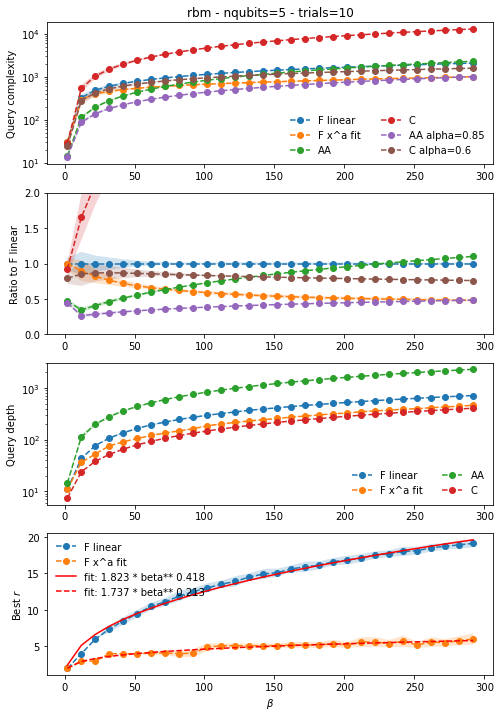

In [193]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(4, figsize=(8,12))
axs[0].set_title('rbm - nqubits=%d - trials=%d' % (nqubits, ntrials))
plot_band(axs[0], beta_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], beta_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F x^a fit')
plot_band(axs[0], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], beta_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')

plot_band(axs[0], beta_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], beta_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Query depth');
axs[2].set_yscale('log')

plot_band(axs[2], beta_range, np.mean(qref_depth, axis=1), np.std(qref_depth, axis=1), label='F linear')
plot_band(axs[2], beta_range, np.nanmean(qopt_depth, axis=1), np.nanstd(qopt_depth, axis=1), label='F x^a fit')
plot_band(axs[2], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[2], beta_range, np.mean(qc_depth, axis=1), np.std(qc_depth, axis=1), label='C')

axs[2].legend(frameon=False, ncol=2)

axs[3].set_xlabel(r'$\beta$')
axs[3].set_ylabel('Best $r$')
plot_band(axs[3], beta_range, np.mean(bestr, axis=1), np.std(bestr, axis=1), label='F linear')
plot_band(axs[3], beta_range, np.mean(bestr_opt, axis=1), np.std(bestr_opt, axis=1), 'F x^a fit')

def func(x, a, b):
    #return a * np.log(np.abs(b) * x) + c
    return a * x ** b

popt, pcov = curve_fit(func, beta_range, np.mean(bestr, axis=1))
axs[3].plot(beta_range, func(beta_range, *popt), 'r-',
        label='fit: %5.3f * beta** %5.3f' % tuple(popt))

popt, pcov = curve_fit(func, beta_range, np.mean(bestr_opt, axis=1))
axs[3].plot(beta_range, func(beta_range, *popt), 'r--',
        label='fit: %5.3f * beta** %5.3f' % tuple(popt))
axs[3].legend(loc='upper left', frameon=False)

plt.savefig('rbm_nqubits_%d.png' % (nqubits), bbox_inches='tight')

x= [0.5 1. ] DeltaBeta= [0.5722318325852646, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5760072683793857, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.6057126007288524, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5702776834122778, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5651335827259047, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5505953643220172, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5521231217505812, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5489247964939626, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5632709440207699, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5657701302160001, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.14631037566106625, 0.4919578386502012, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.14915454302413408, 0.4954659505150126, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.1586281794304201, 0.5068555134326665, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.14630633668035228, 0.4919528263467505, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.14430276518478244, 0.4894555857467476

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.018213685867437764, 0.1022359676362099, 0.28045362057147344, 0.5738647934627268, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.018152100832682296, 0.1020390172948937, 0.2801522931201133, 0.5735953731460771, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.01717236687246946, 0.09886610622461287, 0.2752618513642854, 0.5691997517061442, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.01735840088475517, 0.09947446472896465, 0.2762048425459045, 0.5700507321388318, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.01729297050093773, 0.09926081938338373, 0.27587397129554303, 0.5697523316845102, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.018053296074830003, 0.10172243518584964, 0.2796673931829314, 0.5731614757354948, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.015706460689309306, 0.07833042683719248, 0.20051544876622124, 0.3906453458781476, 0.6553010613570703, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.01741307

<ipython-input-192-1f5a020509b5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.01255688325536661, 0.08272730470670742, 0.24922802601398544, 0.5450243348492934, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.012281740195874418, 0.08169037189315095, 0.24748160863803143, 0.5433527133461881, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.012274891176476621, 0.08166443305062475, 0.2474377966919688, 0.543310692502144, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.013310113817329468, 0.08551704948995792, 0.2538790784927093, 0.5494442687594704, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.01042909155413061, 0.06093872908149286, 0.17114061470143022, 0.3560740341374011, 0.6285581832818293, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.010364093090911458, 0.060705576896193096, 0.17072719873223707, 0.3555706258110738, 0.62815844186175, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.009852951971593128, 0

x= [0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286
 1.        ] DeltaBeta= [0.0075672116701612745, 0.043099691869946805, 0.11924377839021003, 0.24547792770342433, 0.429775296337037, 0.679162990284999, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.008787836983906313, 0.05486520616186961, 0.16017140185310577, 0.34254058793958014, 0.6177012524827092, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.010380177695682717, 0.07422990109881555, 0.23461495314715702, 0.5308269644971173, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.01022084614547387, 0.073579054493107, 0.23346590007717666, 0.5296897324393298, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.01021946570853322, 0.07357339658848283, 0.23345589151606186, 0.5296798130108018, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.009396683483407931, 0.057165639384176375, 0.16437642585012285, 0.34777273619697485, 0.6219261494413587, 1.0] 

x=

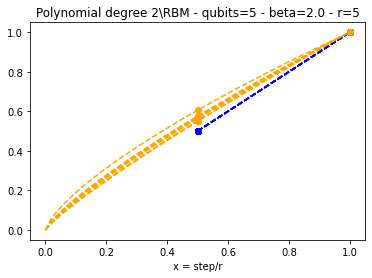

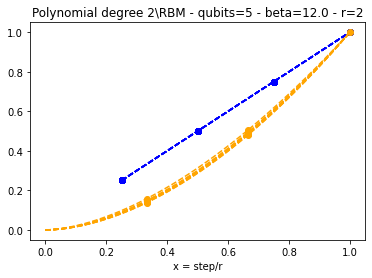

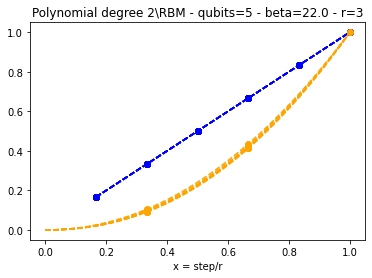

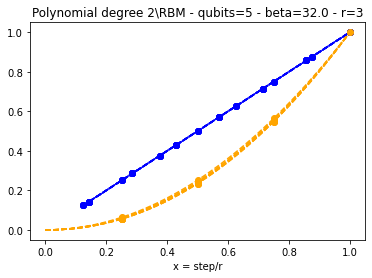

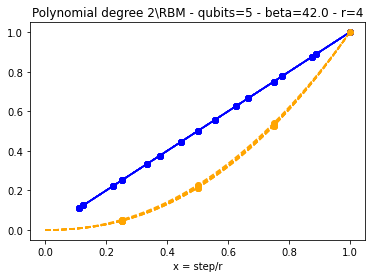

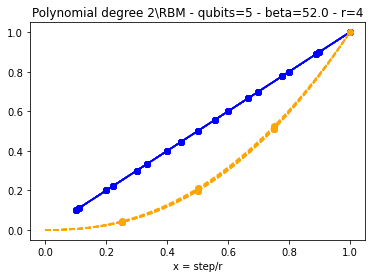

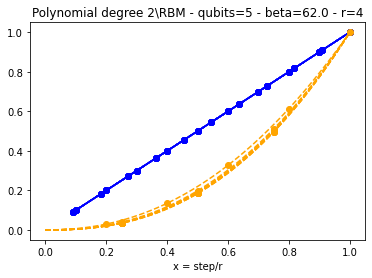

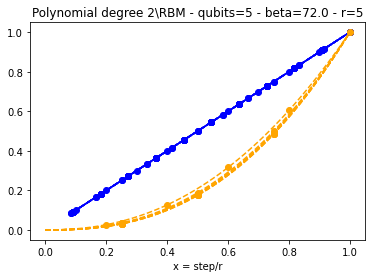

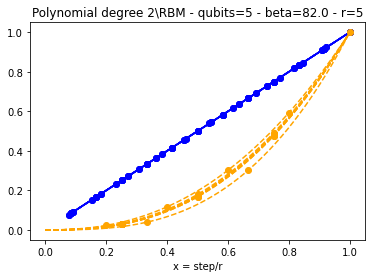

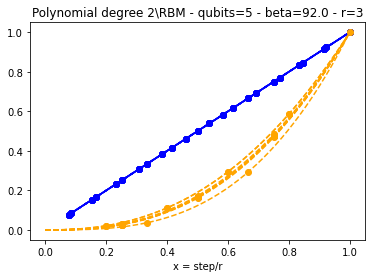

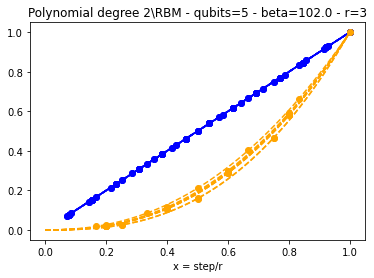

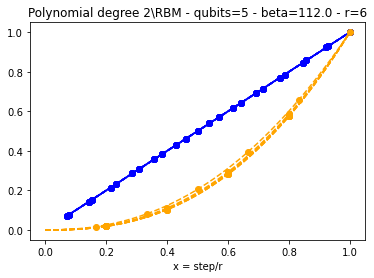

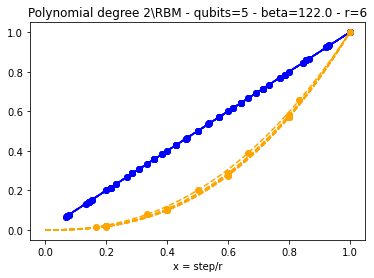

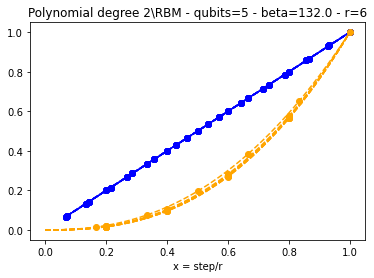

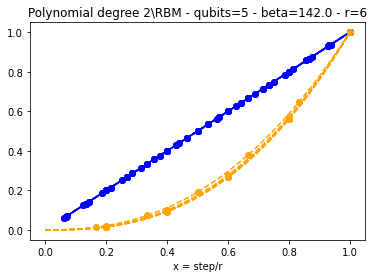

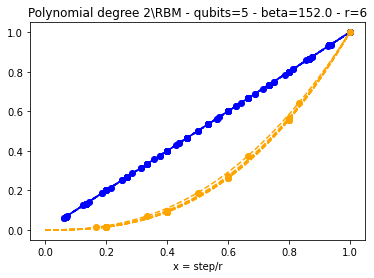

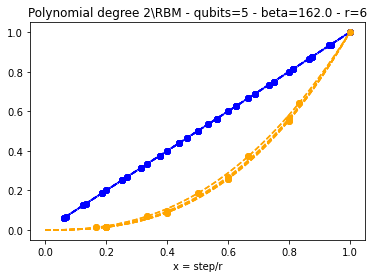

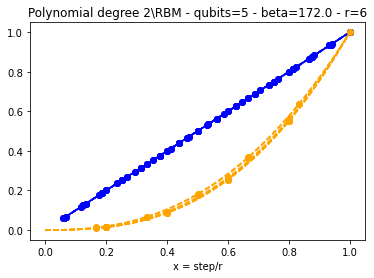

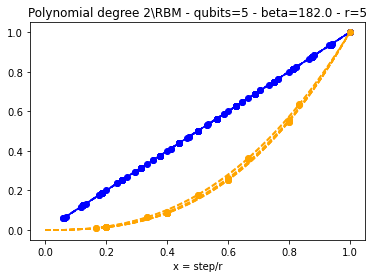

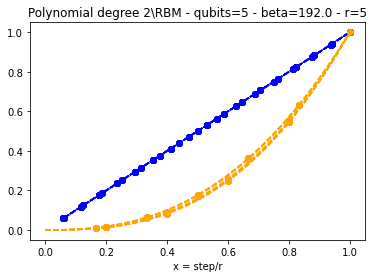

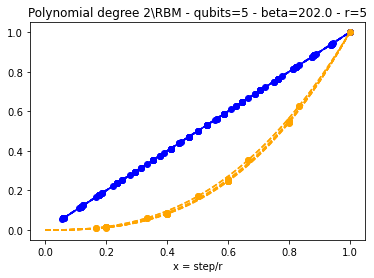

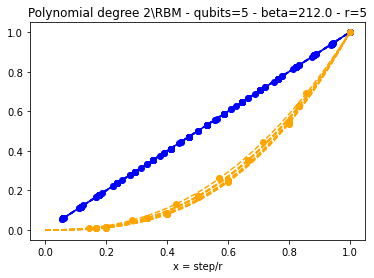

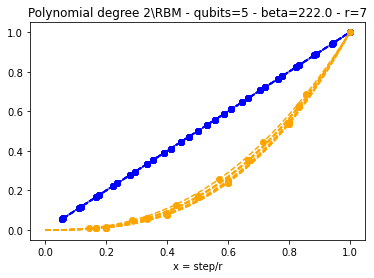

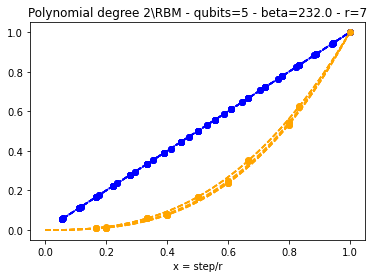

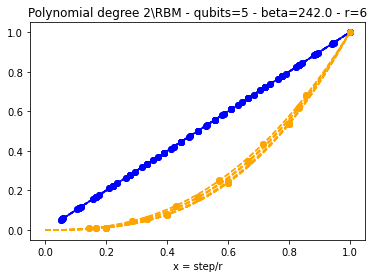

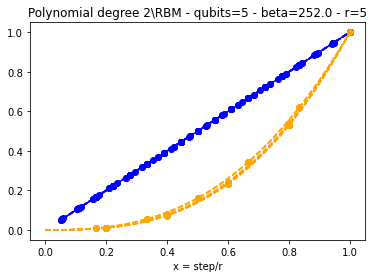

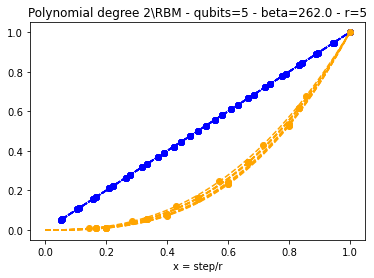

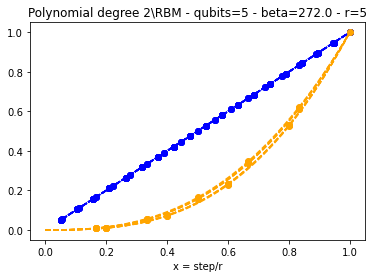

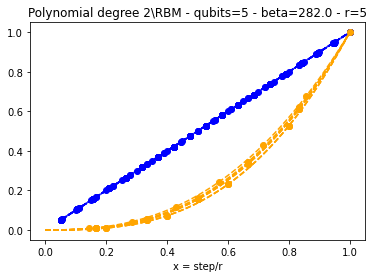

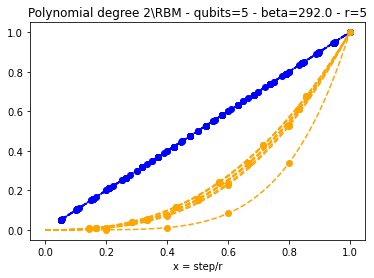

In [192]:
# plot
xx = np.linspace(0,1,50)
for ii, beta in enumerate(beta_range):
    plt.figure()
    plt.title('Polynomial degree %d\RBM - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr, xr, 'o--', color='blue', label=f'r={r}')        
        
        r = int(bestr_opt[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o', color='orange', label=f'r={r}')
        plt.plot(xx,[myschedule(ixr, parameters[ii][jj]) for ixr in xx], '--', color='orange')
        print('x=',xr,'DeltaBeta=',[myschedule(ixr, parameters[ii][jj]) for ixr in xr],'\n')
        
    plt.xlabel('x = step/r')

## Example II

In [198]:
# setup
np.random.seed(0)
ntrials = 10
beta = 200
npol = 1

def myschedule(t, params):
    return t**params[0]


nqubits_range = range(2, 10)
r_range = range(2, 45) 
alpha_c = 0.6
alpha_ampl = 0.85
qref = np.zeros(shape=(len(nqubits_range),ntrials))
qampl = np.zeros(shape=(len(nqubits_range),ntrials))
qampl_alpha = np.zeros(shape=(len(nqubits_range),ntrials))
qc = np.zeros(shape=(len(nqubits_range),ntrials))
qc_alpha = np.zeros(shape=(len(nqubits_range),ntrials))
bestr = np.zeros(shape=(len(nqubits_range), ntrials))
bestr_opt = np.zeros(shape=(len(nqubits_range), ntrials))
qopt = np.zeros(shape=(len(nqubits_range),ntrials))
parameters = np.zeros(shape=(len(nqubits_range), ntrials, npol))

    
for ii, nqubits in enumerate(nqubits_range):

    for nt in range(ntrials):
        print(f'trial={nt} nqubits={nqubits}')
        model = FragmentedQuITE(nqubits, rbm(nqubits), Qu)

        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f'trial={nt}, nqubits={nqubits}, beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]
        if bestr[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

        values2 = []
        params2 = []
        for r in r_range:           
            initial_guess = np.array([1.0])
            result = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    r=r, b=beta,
                                    method='L-BFGS-B', bounds=[[1e-3,1e3]])
            if result.success == False:
                print(result)
                continue
            values2.append(result.fun)
            params2.append(result.x)
            print(f'trial={nt}, nqubits={nqubits}, beta={beta}, r={r}, opt result={result.fun}, param={result.x} success={result.success}')
            
        qopt[ii][nt] = np.min(values2)
        bestr_opt[ii][nt] = r_range[np.argmin(values2)]
        parameters[ii][nt] = params2[np.argmin(values2)]
        if bestr_opt[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

trial=0 nqubits=2
trial=0, nqubits=2, beta=200, r=2, reference=725.4294867364141
trial=0, nqubits=2, beta=200, r=3, reference=603.4084443465908
trial=0, nqubits=2, beta=200, r=4, reference=550.07364308252
trial=0, nqubits=2, beta=200, r=5, reference=524.5432634813315
trial=0, nqubits=2, beta=200, r=6, reference=513.128019317252
trial=0, nqubits=2, beta=200, r=7, reference=509.91632580374807
trial=0, nqubits=2, beta=200, r=8, reference=511.9207912062865
trial=0, nqubits=2, beta=200, r=9, reference=517.4600592944475
trial=0, nqubits=2, beta=200, r=10, reference=525.5109679390946
trial=0, nqubits=2, beta=200, r=11, reference=535.413405348148
trial=0, nqubits=2, beta=200, r=12, reference=546.7220765751572
trial=0, nqubits=2, beta=200, r=13, reference=559.1260914822695
trial=0, nqubits=2, beta=200, r=14, reference=572.4025165967732
trial=0, nqubits=2, beta=200, r=15, reference=586.3881092491889
trial=0, nqubits=2, beta=200, r=16, reference=600.9613480450555
trial=0, nqubits=2, beta=200, r=1

<ipython-input-188-dbb673c93788>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, nqubits=2, beta=200, r=28, opt result=400.81332542348196, param=[95.08301462] success=True
trial=0, nqubits=2, beta=200, r=29, opt result=402.30219247418137, param=[98.65920328] success=True
trial=0, nqubits=2, beta=200, r=30, opt result=403.7770149781377, param=[102.24180074] success=True
trial=0, nqubits=2, beta=200, r=31, opt result=405.238605679348, param=[105.83030388] success=True
trial=0, nqubits=2, beta=200, r=32, opt result=406.6877070330469, param=[109.42493466] success=True
trial=0, nqubits=2, beta=200, r=33, opt result=408.1249990093114, param=[113.02561462] success=True
trial=0, nqubits=2, beta=200, r=34, opt result=409.5511058613914, param=[116.63176337] success=True


<ipython-input-188-dbb673c93788>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, nqubits=2, beta=200, r=35, opt result=410.96660201788166, param=[120.24367988] success=True
trial=0, nqubits=2, beta=200, r=36, opt result=412.3720172121328, param=[123.86117785] success=True
trial=0, nqubits=2, beta=200, r=37, opt result=413.7678409841837, param=[127.48413858] success=True
trial=0, nqubits=2, beta=200, r=38, opt result=415.15452663088286, param=[131.11252425] success=True
trial=0, nqubits=2, beta=200, r=39, opt result=416.53249468544357, param=[134.74601182] success=True
trial=0, nqubits=2, beta=200, r=40, opt result=417.9021359962795, param=[138.38468064] success=True
trial=0, nqubits=2, beta=200, r=41, opt result=419.26381445091533, param=[142.02856766] success=True
trial=0, nqubits=2, beta=200, r=42, opt result=420.6178693974384, param=[145.6772304] success=True
trial=0, nqubits=2, beta=200, r=43, opt result=421.96461780516336, param=[149.33108695] success=True
trial=0, nqubits=2, beta=200, r=44, opt result=423.30435618810657, param=[152.98959003] success=

trial=2, nqubits=2, beta=200, r=35, reference=933.613056249206
trial=2, nqubits=2, beta=200, r=36, reference=953.1680946435574
trial=2, nqubits=2, beta=200, r=37, reference=972.906100080324
trial=2, nqubits=2, beta=200, r=38, reference=992.8269630531678
trial=2, nqubits=2, beta=200, r=39, reference=1012.9306852333735
trial=2, nqubits=2, beta=200, r=40, reference=1033.2173509945942
trial=2, nqubits=2, beta=200, r=41, reference=1053.6871046496703
trial=2, nqubits=2, beta=200, r=42, reference=1074.3401322930715
trial=2, nqubits=2, beta=200, r=43, reference=1095.1766473614766
trial=2, nqubits=2, beta=200, r=44, reference=1116.1968791988297
trial=2, nqubits=2, beta=200, r=2, opt result=335.1715593397073, param=[5.29042104] success=True
trial=2, nqubits=2, beta=200, r=3, opt result=342.6392923188179, param=[9.07676778] success=True
trial=2, nqubits=2, beta=200, r=4, opt result=346.6349904276307, param=[12.75636192] success=True
trial=2, nqubits=2, beta=200, r=5, opt result=347.3894208312256,

trial=3, nqubits=2, beta=200, r=8, opt result=375.2734290172222, param=[16.8584988] success=True
trial=3, nqubits=2, beta=200, r=9, opt result=378.4963334374103, param=[19.36053076] success=True
trial=3, nqubits=2, beta=200, r=10, opt result=381.5960985625077, param=[21.87742609] success=True
trial=3, nqubits=2, beta=200, r=11, opt result=384.5796645283442, param=[24.40951461] success=True
trial=3, nqubits=2, beta=200, r=12, opt result=387.4570807252977, param=[26.95661815] success=True
trial=3, nqubits=2, beta=200, r=13, opt result=390.23873268828095, param=[29.51840285] success=True
trial=3, nqubits=2, beta=200, r=14, opt result=392.93432300959466, param=[32.09441068] success=True
trial=3, nqubits=2, beta=200, r=15, opt result=395.5525537285115, param=[34.68428932] success=True
trial=3, nqubits=2, beta=200, r=16, opt result=398.10109138096266, param=[37.2876008] success=True
trial=3, nqubits=2, beta=200, r=17, opt result=400.58664070452585, param=[39.90399641] success=True
trial=3, n

trial=4, nqubits=2, beta=200, r=21, opt result=485.5082818553741, param=[34.78941855] success=True
trial=4, nqubits=2, beta=200, r=22, opt result=488.82853179513893, param=[36.89495112] success=True
trial=4, nqubits=2, beta=200, r=23, opt result=492.06913282222615, param=[39.01739175] success=True
trial=4, nqubits=2, beta=200, r=24, opt result=495.23661665275625, param=[41.15649225] success=True
trial=4, nqubits=2, beta=200, r=25, opt result=498.33671949639177, param=[43.31159937] success=True
trial=4, nqubits=2, beta=200, r=26, opt result=501.3745057054309, param=[45.48263192] success=True
trial=4, nqubits=2, beta=200, r=27, opt result=504.3544683955206, param=[47.66903553] success=True
trial=4, nqubits=2, beta=200, r=28, opt result=507.2806119874288, param=[49.8705419] success=True
trial=4, nqubits=2, beta=200, r=29, opt result=510.15652042044997, param=[52.08682325] success=True
trial=4, nqubits=2, beta=200, r=30, opt result=512.9854139121986, param=[54.31762607] success=True
trial=

trial=5, nqubits=2, beta=200, r=33, opt result=418.78291650198594, param=[103.13994892] success=True
trial=5, nqubits=2, beta=200, r=34, opt result=420.3364166898595, param=[106.56533822] success=True
trial=5, nqubits=2, beta=200, r=35, opt result=421.8770608701019, param=[109.99845626] success=True
trial=5, nqubits=2, beta=200, r=36, opt result=423.4054650766794, param=[113.43966658] success=True
trial=5, nqubits=2, beta=200, r=37, opt result=424.9222006038986, param=[116.88821815] success=True
trial=5, nqubits=2, beta=200, r=38, opt result=426.427798132636, param=[120.34410321] success=True
trial=5, nqubits=2, beta=200, r=39, opt result=427.92275142154523, param=[123.80759239] success=True
trial=5, nqubits=2, beta=200, r=40, opt result=429.40752059622287, param=[127.27795949] success=True
trial=5, nqubits=2, beta=200, r=41, opt result=430.8825350920128, param=[130.75582281] success=True
trial=5, nqubits=2, beta=200, r=42, opt result=432.3481962964922, param=[134.24078784] success=Tru

trial=7, nqubits=2, beta=200, r=34, reference=917.7784134329369
trial=7, nqubits=2, beta=200, r=35, reference=937.3863035412114
trial=7, nqubits=2, beta=200, r=36, reference=957.1811283266901
trial=7, nqubits=2, beta=200, r=37, reference=977.1624627449928
trial=7, nqubits=2, beta=200, r=38, reference=997.3300498057445
trial=7, nqubits=2, beta=200, r=39, reference=1017.6837622850376
trial=7, nqubits=2, beta=200, r=40, reference=1038.223571848603
trial=7, nqubits=2, beta=200, r=41, reference=1058.9495241784903
trial=7, nqubits=2, beta=200, r=42, reference=1079.861718970253
trial=7, nqubits=2, beta=200, r=43, reference=1100.960293885898
trial=7, nqubits=2, beta=200, r=44, reference=1122.2454117223917
trial=7, nqubits=2, beta=200, r=2, opt result=356.2563052453871, param=[4.60827047] success=True
trial=7, nqubits=2, beta=200, r=3, opt result=363.76625162069985, param=[7.8012175] success=True
trial=7, nqubits=2, beta=200, r=4, opt result=366.0437124029864, param=[10.63040795] success=True
t

trial=8, nqubits=2, beta=200, r=8, opt result=367.7238816963358, param=[16.3074772] success=True
trial=8, nqubits=2, beta=200, r=9, opt result=370.8572621878751, param=[19.17641896] success=True
trial=8, nqubits=2, beta=200, r=10, opt result=373.78584288375623, param=[22.15900622] success=True
trial=8, nqubits=2, beta=200, r=11, opt result=376.5324767273404, param=[25.29285341] success=True
trial=8, nqubits=2, beta=200, r=12, opt result=379.1125588159637, param=[28.66129419] success=True
trial=8, nqubits=2, beta=200, r=13, opt result=381.529853914573, param=[32.50615493] success=True
trial=8, nqubits=2, beta=200, r=14, opt result=383.7698982432368, param=[37.2291375] success=True
trial=8, nqubits=2, beta=200, r=15, opt result=385.8742039553652, param=[41.25925566] success=True
trial=8, nqubits=2, beta=200, r=16, opt result=387.9071910270119, param=[44.83744679] success=True
trial=8, nqubits=2, beta=200, r=17, opt result=389.8876974013041, param=[48.28386069] success=True
trial=8, nqubi

trial=9, nqubits=2, beta=200, r=20, opt result=391.3261986680461, param=[64.18641703] success=True
trial=9, nqubits=2, beta=200, r=21, opt result=393.01749135253976, param=[67.63311382] success=True
trial=9, nqubits=2, beta=200, r=22, opt result=394.6836665026535, param=[71.09119241] success=True
trial=9, nqubits=2, beta=200, r=23, opt result=396.3264716202485, param=[74.56006194] success=True
trial=9, nqubits=2, beta=200, r=24, opt result=397.94748801646375, param=[78.03927961] success=True
trial=9, nqubits=2, beta=200, r=25, opt result=399.54814848486154, param=[81.52845004] success=True
trial=9, nqubits=2, beta=200, r=26, opt result=401.1297533570196, param=[85.02713218] success=True
trial=9, nqubits=2, beta=200, r=27, opt result=402.69348490361284, param=[88.53514378] success=True
trial=9, nqubits=2, beta=200, r=28, opt result=404.2404201420321, param=[92.0518953] success=True
trial=9, nqubits=2, beta=200, r=29, opt result=405.77154218842657, param=[95.57713067] success=True
trial=

trial=0, nqubits=3, beta=200, r=32, opt result=585.5147102167045, param=[84.40227813] success=True
trial=0, nqubits=3, beta=200, r=33, opt result=589.1933070469346, param=[88.16248856] success=True
trial=0, nqubits=3, beta=200, r=34, opt result=592.8048607145779, param=[91.99733281] success=True
trial=0, nqubits=3, beta=200, r=35, opt result=596.3525369212448, param=[95.88266464] success=True
trial=0, nqubits=3, beta=200, r=36, opt result=599.8401377829855, param=[99.79153369] success=True
trial=0, nqubits=3, beta=200, r=37, opt result=603.2719250389766, param=[103.70070482] success=True
trial=0, nqubits=3, beta=200, r=38, opt result=606.6523159702062, param=[107.5917089] success=True
trial=0, nqubits=3, beta=200, r=39, opt result=609.9855906557416, param=[111.45665327] success=True
trial=0, nqubits=3, beta=200, r=40, opt result=613.2756993312867, param=[115.29286201] success=True
trial=0, nqubits=3, beta=200, r=41, opt result=616.5261789246908, param=[119.09853319] success=True
trial=

trial=1, nqubits=3, beta=200, r=44, opt result=600.006957594899, param=[142.47637833] success=True
trial=2 nqubits=3
trial=2, nqubits=3, beta=200, r=2, reference=1309.4640748901531
trial=2, nqubits=3, beta=200, r=3, reference=1010.7921871747998
trial=2, nqubits=3, beta=200, r=4, reference=871.1075444060375
trial=2, nqubits=3, beta=200, r=5, reference=795.1548788120505
trial=2, nqubits=3, beta=200, r=6, reference=751.124974610988
trial=2, nqubits=3, beta=200, r=7, reference=725.3500708906739
trial=2, nqubits=3, beta=200, r=8, reference=710.9765866302979
trial=2, nqubits=3, beta=200, r=9, reference=704.187599001103
trial=2, nqubits=3, beta=200, r=10, reference=702.6900059677461
trial=2, nqubits=3, beta=200, r=11, reference=705.0253604860201
trial=2, nqubits=3, beta=200, r=12, reference=710.2241820020537
trial=2, nqubits=3, beta=200, r=13, reference=717.6190578143322
trial=2, nqubits=3, beta=200, r=14, reference=726.7373402265044
trial=2, nqubits=3, beta=200, r=15, reference=737.236438228

trial=3, nqubits=3, beta=200, r=33, reference=1031.5879243364686
trial=3, nqubits=3, beta=200, r=34, reference=1051.1192336228828
trial=3, nqubits=3, beta=200, r=35, reference=1070.8980089794363
trial=3, nqubits=3, beta=200, r=36, reference=1090.9199973493464
trial=3, nqubits=3, beta=200, r=37, reference=1111.1815120520507
trial=3, nqubits=3, beta=200, r=38, reference=1131.679340700755
trial=3, nqubits=3, beta=200, r=39, reference=1152.4106693993965
trial=3, nqubits=3, beta=200, r=40, reference=1173.3730201123155
trial=3, nqubits=3, beta=200, r=41, reference=1194.5641987379547
trial=3, nqubits=3, beta=200, r=42, reference=1215.9822519155052
trial=3, nqubits=3, beta=200, r=43, reference=1237.6254309835178
trial=3, nqubits=3, beta=200, r=44, reference=1259.4921618169092
trial=3, nqubits=3, beta=200, r=2, opt result=446.7846485676725, param=[4.69797352] success=True
trial=3, nqubits=3, beta=200, r=3, opt result=462.139196058716, param=[7.97436219] success=True
trial=3, nqubits=3, beta=200

trial=4, nqubits=3, beta=200, r=6, opt result=439.66577207063284, param=[6.3057437] success=True
trial=4, nqubits=3, beta=200, r=7, opt result=447.38117562976754, param=[2.55052222] success=True
trial=4, nqubits=3, beta=200, r=8, opt result=460.6941815470379, param=[10.25635878] success=True
trial=4, nqubits=3, beta=200, r=9, opt result=470.159671328718, param=[14.70296958] success=True
trial=4, nqubits=3, beta=200, r=10, opt result=477.6157181877158, param=[18.00301918] success=True
trial=4, nqubits=3, beta=200, r=11, opt result=484.5519759831154, param=[20.71979103] success=True
trial=4, nqubits=3, beta=200, r=12, opt result=491.08395166405637, param=[23.42945399] success=True
trial=4, nqubits=3, beta=200, r=13, opt result=497.2695494362159, param=[26.17998182] success=True
trial=4, nqubits=3, beta=200, r=14, opt result=503.151230397193, param=[28.99449432] success=True
trial=4, nqubits=3, beta=200, r=15, opt result=508.7612659230284, param=[31.89431153] success=True
trial=4, nqubits

trial=5, nqubits=3, beta=200, r=18, opt result=545.2012303269652, param=[40.26433861] success=True
trial=5, nqubits=3, beta=200, r=19, opt result=550.0915522464365, param=[43.332103] success=True
trial=5, nqubits=3, beta=200, r=20, opt result=554.8304968114807, param=[46.43583595] success=True
trial=5, nqubits=3, beta=200, r=21, opt result=559.4338918023432, param=[49.56807256] success=True
trial=5, nqubits=3, beta=200, r=22, opt result=563.91567479951, param=[52.72142607] success=True
trial=5, nqubits=3, beta=200, r=23, opt result=568.288114508191, param=[55.889257] success=True
trial=5, nqubits=3, beta=200, r=24, opt result=572.5619751514848, param=[59.06657791] success=True
trial=5, nqubits=3, beta=200, r=25, opt result=576.7466638072328, param=[62.24963569] success=True
trial=5, nqubits=3, beta=200, r=26, opt result=580.8503775700547, param=[65.43645164] success=True
trial=5, nqubits=3, beta=200, r=27, opt result=584.8802515237745, param=[68.62564158] success=True
trial=5, nqubits=

trial=6, nqubits=3, beta=200, r=30, opt result=570.3825182241851, param=[88.08417107] success=True
trial=6, nqubits=3, beta=200, r=31, opt result=573.746646236367, param=[91.58320339] success=True
trial=6, nqubits=3, beta=200, r=32, opt result=577.0715737924304, param=[95.0702315] success=True
trial=6, nqubits=3, beta=200, r=33, opt result=580.3600714311724, param=[98.54918122] success=True
trial=6, nqubits=3, beta=200, r=34, opt result=583.6145303256169, param=[102.02384568] success=True
trial=6, nqubits=3, beta=200, r=35, opt result=586.8370478992706, param=[105.49627438] success=True
trial=6, nqubits=3, beta=200, r=36, opt result=590.0294866378764, param=[108.96897053] success=True
trial=6, nqubits=3, beta=200, r=37, opt result=593.1935163199029, param=[112.44223884] success=True
trial=6, nqubits=3, beta=200, r=38, opt result=596.3306454364422, param=[115.91761384] success=True
trial=6, nqubits=3, beta=200, r=39, opt result=599.4422453128016, param=[119.39534662] success=True
trial=

trial=7, nqubits=3, beta=200, r=42, opt result=604.2583746580866, param=[133.23938613] success=True
trial=7, nqubits=3, beta=200, r=43, opt result=607.2110276270423, param=[136.66112573] success=True
trial=7, nqubits=3, beta=200, r=44, opt result=610.1468996332055, param=[140.08856904] success=True
trial=8 nqubits=3
trial=8, nqubits=3, beta=200, r=2, reference=1309.4640748901531
trial=8, nqubits=3, beta=200, r=3, reference=1010.7921871704222
trial=8, nqubits=3, beta=200, r=4, reference=871.1075430678511
trial=8, nqubits=3, beta=200, r=5, reference=795.1548385108068
trial=8, nqubits=3, beta=200, r=6, reference=751.1245902213507
trial=8, nqubits=3, beta=200, r=7, reference=725.3481616450208
trial=8, nqubits=3, beta=200, r=8, reference=710.9702643497543
trial=8, nqubits=3, beta=200, r=9, reference=704.1716025746776
trial=8, nqubits=3, beta=200, r=10, reference=702.6564610814494
trial=8, nqubits=3, beta=200, r=11, reference=704.9639781286123
trial=8, nqubits=3, beta=200, r=12, reference=71

trial=9, nqubits=3, beta=200, r=33, reference=1028.7124093051607
trial=9, nqubits=3, beta=200, r=34, reference=1048.1088551732817
trial=9, nqubits=3, beta=200, r=35, reference=1067.752938706454
trial=9, nqubits=3, beta=200, r=36, reference=1087.64036536685
trial=9, nqubits=3, beta=200, r=37, reference=1107.7674054702534
trial=9, nqubits=3, beta=200, r=38, reference=1128.1308032937623
trial=9, nqubits=3, beta=200, r=39, reference=1148.7277021115117
trial=9, nqubits=3, beta=200, r=40, reference=1169.5555821337905
trial=9, nqubits=3, beta=200, r=41, reference=1190.6122089467237
trial=9, nqubits=3, beta=200, r=42, reference=1211.8955905336702
trial=9, nqubits=3, beta=200, r=43, reference=1233.40394133834
trial=9, nqubits=3, beta=200, r=44, reference=1255.1356521278522
trial=9, nqubits=3, beta=200, r=2, opt result=432.1630279541022, param=[4.82322095] success=True
trial=9, nqubits=3, beta=200, r=3, opt result=447.8983126111717, param=[8.22783068] success=True
trial=9, nqubits=3, beta=200, r

trial=0, nqubits=4, beta=200, r=6, opt result=603.826834259417, param=[2.56739498] success=True
trial=0, nqubits=4, beta=200, r=7, opt result=617.9897583974292, param=[2.42278752] success=True
trial=0, nqubits=4, beta=200, r=8, opt result=635.1593982759434, param=[2.30651468] success=True
trial=0, nqubits=4, beta=200, r=9, opt result=654.3500012305096, param=[2.20820792] success=True
trial=0, nqubits=4, beta=200, r=10, opt result=732.3349329633405, param=[11.78903049] success=True
trial=0, nqubits=4, beta=200, r=11, opt result=752.8120187246033, param=[14.2002421] success=True
trial=0, nqubits=4, beta=200, r=12, opt result=771.5557330408136, param=[16.73275343] success=True
trial=0, nqubits=4, beta=200, r=13, opt result=788.6277310427979, param=[19.82816785] success=True
trial=0, nqubits=4, beta=200, r=14, opt result=804.1046830909296, param=[23.02151904] success=True
trial=0, nqubits=4, beta=200, r=15, opt result=818.5687395389272, param=[25.69781925] success=True
trial=0, nqubits=4, 

trial=1, nqubits=4, beta=200, r=18, opt result=803.3683500147603, param=[36.70457662] success=True
trial=1, nqubits=4, beta=200, r=19, opt result=814.300972683385, param=[39.38969617] success=True
trial=1, nqubits=4, beta=200, r=20, opt result=824.909078954154, param=[42.12432282] success=True
trial=1, nqubits=4, beta=200, r=21, opt result=835.2167576321782, param=[44.91525849] success=True
trial=1, nqubits=4, beta=200, r=22, opt result=845.243754752988, param=[47.77113162] success=True
trial=1, nqubits=4, beta=200, r=23, opt result=855.005883328944, param=[50.70345765] success=True
trial=1, nqubits=4, beta=200, r=24, opt result=864.5151551279005, param=[53.72885385] success=True
trial=1, nqubits=4, beta=200, r=25, opt result=873.7795401444616, param=[56.87304706] success=True
trial=1, nqubits=4, beta=200, r=26, opt result=882.8020723810498, param=[60.17838419] success=True
trial=1, nqubits=4, beta=200, r=27, opt result=891.5784512440002, param=[63.72904848] success=True
trial=1, nqubi

trial=2, nqubits=4, beta=200, r=30, opt result=956.0408909875888, param=[68.6140336] success=True
trial=2, nqubits=4, beta=200, r=31, opt result=964.7439969708028, param=[71.57826476] success=True
trial=2, nqubits=4, beta=200, r=32, opt result=973.3069694917573, param=[74.58438764] success=True
trial=2, nqubits=4, beta=200, r=33, opt result=981.7358233858491, param=[77.63393241] success=True
trial=2, nqubits=4, beta=200, r=34, opt result=990.0360854505305, param=[80.72669328] success=True
trial=2, nqubits=4, beta=200, r=35, opt result=998.2128837813652, param=[83.86292532] success=True
trial=2, nqubits=4, beta=200, r=36, opt result=1006.271030410121, param=[87.04193724] success=True
trial=2, nqubits=4, beta=200, r=37, opt result=1014.2150970409634, param=[90.26298596] success=True
trial=2, nqubits=4, beta=200, r=38, opt result=1022.0494826546055, param=[93.52397099] success=True
trial=2, nqubits=4, beta=200, r=39, opt result=1029.778470903689, param=[96.82266497] success=True
trial=2, 

trial=3, nqubits=4, beta=200, r=42, opt result=1045.639742009356, param=[100.46126206] success=True
trial=3, nqubits=4, beta=200, r=43, opt result=1053.4829130647088, param=[103.45039376] success=True
trial=3, nqubits=4, beta=200, r=44, opt result=1061.249033353937, param=[106.47125523] success=True
trial=4 nqubits=4
trial=4, nqubits=4, beta=200, r=2, reference=2480.15767764324
trial=4, nqubits=4, beta=200, r=3, reference=1828.1148326853804
trial=4, nqubits=4, beta=200, r=4, reference=1515.7595470256801
trial=4, nqubits=4, beta=200, r=5, reference=1339.157942799974
trial=4, nqubits=4, beta=200, r=6, reference=1230.266466717203
trial=4, nqubits=4, beta=200, r=7, reference=1159.8792864960594
trial=4, nqubits=4, beta=200, r=8, reference=1113.3795988190243
trial=4, nqubits=4, beta=200, r=9, reference=1082.6521294585025
trial=4, nqubits=4, beta=200, r=10, reference=1062.8417491558107
trial=4, nqubits=4, beta=200, r=11, reference=1050.875917937238
trial=4, nqubits=4, beta=200, r=12, referenc

trial=5, nqubits=4, beta=200, r=31, reference=1272.4268105526337
trial=5, nqubits=4, beta=200, r=32, reference=1291.9988242866295
trial=5, nqubits=4, beta=200, r=33, reference=1311.9766093992528
trial=5, nqubits=4, beta=200, r=34, reference=1332.3453528834282
trial=5, nqubits=4, beta=200, r=35, reference=1353.0920114531864
trial=5, nqubits=4, beta=200, r=36, reference=1374.2050411943355
trial=5, nqubits=4, beta=200, r=37, reference=1395.674175155095
trial=5, nqubits=4, beta=200, r=38, reference=1417.4902393639413
trial=5, nqubits=4, beta=200, r=39, reference=1439.6449998306823
trial=5, nqubits=4, beta=200, r=40, reference=1462.1310346693356
trial=5, nqubits=4, beta=200, r=41, reference=1484.9416267000868
trial=5, nqubits=4, beta=200, r=42, reference=1508.070672831815
trial=5, nqubits=4, beta=200, r=43, reference=1531.5126072627509
trial=5, nqubits=4, beta=200, r=44, reference=1555.2623361139388
trial=5, nqubits=4, beta=200, r=2, opt result=677.0307810902865, param=[4.55561874] success=

trial=6, nqubits=4, beta=200, r=7, opt result=564.3409623064699, param=[2.44288843] success=True
trial=6, nqubits=4, beta=200, r=8, opt result=631.339717551972, param=[12.91681213] success=True
trial=6, nqubits=4, beta=200, r=9, opt result=694.3550750347933, param=[27.40939009] success=True
trial=6, nqubits=4, beta=200, r=10, opt result=703.0438679154329, param=[30.61628747] success=True
trial=6, nqubits=4, beta=200, r=11, opt result=711.5069088356829, param=[33.84939277] success=True
trial=6, nqubits=4, beta=200, r=12, opt result=719.7586675565293, param=[37.10821349] success=True
trial=6, nqubits=4, beta=200, r=13, opt result=703.6579635388778, param=[24.82019299] success=True
trial=6, nqubits=4, beta=200, r=14, opt result=716.3429636936141, param=[27.26526103] success=True
trial=6, nqubits=4, beta=200, r=15, opt result=728.5572539474591, param=[29.74698591] success=True
trial=6, nqubits=4, beta=200, r=16, opt result=740.3457516213803, param=[32.26779364] success=True
trial=6, nqubit

trial=7, nqubits=4, beta=200, r=19, opt result=785.5144854257242, param=[39.55321369] success=True
trial=7, nqubits=4, beta=200, r=20, opt result=796.17840037507, param=[42.09062695] success=True
trial=7, nqubits=4, beta=200, r=21, opt result=806.5923583143197, param=[44.654469] success=True
trial=7, nqubits=4, beta=200, r=22, opt result=816.7752160879184, param=[47.2454945] success=True
trial=7, nqubits=4, beta=200, r=23, opt result=826.7434765075728, param=[49.86467725] success=True
trial=7, nqubits=4, beta=200, r=24, opt result=836.5116058841347, param=[52.51317209] success=True
trial=7, nqubits=4, beta=200, r=25, opt result=846.0922987683145, param=[55.19245895] success=True
trial=7, nqubits=4, beta=200, r=26, opt result=855.4966967042568, param=[57.90407981] success=True
trial=7, nqubits=4, beta=200, r=27, opt result=864.734567218487, param=[60.64896316] success=True
trial=7, nqubits=4, beta=200, r=28, opt result=873.8144456975704, param=[63.43336003] success=True
trial=7, nqubits

trial=8, nqubits=4, beta=200, r=31, opt result=917.683735613957, param=[74.64013327] success=True
trial=8, nqubits=4, beta=200, r=32, opt result=925.8619782068442, param=[77.94815694] success=True
trial=8, nqubits=4, beta=200, r=33, opt result=933.8911729747466, param=[81.36867269] success=True
trial=8, nqubits=4, beta=200, r=34, opt result=941.77168740176, param=[84.9223665] success=True
trial=8, nqubits=4, beta=200, r=35, opt result=949.5025495666225, param=[88.63443263] success=True
trial=8, nqubits=4, beta=200, r=36, opt result=957.0816391211546, param=[92.53000981] success=True
      fun: 964.5064707142845
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.13686909e-05])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 90
      nit: 8
     njev: 45
   status: 2
  success: False
        x: array([96.62274908])
trial=8, nqubits=4, beta=200, r=38, opt result=971.7761594478451, param=[100.88903106] success=True
trial=8, nqubits=4, beta=200, r=39, opt re

trial=9, nqubits=4, beta=200, r=41, opt result=1063.7644796465918, param=[99.67911115] success=True
trial=9, nqubits=4, beta=200, r=42, opt result=1071.5079958731278, param=[102.75680454] success=True
trial=9, nqubits=4, beta=200, r=43, opt result=1079.1714615027818, param=[105.85711058] success=True
trial=9, nqubits=4, beta=200, r=44, opt result=1086.7578199185718, param=[108.97962365] success=True
trial=0 nqubits=5
trial=0, nqubits=5, beta=200, r=2, reference=4826.78183557664
trial=0, nqubits=5, beta=200, r=3, reference=3467.738721505648
trial=0, nqubits=5, beta=200, r=4, reference=2809.4825897568044
trial=0, nqubits=5, beta=200, r=5, reference=2430.5830327815743
trial=0, nqubits=5, beta=200, r=6, reference=2190.560122067567
trial=0, nqubits=5, beta=200, r=7, reference=2029.231013943914
trial=0, nqubits=5, beta=200, r=8, reference=1916.5467832644206
trial=0, nqubits=5, beta=200, r=9, reference=1835.8668640807898
trial=0, nqubits=5, beta=200, r=10, reference=1777.2626514387123
trial=0

trial=1, nqubits=5, beta=200, r=23, reference=1672.3984177861357
trial=1, nqubits=5, beta=200, r=24, reference=1683.6299315830659
trial=1, nqubits=5, beta=200, r=25, reference=1696.0672841264695
trial=1, nqubits=5, beta=200, r=26, reference=1709.6046663399388
trial=1, nqubits=5, beta=200, r=27, reference=1724.1527723699255
trial=1, nqubits=5, beta=200, r=28, reference=1739.6356068658288
trial=1, nqubits=5, beta=200, r=29, reference=1755.988004512549
trial=1, nqubits=5, beta=200, r=30, reference=1773.153685615957
trial=1, nqubits=5, beta=200, r=31, reference=1791.0837188086962
trial=1, nqubits=5, beta=200, r=32, reference=1809.73529563909
trial=1, nqubits=5, beta=200, r=33, reference=1829.0707460684405
trial=1, nqubits=5, beta=200, r=34, reference=1849.056741536333
trial=1, nqubits=5, beta=200, r=35, reference=1869.66364518321
trial=1, nqubits=5, beta=200, r=36, reference=1890.8649783783833
trial=1, nqubits=5, beta=200, r=37, reference=1912.6369798244014
trial=1, nqubits=5, beta=200, r=

trial=2, nqubits=5, beta=200, r=2, opt result=923.3826310902884, param=[4.89490032] success=True
trial=2, nqubits=5, beta=200, r=3, opt result=989.0457407291059, param=[8.36376192] success=True
trial=2, nqubits=5, beta=200, r=4, opt result=1019.0483686649375, param=[11.6792739] success=True
trial=2, nqubits=5, beta=200, r=5, opt result=833.3931666394756, param=[4.55707162] success=True
trial=2, nqubits=5, beta=200, r=6, opt result=793.8151831508005, param=[2.54624215] success=True
trial=2, nqubits=5, beta=200, r=7, opt result=809.8106492191828, param=[2.39872174] success=True
trial=2, nqubits=5, beta=200, r=8, opt result=829.5467824804063, param=[2.28171222] success=True
trial=2, nqubits=5, beta=200, r=9, opt result=1120.646313596497, param=[27.94578232] success=True
trial=2, nqubits=5, beta=200, r=10, opt result=1138.3739231582076, param=[31.22926316] success=True
trial=2, nqubits=5, beta=200, r=11, opt result=1155.5515589857623, param=[34.53000392] success=True
trial=2, nqubits=5, be

trial=3, nqubits=5, beta=200, r=15, opt result=1188.1897240551798, param=[29.03246185] success=True
trial=3, nqubits=5, beta=200, r=16, opt result=1212.6500860673518, param=[31.47325388] success=True
trial=3, nqubits=5, beta=200, r=17, opt result=1236.324030888064, param=[33.94796988] success=True
trial=3, nqubits=5, beta=200, r=18, opt result=1259.2802978192385, param=[36.45887621] success=True
trial=3, nqubits=5, beta=200, r=19, opt result=1281.577797914968, param=[39.00880882] success=True
trial=3, nqubits=5, beta=200, r=20, opt result=1303.2667300498201, param=[41.60139922] success=True
trial=3, nqubits=5, beta=200, r=21, opt result=1324.389517995851, param=[44.24142508] success=True
trial=3, nqubits=5, beta=200, r=22, opt result=1344.9814927803486, param=[46.93558057] success=True
trial=3, nqubits=5, beta=200, r=23, opt result=1365.0712422989816, param=[49.69310784] success=True
trial=3, nqubits=5, beta=200, r=24, opt result=1347.4410726568094, param=[78.43880745] success=True
tri

trial=4, nqubits=5, beta=200, r=27, opt result=1628.9679988801647, param=[58.1256136] success=True
trial=4, nqubits=5, beta=200, r=28, opt result=1647.9640871862464, param=[60.99126047] success=True
trial=4, nqubits=5, beta=200, r=29, opt result=1638.809951879913, param=[1.38795589] success=True
trial=4, nqubits=5, beta=200, r=30, opt result=1675.3549618079446, param=[1.3708955] success=True
trial=4, nqubits=5, beta=200, r=31, opt result=1700.4640077501808, param=[95.20418862] success=True
trial=4, nqubits=5, beta=200, r=32, opt result=1713.4305254805768, param=[98.69751505] success=True
trial=4, nqubits=5, beta=200, r=33, opt result=1726.264544047943, param=[102.18606887] success=True
trial=4, nqubits=5, beta=200, r=34, opt result=1738.9741204018253, param=[105.6722983] success=True
trial=4, nqubits=5, beta=200, r=35, opt result=1751.5664376701216, param=[109.15779239] success=True
trial=4, nqubits=5, beta=200, r=36, opt result=1764.0479628459145, param=[112.64389278] success=True
tri

trial=5, nqubits=5, beta=200, r=39, opt result=1641.0507618988722, param=[120.53452649] success=True
trial=5, nqubits=5, beta=200, r=40, opt result=1653.4575121652824, param=[123.96805336] success=True
trial=5, nqubits=5, beta=200, r=41, opt result=1665.7758126889962, param=[127.4055517] success=True
trial=5, nqubits=5, beta=200, r=42, opt result=1678.009563627626, param=[130.84707111] success=True
trial=5, nqubits=5, beta=200, r=43, opt result=1690.1623935037787, param=[134.2927641] success=True
trial=5, nqubits=5, beta=200, r=44, opt result=1702.2376853474589, param=[137.74291121] success=True
trial=6 nqubits=5
trial=6, nqubits=5, beta=200, r=2, reference=4827.180100089911
trial=6, nqubits=5, beta=200, r=3, reference=3469.867853252317
trial=6, nqubits=5, beta=200, r=4, reference=2814.0381896596336
trial=6, nqubits=5, beta=200, r=5, reference=2437.662618597345
trial=6, nqubits=5, beta=200, r=6, reference=2200.0251865744485
trial=6, nqubits=5, beta=200, r=7, reference=2040.887894391214

trial=7, nqubits=5, beta=200, r=26, reference=1709.033971417894
trial=7, nqubits=5, beta=200, r=27, reference=1723.5144644896413
trial=7, nqubits=5, beta=200, r=28, reference=1738.9267792046428
trial=7, nqubits=5, beta=200, r=29, reference=1755.205746676519
trial=7, nqubits=5, beta=200, r=30, reference=1772.295078792787
trial=7, nqubits=5, beta=200, r=31, reference=1790.1458346171155
trial=7, nqubits=5, beta=200, r=32, reference=1808.7151976877396
trial=7, nqubits=5, beta=200, r=33, reference=1827.965493400333
trial=7, nqubits=5, beta=200, r=34, reference=1847.8633932909863
trial=7, nqubits=5, beta=200, r=35, reference=1868.3792659492533
trial=7, nqubits=5, beta=200, r=36, reference=1889.4866438314355
trial=7, nqubits=5, beta=200, r=37, reference=1911.1617823476702
trial=7, nqubits=5, beta=200, r=38, reference=1933.3832929256341
trial=7, nqubits=5, beta=200, r=39, reference=1956.1318357810335
trial=7, nqubits=5, beta=200, r=40, reference=1979.3898611900247
trial=7, nqubits=5, beta=200,

trial=8, nqubits=5, beta=200, r=44, reference=2086.3690103510576
trial=8, nqubits=5, beta=200, r=2, opt result=978.5744925177094, param=[4.73113556] success=True
trial=8, nqubits=5, beta=200, r=3, opt result=1044.3511114100154, param=[8.06257603] success=True
trial=8, nqubits=5, beta=200, r=4, opt result=1071.0734526768656, param=[11.20038237] success=True
trial=8, nqubits=5, beta=200, r=5, opt result=922.158695633524, param=[7.05830388] success=True
trial=8, nqubits=5, beta=200, r=6, opt result=819.2250882888351, param=[2.5294397] success=True
trial=8, nqubits=5, beta=200, r=7, opt result=834.5788075914279, param=[2.38400662] success=True
trial=8, nqubits=5, beta=200, r=8, opt result=854.2466530390291, param=[2.26663552] success=True
trial=8, nqubits=5, beta=200, r=9, opt result=1166.6707831356216, param=[26.28354137] success=True
trial=8, nqubits=5, beta=200, r=10, opt result=1184.4759050011958, param=[29.33576946] success=True
trial=8, nqubits=5, beta=200, r=11, opt result=1201.9219

trial=9, nqubits=5, beta=200, r=13, opt result=1220.9151851599133, param=[22.78272375] success=True
trial=9, nqubits=5, beta=200, r=14, opt result=1248.9659404881554, param=[25.20653674] success=True
trial=9, nqubits=5, beta=200, r=15, opt result=1275.8923814576954, param=[27.59822411] success=True
trial=9, nqubits=5, beta=200, r=16, opt result=1301.8417932978389, param=[29.98793911] success=True
trial=9, nqubits=5, beta=200, r=17, opt result=1326.925757049782, param=[32.38716658] success=True
trial=9, nqubits=5, beta=200, r=18, opt result=1351.2347107498974, param=[34.80147921] success=True
trial=9, nqubits=5, beta=200, r=19, opt result=1374.8440848479447, param=[37.23419199] success=True
trial=9, nqubits=5, beta=200, r=20, opt result=1397.8177712839483, param=[39.6874294] success=True
trial=9, nqubits=5, beta=200, r=21, opt result=1420.2104290131108, param=[42.16281052] success=True
trial=9, nqubits=5, beta=200, r=22, opt result=1442.069155437238, param=[44.66176613] success=True
tri

trial=0, nqubits=6, beta=200, r=25, opt result=2154.3694946351793, param=[1.4540755] success=True
trial=0, nqubits=6, beta=200, r=26, opt result=2201.193210328259, param=[1.43360972] success=True
trial=0, nqubits=6, beta=200, r=27, opt result=2248.079233263249, param=[1.4143018] success=True
trial=0, nqubits=6, beta=200, r=28, opt result=2295.021045712745, param=[1.39604648] success=True
trial=0, nqubits=6, beta=200, r=29, opt result=2342.01404248488, param=[1.37875133] success=True
trial=0, nqubits=6, beta=200, r=30, opt result=2389.0551589723354, param=[1.36233428] success=True
trial=0, nqubits=6, beta=200, r=31, opt result=2436.1425721873065, param=[1.34672391] success=True
trial=0, nqubits=6, beta=200, r=32, opt result=2483.2754589743945, param=[1.33185526] success=True
trial=0, nqubits=6, beta=200, r=33, opt result=2530.4537994531524, param=[1.31767129] success=True
trial=0, nqubits=6, beta=200, r=34, opt result=2577.678216556726, param=[1.30412053] success=True
trial=0, nqubits=6

trial=1, nqubits=6, beta=200, r=37, opt result=2565.304993838775, param=[1.28759191] success=True
trial=1, nqubits=6, beta=200, r=38, opt result=2609.9928308434405, param=[1.27633958] success=True
trial=1, nqubits=6, beta=200, r=39, opt result=2654.7405254947125, param=[1.26552575] success=True
trial=1, nqubits=6, beta=200, r=40, opt result=2699.5503115185475, param=[1.25512262] success=True
trial=1, nqubits=6, beta=200, r=41, opt result=2744.424521209125, param=[1.24510436] success=True
trial=1, nqubits=6, beta=200, r=42, opt result=2789.365551924246, param=[1.23544799] success=True
trial=1, nqubits=6, beta=200, r=43, opt result=2834.3758385493, param=[1.22613205] success=True
trial=1, nqubits=6, beta=200, r=44, opt result=2879.4578309471735, param=[1.21713687] success=True
trial=2 nqubits=6
trial=2, nqubits=6, beta=200, r=2, reference=7507.139231484676
trial=2, nqubits=6, beta=200, r=3, reference=5363.012015831309
trial=2, nqubits=6, beta=200, r=4, reference=4322.589398701667
trial=2

trial=3, nqubits=6, beta=200, r=18, reference=2807.5141747927373
trial=3, nqubits=6, beta=200, r=19, reference=2795.455858087197
trial=3, nqubits=6, beta=200, r=20, reference=2787.7183008751867
trial=3, nqubits=6, beta=200, r=21, reference=2783.72684084826
trial=3, nqubits=6, beta=200, r=22, reference=2783.0193079937326
trial=3, nqubits=6, beta=200, r=23, reference=2785.2196090396783
trial=3, nqubits=6, beta=200, r=24, reference=2790.0183002716726
trial=3, nqubits=6, beta=200, r=25, reference=2797.1581276100633
trial=3, nqubits=6, beta=200, r=26, reference=2806.423142406635
trial=3, nqubits=6, beta=200, r=27, reference=2817.6304214031325
trial=3, nqubits=6, beta=200, r=28, reference=2830.62370390765
trial=3, nqubits=6, beta=200, r=29, reference=2845.26845485495
trial=3, nqubits=6, beta=200, r=30, reference=2861.447998572225
trial=3, nqubits=6, beta=200, r=31, reference=2879.0604639431162
trial=3, nqubits=6, beta=200, r=32, reference=2898.0163498866796
trial=3, nqubits=6, beta=200, r=33

trial=4, nqubits=6, beta=200, r=42, reference=3169.1790163302035
trial=4, nqubits=6, beta=200, r=43, reference=3199.4852170495055
trial=4, nqubits=6, beta=200, r=44, reference=3230.5669667044663
trial=4, nqubits=6, beta=200, r=2, opt result=1788.1238495125717, param=[4.77906887] success=True
trial=4, nqubits=6, beta=200, r=3, opt result=1921.5812915319043, param=[8.14644158] success=True
trial=4, nqubits=6, beta=200, r=4, opt result=1976.9534324145907, param=[11.30088153] success=True
trial=4, nqubits=6, beta=200, r=5, opt result=1327.0189627736975, param=[2.73188097] success=True
trial=4, nqubits=6, beta=200, r=6, opt result=1333.4698026182816, param=[2.53032278] success=True
trial=4, nqubits=6, beta=200, r=7, opt result=1353.1803250129153, param=[2.3801652] success=True
trial=4, nqubits=6, beta=200, r=8, opt result=1380.7340052212387, param=[2.26024691] success=True
trial=4, nqubits=6, beta=200, r=9, opt result=1413.3493641056416, param=[2.16000157] success=True
trial=4, nqubits=6, b

trial=5, nqubits=6, beta=200, r=12, opt result=1509.4443149486156, param=[1.93912198] success=True
trial=5, nqubits=6, beta=200, r=13, opt result=1550.5692935433221, param=[1.88013898] success=True
trial=5, nqubits=6, beta=200, r=14, opt result=2110.602932406408, param=[26.5428149] success=True
trial=5, nqubits=6, beta=200, r=15, opt result=2162.086376649674, param=[28.9181463] success=True
trial=5, nqubits=6, beta=200, r=16, opt result=2211.8585763777055, param=[31.31755768] success=True
trial=5, nqubits=6, beta=200, r=17, opt result=2260.0821982516013, param=[33.74214888] success=True
trial=5, nqubits=6, beta=200, r=18, opt result=2306.8984860822193, param=[36.19294596] success=True
trial=5, nqubits=6, beta=200, r=19, opt result=2352.4298273545396, param=[38.67102078] success=True
trial=5, nqubits=6, beta=200, r=20, opt result=2396.7822588779513, param=[41.17751295] success=True
trial=5, nqubits=6, beta=200, r=21, opt result=2440.0477120658506, param=[43.71384999] success=True
trial=

trial=6, nqubits=6, beta=200, r=24, opt result=2115.9942603237405, param=[1.47402944] success=True
trial=6, nqubits=6, beta=200, r=25, opt result=2162.956885905728, param=[1.45232078] success=True
trial=6, nqubits=6, beta=200, r=26, opt result=2209.99292143139, param=[1.43188836] success=True
trial=6, nqubits=6, beta=200, r=27, opt result=2257.093421549716, param=[1.41261189] success=True
trial=6, nqubits=6, beta=200, r=28, opt result=2304.25183751006, param=[1.39438611] success=True
trial=6, nqubits=6, beta=200, r=29, opt result=2351.4635462160827, param=[1.37711886] success=True
trial=6, nqubits=6, beta=200, r=30, opt result=2398.725474601112, param=[1.36072843] success=True
trial=6, nqubits=6, beta=200, r=31, opt result=2446.035797865025, param=[1.34514283] success=True
trial=6, nqubits=6, beta=200, r=32, opt result=2493.39369556077, param=[1.33029797] success=True
trial=6, nqubits=6, beta=200, r=33, opt result=2540.799153431882, param=[1.31613657] success=True
trial=6, nqubits=6, b

trial=7, nqubits=6, beta=200, r=36, opt result=2641.7738862607484, param=[1.27420631] success=True
trial=7, nqubits=6, beta=200, r=37, opt result=2688.2358286074514, param=[1.26242283] success=True
trial=7, nqubits=6, beta=200, r=38, opt result=2734.7471126513683, param=[1.25111068] success=True
trial=7, nqubits=6, beta=200, r=39, opt result=2781.310079383443, param=[1.24023895] success=True
trial=7, nqubits=6, beta=200, r=40, opt result=2827.9272008759694, param=[1.22977966] success=True
trial=7, nqubits=6, beta=200, r=41, opt result=2874.601039290703, param=[1.21970708] success=True
trial=7, nqubits=6, beta=200, r=42, opt result=2921.334213225041, param=[1.20999786] success=True
trial=7, nqubits=6, beta=200, r=43, opt result=2968.129370162064, param=[1.20063034] success=True
trial=7, nqubits=6, beta=200, r=44, opt result=3014.9891640058236, param=[1.19158481] success=True
trial=8 nqubits=6
trial=8, nqubits=6, beta=200, r=2, reference=9530.594578365008
trial=8, nqubits=6, beta=200, r=

trial=9, nqubits=6, beta=200, r=21, reference=2789.6626611485963
trial=9, nqubits=6, beta=200, r=22, reference=2789.5248766641407
trial=9, nqubits=6, beta=200, r=23, reference=2792.324693456066
trial=9, nqubits=6, beta=200, r=24, reference=2797.751955749345
trial=9, nqubits=6, beta=200, r=25, reference=2805.548619514984
trial=9, nqubits=6, beta=200, r=26, reference=2815.4978955352876
trial=9, nqubits=6, beta=200, r=27, reference=2827.415990838063
trial=9, nqubits=6, beta=200, r=28, reference=2841.1457627432137
trial=9, nqubits=6, beta=200, r=29, reference=2856.5517951069824
trial=9, nqubits=6, beta=200, r=30, reference=2873.5165423045355
trial=9, nqubits=6, beta=200, r=31, reference=2891.9372822126
trial=9, nqubits=6, beta=200, r=32, reference=2911.723687563939
trial=9, nqubits=6, beta=200, r=33, reference=2932.7958739852365
trial=9, nqubits=6, beta=200, r=34, reference=2955.0828185176397
trial=9, nqubits=6, beta=200, r=35, reference=2978.521068374575
trial=9, nqubits=6, beta=200, r=36

trial=0, nqubits=7, beta=200, r=5, opt result=2802.8215441880957, param=[7.42313167] success=True
trial=0, nqubits=7, beta=200, r=6, opt result=2307.516034741069, param=[2.494592] success=True
trial=0, nqubits=7, beta=200, r=7, opt result=2335.712987553733, param=[2.34729109] success=True
trial=0, nqubits=7, beta=200, r=8, opt result=2376.8208170523903, param=[2.23092317] success=True
trial=0, nqubits=7, beta=200, r=9, opt result=3762.8225985267172, param=[28.15515191] success=True
trial=0, nqubits=7, beta=200, r=10, opt result=3836.845866051287, param=[31.47149245] success=True
trial=0, nqubits=7, beta=200, r=11, opt result=3908.2343751471494, param=[34.80101701] success=True
trial=0, nqubits=7, beta=200, r=12, opt result=3977.299802268229, param=[38.14345439] success=True
trial=0, nqubits=7, beta=200, r=13, opt result=4044.300344741368, param=[41.49828888] success=True
trial=0, nqubits=7, beta=200, r=14, opt result=3940.5361758036756, param=[26.01345511] success=True
trial=0, nqubits

trial=1, nqubits=7, beta=200, r=19, opt result=4561.978776513102, param=[37.63120877] success=True
trial=1, nqubits=7, beta=200, r=20, opt result=4653.910918681967, param=[40.13038666] success=True
trial=1, nqubits=7, beta=200, r=21, opt result=3324.2833677073495, param=[1.53692639] success=True
trial=1, nqubits=7, beta=200, r=22, opt result=3396.552650773908, param=[1.51099733] success=True
trial=1, nqubits=7, beta=200, r=23, opt result=3468.8723666224096, param=[1.48680491] success=True
trial=1, nqubits=7, beta=200, r=24, opt result=3541.208848596797, param=[1.46416575] success=True
trial=1, nqubits=7, beta=200, r=25, opt result=3613.5365192531817, param=[1.44292132] success=True
trial=1, nqubits=7, beta=200, r=26, opt result=3685.836136022011, param=[1.42293516] success=True
trial=1, nqubits=7, beta=200, r=27, opt result=3758.0934490317222, param=[1.40408817] success=True
trial=1, nqubits=7, beta=200, r=28, opt result=3830.2981632903575, param=[1.38627603] success=True
trial=1, nqub

trial=2, nqubits=7, beta=200, r=32, opt result=4115.9053600551715, param=[1.326983] success=True
trial=2, nqubits=7, beta=200, r=33, opt result=4188.035334287777, param=[1.3131553] success=True
trial=2, nqubits=7, beta=200, r=34, opt result=4260.104128329928, param=[1.29994865] success=True
trial=2, nqubits=7, beta=200, r=35, opt result=4332.11369546134, param=[1.28731764] success=True
trial=2, nqubits=7, beta=200, r=36, opt result=4404.066616103787, param=[1.2752214] success=True
trial=2, nqubits=7, beta=200, r=37, opt result=4475.965958000336, param=[1.26362296] success=True
trial=2, nqubits=7, beta=200, r=38, opt result=4547.815162111478, param=[1.25248872] success=True
trial=2, nqubits=7, beta=200, r=39, opt result=4619.617949391483, param=[1.24178835] success=True
trial=2, nqubits=7, beta=200, r=40, opt result=4691.3782445897805, param=[1.23149409] success=True
trial=2, nqubits=7, beta=200, r=41, opt result=4763.100113986291, param=[1.22158061] success=True
trial=2, nqubits=7, bet

trial=4, nqubits=7, beta=200, r=12, reference=5695.385985009545
trial=4, nqubits=7, beta=200, r=13, reference=5548.312817088048
trial=4, nqubits=7, beta=200, r=14, reference=5428.560164842279
trial=4, nqubits=7, beta=200, r=15, reference=5330.393314504498
trial=4, nqubits=7, beta=200, r=16, reference=5249.604942648834
trial=4, nqubits=7, beta=200, r=17, reference=5183.049523698784
trial=4, nqubits=7, beta=200, r=18, reference=5128.334906941975
trial=4, nqubits=7, beta=200, r=19, reference=5083.613185440469
trial=4, nqubits=7, beta=200, r=20, reference=5047.436006011972
trial=4, nqubits=7, beta=200, r=21, reference=5018.6526816858595
trial=4, nqubits=7, beta=200, r=22, reference=4996.337310660826
trial=4, nqubits=7, beta=200, r=23, reference=4979.735901265927
trial=4, nqubits=7, beta=200, r=24, reference=4968.227511873067
trial=4, nqubits=7, beta=200, r=25, reference=4961.295346879853
trial=4, nqubits=7, beta=200, r=26, reference=4958.505015557739
trial=4, nqubits=7, beta=200, r=27, ref

trial=5, nqubits=7, beta=200, r=35, reference=5075.106941530124
trial=5, nqubits=7, beta=200, r=36, reference=5099.6512251988415
trial=5, nqubits=7, beta=200, r=37, reference=5126.075315077323
trial=5, nqubits=7, beta=200, r=38, reference=5154.285065079021
trial=5, nqubits=7, beta=200, r=39, reference=5184.194988491213
trial=5, nqubits=7, beta=200, r=40, reference=5215.727208795631
trial=5, nqubits=7, beta=200, r=41, reference=5248.810567694782
trial=5, nqubits=7, beta=200, r=42, reference=5283.379862595588
trial=5, nqubits=7, beta=200, r=43, reference=5319.375191353583
trial=5, nqubits=7, beta=200, r=44, reference=5356.741386409068
trial=5, nqubits=7, beta=200, r=2, opt result=3018.6664730882817, param=[4.87671763] success=True
trial=5, nqubits=7, beta=200, r=3, opt result=3290.820339528709, param=[8.32971979] success=True
trial=5, nqubits=7, beta=200, r=4, opt result=3414.149226443916, param=[11.61693347] success=True
trial=5, nqubits=7, beta=200, r=5, opt result=2519.6859338288273, 

trial=6, nqubits=7, beta=200, r=8, opt result=2408.8922470080506, param=[2.24121629] success=True
trial=6, nqubits=7, beta=200, r=9, opt result=3926.4786449489015, param=[27.07490227] success=True
trial=6, nqubits=7, beta=200, r=10, opt result=3999.992796143755, param=[30.23637937] success=True
trial=6, nqubits=7, beta=200, r=11, opt result=4071.4840487842375, param=[33.42421908] success=True
trial=6, nqubits=7, beta=200, r=12, opt result=4141.092557939051, param=[36.63838605] success=True
trial=6, nqubits=7, beta=200, r=13, opt result=3881.3876037866044, param=[23.76548857] success=True
trial=6, nqubits=7, beta=200, r=14, opt result=3991.228556213209, param=[26.10816879] success=True
trial=6, nqubits=7, beta=200, r=15, opt result=4097.009452145251, param=[28.47403182] success=True
trial=6, nqubits=7, beta=200, r=16, opt result=4199.132601967821, param=[30.86604925] success=True
trial=6, nqubits=7, beta=200, r=17, opt result=4297.946301963926, param=[33.28604427] success=True
trial=6, 

trial=7, nqubits=7, beta=200, r=21, opt result=3110.142388147337, param=[1.53019185] success=True
trial=7, nqubits=7, beta=200, r=22, opt result=3180.4364420829647, param=[1.50415154] success=True
trial=7, nqubits=7, beta=200, r=23, opt result=3250.853506901357, param=[1.47984722] success=True
trial=7, nqubits=7, beta=200, r=24, opt result=3321.360578388414, param=[1.45709581] success=True
trial=7, nqubits=7, beta=200, r=25, opt result=3391.9325211744585, param=[1.43573924] success=True
trial=7, nqubits=7, beta=200, r=26, opt result=3462.5503786551967, param=[1.41564138] success=True
trial=7, nqubits=7, beta=200, r=27, opt result=3533.200074094412, param=[1.39668346] success=True
trial=7, nqubits=7, beta=200, r=28, opt result=3603.871401960537, param=[1.37876127] success=True
trial=7, nqubits=7, beta=200, r=29, opt result=3674.557237434691, param=[1.36178387] success=True
trial=7, nqubits=7, beta=200, r=30, opt result=3745.252911907969, param=[1.3456708] success=True
trial=7, nqubits=7

trial=8, nqubits=7, beta=200, r=34, opt result=4070.5108654275114, param=[1.32586268] success=True
trial=8, nqubits=7, beta=200, r=35, opt result=4139.8742555124845, param=[1.31316397] success=True
trial=8, nqubits=7, beta=200, r=36, opt result=4209.1929279157, param=[1.30100263] success=True
trial=8, nqubits=7, beta=200, r=37, opt result=4278.469599655415, param=[1.28934161] success=True
trial=8, nqubits=7, beta=200, r=38, opt result=4347.707366237379, param=[1.27814729] success=True
trial=8, nqubits=7, beta=200, r=39, opt result=4416.909610538914, param=[1.26738917] success=True
trial=8, nqubits=7, beta=200, r=40, opt result=4486.079928088464, param=[1.25703942] success=True
trial=8, nqubits=7, beta=200, r=41, opt result=4555.222065797911, param=[1.24707247] success=True
trial=8, nqubits=7, beta=200, r=42, opt result=4624.339871768985, param=[1.23746523] success=True
trial=8, nqubits=7, beta=200, r=43, opt result=4693.437254238764, param=[1.22819635] success=True
trial=8, nqubits=7, 

trial=0, nqubits=8, beta=200, r=34, reference=9168.646612746503
trial=0, nqubits=8, beta=200, r=35, reference=9198.987901562603
trial=0, nqubits=8, beta=200, r=36, reference=9233.133950190751
trial=0, nqubits=8, beta=200, r=37, reference=9270.881824160359
trial=0, nqubits=8, beta=200, r=38, reference=9312.047541532167
trial=0, nqubits=8, beta=200, r=39, reference=9356.463718694356
trial=0, nqubits=8, beta=200, r=40, reference=9403.977580848423
trial=0, nqubits=8, beta=200, r=41, reference=9454.449270583178
trial=0, nqubits=8, beta=200, r=42, reference=9507.750401661731
trial=0, nqubits=8, beta=200, r=43, reference=9563.762815773853
trial=0, nqubits=8, beta=200, r=44, reference=9622.37750828809
trial=0, nqubits=8, beta=200, r=2, opt result=5597.222518398099, param=[4.90144926] success=True
trial=0, nqubits=8, beta=200, r=3, opt result=6131.705403050873, param=[8.38022132] success=True
trial=0, nqubits=8, beta=200, r=4, opt result=6386.573228244034, param=[11.72063396] success=True
trial

trial=1, nqubits=8, beta=200, r=10, opt result=7328.6331324113125, param=[32.25260127] success=True
trial=1, nqubits=8, beta=200, r=11, opt result=7471.686132329449, param=[35.66714812] success=True
trial=1, nqubits=8, beta=200, r=12, opt result=7609.726560243995, param=[39.09326644] success=True
trial=1, nqubits=8, beta=200, r=13, opt result=7743.362229675725, param=[42.53050886] success=True
trial=1, nqubits=8, beta=200, r=14, opt result=7522.603080899033, param=[26.46454606] success=True
trial=1, nqubits=8, beta=200, r=15, opt result=7734.789580981187, param=[28.78629372] success=True
trial=1, nqubits=8, beta=200, r=16, opt result=7939.9844798742615, param=[31.13401984] success=True
trial=1, nqubits=8, beta=200, r=17, opt result=8138.830041786728, param=[33.50788281] success=True
trial=1, nqubits=8, beta=200, r=18, opt result=8331.889821239996, param=[35.90835205] success=True
trial=1, nqubits=8, beta=200, r=19, opt result=8519.65566800438, param=[38.33613942] success=True
trial=1, 

trial=2, nqubits=8, beta=200, r=23, opt result=6191.685814569299, param=[1.50062227] success=True
trial=2, nqubits=8, beta=200, r=24, opt result=6315.376478293779, param=[1.47807031] success=True
trial=2, nqubits=8, beta=200, r=25, opt result=6438.914124306265, param=[1.45690509] success=True
trial=2, nqubits=8, beta=200, r=26, opt result=6562.264373701973, param=[1.43699124] success=True
trial=2, nqubits=8, beta=200, r=27, opt result=6685.4017202873, param=[1.41821073] success=True
trial=2, nqubits=8, beta=200, r=28, opt result=6808.307648770267, param=[1.4004599] success=True
trial=2, nqubits=8, beta=200, r=29, opt result=6930.969175013665, param=[1.38364838] success=True
trial=2, nqubits=8, beta=200, r=30, opt result=7053.377704496753, param=[1.36769606] success=True
trial=2, nqubits=8, beta=200, r=31, opt result=7175.52813312085, param=[1.35253202] success=True
trial=2, nqubits=8, beta=200, r=32, opt result=7297.4181343077635, param=[1.33809323] success=True
trial=2, nqubits=8, bet

trial=3, nqubits=8, beta=200, r=36, opt result=7946.701871700561, param=[1.27955867] success=True
trial=3, nqubits=8, beta=200, r=37, opt result=8070.109692068104, param=[1.26799401] success=True
trial=3, nqubits=8, beta=200, r=38, opt result=8193.274707860606, param=[1.25689204] success=True
trial=3, nqubits=8, beta=200, r=39, opt result=8316.20322020472, param=[1.24622208] success=True
trial=3, nqubits=8, beta=200, r=40, opt result=8438.901890588135, param=[1.23595678] success=True
trial=3, nqubits=8, beta=200, r=41, opt result=8561.377635097357, param=[1.2260708] success=True
trial=3, nqubits=8, beta=200, r=42, opt result=8683.637538388712, param=[1.21654115] success=True
trial=3, nqubits=8, beta=200, r=43, opt result=8805.688783785079, param=[1.20734647] success=True
trial=3, nqubits=8, beta=200, r=44, opt result=8927.538596591998, param=[1.19846743] success=True
trial=4 nqubits=8
trial=4, nqubits=8, beta=200, r=2, reference=37741.15598770993
trial=4, nqubits=8, beta=200, r=3, refe

trial=5, nqubits=8, beta=200, r=34, reference=9329.82948404012
trial=5, nqubits=8, beta=200, r=35, reference=9354.454920656397
trial=5, nqubits=8, beta=200, r=36, reference=9382.984985180577
trial=5, nqubits=8, beta=200, r=37, reference=9415.20701729216
trial=5, nqubits=8, beta=200, r=38, reference=9450.9282408954
trial=5, nqubits=8, beta=200, r=39, reference=9489.973296335538
trial=5, nqubits=8, beta=200, r=40, reference=9532.18215414324
trial=5, nqubits=8, beta=200, r=41, reference=9577.40834077633
trial=5, nqubits=8, beta=200, r=42, reference=9625.517421137303
trial=5, nqubits=8, beta=200, r=43, reference=9676.38569372628
trial=5, nqubits=8, beta=200, r=44, reference=9729.899062925468
trial=5, nqubits=8, beta=200, r=2, opt result=5692.798434124702, param=[4.90879911] success=True
trial=5, nqubits=8, beta=200, r=3, opt result=6250.860310882953, param=[8.39280501] success=True
trial=5, nqubits=8, beta=200, r=4, opt result=6516.816904685294, param=[11.73641041] success=True
trial=5, nq

trial=6, nqubits=8, beta=200, r=9, opt result=7094.906104276103, param=[28.92535305] success=True
trial=6, nqubits=8, beta=200, r=10, opt result=7243.681377910801, param=[32.3377491] success=True
trial=6, nqubits=8, beta=200, r=11, opt result=7386.635617528753, param=[35.7613996] success=True
trial=6, nqubits=8, beta=200, r=12, opt result=7524.53891437998, param=[39.19608858] success=True
trial=6, nqubits=8, beta=200, r=13, opt result=7658.010933140603, param=[42.64141323] success=True
trial=6, nqubits=8, beta=200, r=14, opt result=7496.560097879278, param=[26.49587635] success=True
trial=6, nqubits=8, beta=200, r=15, opt result=7708.412051380265, param=[28.82083245] success=True
trial=6, nqubits=8, beta=200, r=16, opt result=7913.273791078649, param=[31.17226835] success=True
trial=6, nqubits=8, beta=200, r=17, opt result=8111.786191852834, param=[33.5503848] success=True
trial=6, nqubits=8, beta=200, r=18, opt result=8304.511296316266, param=[35.95573066] success=True
trial=6, nqubit

trial=7, nqubits=8, beta=200, r=22, opt result=6150.96643985972, param=[1.51527677] success=True
trial=7, nqubits=8, beta=200, r=23, opt result=6275.869491612472, param=[1.49125966] success=True
trial=7, nqubits=8, beta=200, r=24, opt result=6400.657166317238, param=[1.46878286] success=True
trial=7, nqubits=8, beta=200, r=25, opt result=6525.2832670778835, param=[1.4476896] success=True
trial=7, nqubits=8, beta=200, r=26, opt result=6649.713109475296, param=[1.42784479] success=True
trial=7, nqubits=8, beta=200, r=27, opt result=6773.9210227048825, param=[1.40913052] success=True
trial=7, nqubits=8, beta=200, r=28, opt result=6897.8884305257625, param=[1.39144321] success=True
trial=7, nqubits=8, beta=200, r=29, opt result=7021.602364125402, param=[1.37469271] success=True
trial=7, nqubits=8, beta=200, r=30, opt result=7145.054300256262, param=[1.35879904] success=True
trial=7, nqubits=8, beta=200, r=31, opt result=7268.239246845857, param=[1.34369141] success=True
trial=7, nqubits=8,

trial=8, nqubits=8, beta=200, r=35, opt result=7639.603998248777, param=[1.29867032] success=True
trial=8, nqubits=8, beta=200, r=36, opt result=7759.986159785475, param=[1.28664513] success=True
trial=8, nqubits=8, beta=200, r=37, opt result=7880.122029295999, param=[1.27511499] success=True
trial=8, nqubits=8, beta=200, r=38, opt result=8000.017199982053, param=[1.26404656] success=True
trial=8, nqubits=8, beta=200, r=39, opt result=8119.6777639204765, param=[1.25340966] success=True
trial=8, nqubits=8, beta=200, r=40, opt result=8239.110182700764, param=[1.24317649] success=True
trial=8, nqubits=8, beta=200, r=41, opt result=8358.321181964955, param=[1.23332203] success=True
trial=8, nqubits=8, beta=200, r=42, opt result=8477.317665447747, param=[1.22382323] success=True
trial=8, nqubits=8, beta=200, r=43, opt result=8596.106644980533, param=[1.21465893] success=True
trial=8, nqubits=8, beta=200, r=44, opt result=8714.695183596668, param=[1.20580966] success=True
trial=9 nqubits=8
t

trial=0, nqubits=9, beta=200, r=32, reference=17844.131576232194
trial=0, nqubits=9, beta=200, r=33, reference=17853.458448404443
trial=0, nqubits=9, beta=200, r=34, reference=17871.53537079511
trial=0, nqubits=9, beta=200, r=35, reference=17897.833516832296
trial=0, nqubits=9, beta=200, r=36, reference=17931.876818401626
trial=0, nqubits=9, beta=200, r=37, reference=17973.234930724437
trial=0, nqubits=9, beta=200, r=38, reference=18021.51736408503
trial=0, nqubits=9, beta=200, r=39, reference=18076.368556266094
trial=0, nqubits=9, beta=200, r=40, reference=18137.463708536598
trial=0, nqubits=9, beta=200, r=41, reference=18204.50524548878
trial=0, nqubits=9, beta=200, r=42, reference=18277.21978784027
trial=0, nqubits=9, beta=200, r=43, reference=18355.355549636966
trial=0, nqubits=9, beta=200, r=44, reference=18438.680088682937
trial=0, nqubits=9, beta=200, r=2, opt result=10893.989074512989, param=[4.94564293] success=True
trial=0, nqubits=9, beta=200, r=3, opt result=12031.755472866

trial=1, nqubits=9, beta=200, r=7, opt result=11630.027815543683, param=[10.99907279] success=True
trial=1, nqubits=9, beta=200, r=8, opt result=12195.679175928968, param=[12.94791136] success=True
trial=1, nqubits=9, beta=200, r=9, opt result=14511.605624489166, param=[28.60589172] success=True
trial=1, nqubits=9, beta=200, r=10, opt result=14816.337014123987, param=[31.98014543] success=True
trial=1, nqubits=9, beta=200, r=11, opt result=15109.106022918275, param=[35.3662684] success=True
trial=1, nqubits=9, beta=200, r=12, opt result=15391.469948823566, param=[38.76398894] success=True
trial=1, nqubits=9, beta=200, r=13, opt result=15664.687869120437, param=[42.17284506] success=True
trial=1, nqubits=9, beta=200, r=14, opt result=15196.271005095987, param=[26.14968932] success=True
trial=1, nqubits=9, beta=200, r=15, opt result=15631.131267449582, param=[28.45053885] success=True
trial=1, nqubits=9, beta=200, r=16, opt result=16051.421128085487, param=[30.77696591] success=True
tria

trial=2, nqubits=9, beta=200, r=20, opt result=11230.899892853613, param=[1.56932594] success=True
trial=2, nqubits=9, beta=200, r=21, opt result=11460.884173416844, param=[1.5417944] success=True
trial=2, nqubits=9, beta=200, r=22, opt result=11690.771990098969, param=[1.51618532] success=True
trial=2, nqubits=9, beta=200, r=23, opt result=11920.409108987133, param=[1.49228835] success=True
trial=2, nqubits=9, beta=200, r=24, opt result=12149.678269645596, param=[1.46992305] success=True
trial=2, nqubits=9, beta=200, r=25, opt result=12378.49066930746, param=[1.44893412] success=True
trial=2, nqubits=9, beta=200, r=26, opt result=12606.779573008576, param=[1.42918688] success=True
trial=2, nqubits=9, beta=200, r=27, opt result=12834.495468954749, param=[1.41056429] success=True
trial=2, nqubits=9, beta=200, r=28, opt result=13061.602360300072, param=[1.3929635] success=True
trial=2, nqubits=9, beta=200, r=29, opt result=13288.074901960475, param=[1.37629457] success=True
trial=2, nqub

trial=3, nqubits=9, beta=200, r=32, opt result=13671.834761745971, param=[1.3407104] success=True
trial=3, nqubits=9, beta=200, r=33, opt result=13891.468409893308, param=[1.32705893] success=True
trial=3, nqubits=9, beta=200, r=34, opt result=14110.459875482022, param=[1.31402068] success=True
trial=3, nqubits=9, beta=200, r=35, opt result=14328.813837401649, param=[1.30155077] success=True
trial=3, nqubits=9, beta=200, r=36, opt result=14546.537041203892, param=[1.2896089] success=True
trial=3, nqubits=9, beta=200, r=37, opt result=14763.637851728745, param=[1.27815849] success=True
trial=3, nqubits=9, beta=200, r=38, opt result=14980.125890601112, param=[1.26716646] success=True
trial=3, nqubits=9, beta=200, r=39, opt result=15196.011741847242, param=[1.25660286] success=True
trial=3, nqubits=9, beta=200, r=40, opt result=15411.306712432588, param=[1.24643999] success=True
trial=3, nqubits=9, beta=200, r=41, opt result=15626.02263727803, param=[1.23665313] success=True
trial=3, nqub

trial=4, nqubits=9, beta=200, r=44, opt result=15864.772069618462, param=[1.22259625] success=True
trial=5 nqubits=9
trial=5, nqubits=9, beta=200, r=2, reference=75717.3320811412
trial=5, nqubits=9, beta=200, r=3, reference=53140.64460906491
trial=5, nqubits=9, beta=200, r=4, reference=42095.32503066379
trial=5, nqubits=9, beta=200, r=5, reference=35637.656125790585
trial=5, nqubits=9, beta=200, r=6, reference=31454.350720723134
trial=5, nqubits=9, beta=200, r=7, reference=28555.573856217386
trial=5, nqubits=9, beta=200, r=8, reference=26448.022318820742
trial=5, nqubits=9, beta=200, r=9, reference=24859.15714508672
trial=5, nqubits=9, beta=200, r=10, reference=23626.80561463871
trial=5, nqubits=9, beta=200, r=11, reference=22648.92172591346
trial=5, nqubits=9, beta=200, r=12, reference=21858.433043335317
trial=5, nqubits=9, beta=200, r=13, reference=21209.681227070098
trial=5, nqubits=9, beta=200, r=14, reference=20670.67007608567
trial=5, nqubits=9, beta=200, r=15, reference=20218.41

trial=6, nqubits=9, beta=200, r=33, reference=17890.986003812384
trial=6, nqubits=9, beta=200, r=34, reference=17912.448485510533
trial=6, nqubits=9, beta=200, r=35, reference=17942.252104576844
trial=6, nqubits=9, beta=200, r=36, reference=17979.916242683623
trial=6, nqubits=9, beta=200, r=37, reference=18025.006125156462
trial=6, nqubits=9, beta=200, r=38, reference=18077.126976576325
trial=6, nqubits=9, beta=200, r=39, reference=18135.919110793388
trial=6, nqubits=9, beta=200, r=40, reference=18201.0537791796
trial=6, nqubits=9, beta=200, r=41, reference=18272.22963829502
trial=6, nqubits=9, beta=200, r=42, reference=18349.169726862438
trial=6, nqubits=9, beta=200, r=43, reference=18431.618864163647
trial=6, nqubits=9, beta=200, r=44, reference=18519.341399270434
trial=6, nqubits=9, beta=200, r=2, opt result=11132.846418260367, param=[4.89686774] success=True
trial=6, nqubits=9, beta=200, r=3, opt result=12277.275502419323, param=[8.37455317] success=True
trial=6, nqubits=9, beta=20

trial=7, nqubits=9, beta=200, r=9, opt result=14369.036509565703, param=[28.60173815] success=True
trial=7, nqubits=9, beta=200, r=10, opt result=14673.945500946767, param=[31.97565488] success=True
trial=7, nqubits=9, beta=200, r=11, opt result=14966.86624543849, param=[35.36110969] success=True
trial=7, nqubits=9, beta=200, r=12, opt result=15249.36286279267, param=[38.75785003] success=True
trial=7, nqubits=9, beta=200, r=13, opt result=15522.699853372986, param=[42.16544324] success=True
trial=7, nqubits=9, beta=200, r=14, opt result=15150.612106427292, param=[26.1598633] success=True
trial=7, nqubits=9, beta=200, r=15, opt result=15584.967495062157, param=[28.46305109] success=True
trial=7, nqubits=9, beta=200, r=16, opt result=16004.754029812153, param=[30.79250321] success=True
trial=7, nqubits=9, beta=200, r=17, opt result=16411.31342844761, param=[33.14850944] success=True
trial=7, nqubits=9, beta=200, r=18, opt result=16805.82130330788, param=[35.53168428] success=True
trial=

trial=8, nqubits=9, beta=200, r=21, opt result=11158.36127543629, param=[1.55294568] success=True
trial=8, nqubits=9, beta=200, r=22, opt result=11382.485779339362, param=[1.52737357] success=True
trial=8, nqubits=9, beta=200, r=23, opt result=11606.383139793143, param=[1.50350658] success=True
trial=8, nqubits=9, beta=200, r=24, opt result=11829.938131689993, param=[1.48116572] success=True
trial=8, nqubits=9, beta=200, r=25, opt result=12053.063195152941, param=[1.46019694] success=True
trial=8, nqubits=9, beta=200, r=26, opt result=12275.692272729731, param=[1.4404664] success=True
trial=8, nqubits=9, beta=200, r=27, opt result=12497.776124964517, param=[1.4218576] success=True
trial=8, nqubits=9, beta=200, r=28, opt result=12719.278736669077, param=[1.40426865] success=True
trial=8, nqubits=9, beta=200, r=29, opt result=12940.1745364421, param=[1.38760961] success=True
trial=8, nqubits=9, beta=200, r=30, opt result=13160.446228656234, param=[1.37180169] success=True
trial=8, nqubit

trial=9, nqubits=9, beta=200, r=33, opt result=14008.505554345114, param=[1.3255458] success=True
trial=9, nqubits=9, beta=200, r=34, opt result=14230.305591514263, param=[1.31249784] success=True
trial=9, nqubits=9, beta=200, r=35, opt result=14451.485150499328, param=[1.30001833] success=True
trial=9, nqubits=9, beta=200, r=36, opt result=14672.05107217812, param=[1.288067] success=True
trial=9, nqubits=9, beta=200, r=37, opt result=14892.011816780536, param=[1.27660722] success=True
trial=9, nqubits=9, beta=200, r=38, opt result=15111.377098499945, param=[1.26560594] success=True
trial=9, nqubits=9, beta=200, r=39, opt result=15330.157589040955, param=[1.25503317] success=True
trial=9, nqubits=9, beta=200, r=40, opt result=15548.364676721028, param=[1.24486124] success=True
trial=9, nqubits=9, beta=200, r=41, opt result=15766.010270537241, param=[1.2350654] success=True
trial=9, nqubits=9, beta=200, r=42, opt result=15983.106640744982, param=[1.2256227] success=True
trial=9, nqubits

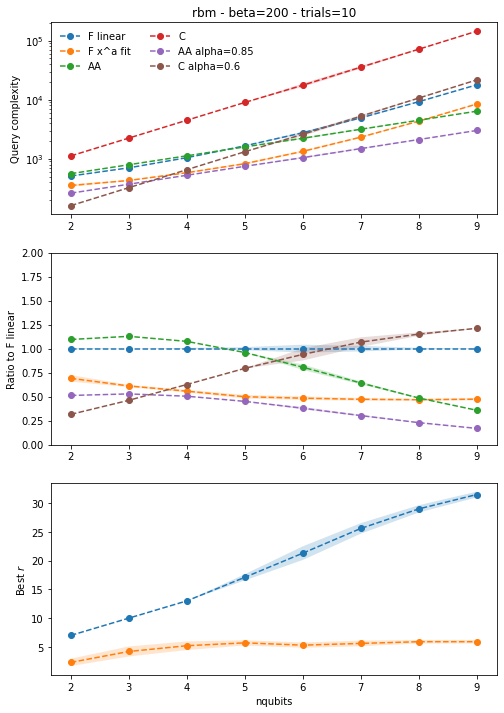

In [199]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,12))
axs[0].set_title('rbm - beta=%d - trials=%d' % (beta, ntrials))
plot_band(axs[0], nqubits_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], nqubits_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F x^a fit')
plot_band(axs[0], nqubits_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], nqubits_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')

plot_band(axs[0], nqubits_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], nqubits_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], nqubits_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], nqubits_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], nqubits_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[2].set_xlabel(r'nqubits')
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Best $r$')
plot_band(axs[2], nqubits_range, np.mean(bestr, axis=1), np.std(bestr, axis=1), label='F linear')
plot_band(axs[2], nqubits_range, np.mean(bestr_opt, axis=1), np.std(bestr_opt, axis=1), 'F x^a fit')

plt.savefig('rbm_beta_%d.png' % (beta), bbox_inches='tight')

x= [0.5 1. ] DeltaBeta= [0.03215938167704748, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.03335521137250016, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.02555198106551309, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.010971656548231215, 0.189113607598999, 1.0] 

x= [0.25 0.5  0.75 1.  ] DeltaBeta= [0.012249970848383121, 0.11067958641223377, 0.4010995522491908, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.03939844225573307, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.025095709335710283, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.040998914716909765, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.03904977253585064, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.03434160736169717, 1.0] 

x= [0.25 0.5  0.75 1.  ] DeltaBeta= [0.0003063568998626543, 0.017503054015304137, 0.1865633617056779, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.00034137333965095424, 0.010623957972455743, 0.07937222414974203, 0.33063063189384134, 1.0] 

x= [0.25 0.5  0.75 1.  ] DeltaBeta= [0.000350180268955277, 0.018713104204147346, 0.19181198010287, 1.0] 

x= [0.25 0.5  0.75 1. 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.011818033523637445, 0.0657940334039574, 0.1796216603879252, 0.36629231275261226, 0.6366059382956114, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.011269975145831551, 0.06390605819878956, 0.1763522186077347, 0.36237739850008716, 0.6335373958356957, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.012511325585353, 0.08255629240755608, 0.24894067448348572, 0.5447497445083558, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.011646261893150073, 0.06520602302923939, 0.17860714934152186, 0.36508069956682615, 0.6356582026900229, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.011385240465092117, 0.06430602735815114, 0.17704779680576824, 0.36321280760527397, 0.6341937218662816, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.0115672824558

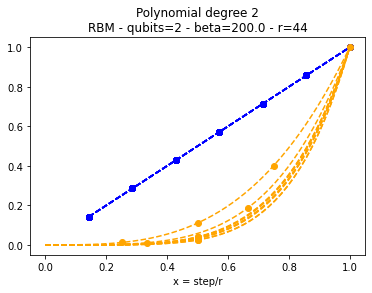

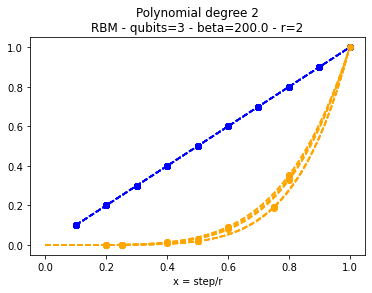

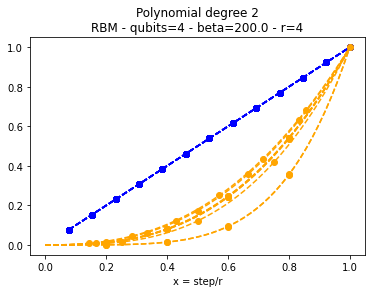

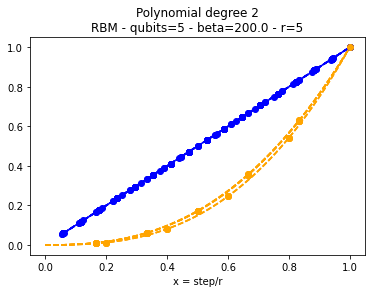

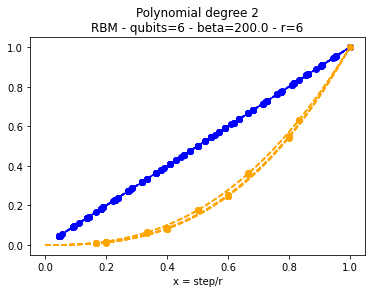

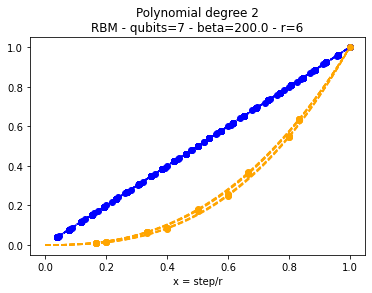

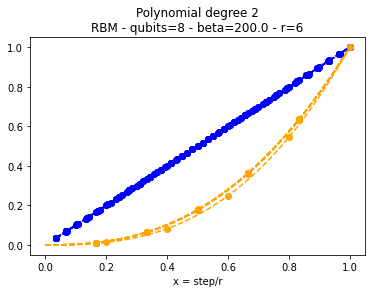

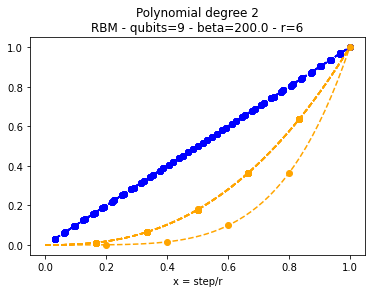

In [200]:
# plot
xx = np.linspace(0,1,50)
for ii, nqubits in enumerate(nqubits_range):
    plt.figure()
    plt.title('Polynomial degree %d\nRBM - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr, xr, 'o--', color='blue', label=f'r={r}')        
        
        r = int(bestr_opt[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o', color='orange', label=f'r={r}')
        plt.plot(xx,[myschedule(ixr, parameters[ii][jj]) for ixr in xx], '--', color='orange')
        print('x=',xr,'DeltaBeta=',[myschedule(ixr, parameters[ii][jj]) for ixr in xr],'\n')
        
    plt.xlabel('x = step/r')